# Experiments to Malaria Project

#### This notebook describes performed experiments, qualitative analysis and results discussion

<a id='imports'></a>
### Imports

In [5]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import zipfile as zp
import synapseclient as syna
from getpass import getpass
from datetime import datetime

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error,mean_absolute_error, mean_squared_log_error
from darts.utils.statistics import check_seasonality, plot_acf
from pmdarima.arima import auto_arima

<a id='functions_definition'></a>
## Functions definition

<a id='loading_dataset'></a>
## Load dataset

In [6]:
 # Getting BD from Synapse
syn = syna.Synapse() 
syn.login(input('Sybapse User: '), getpass('Passwd:')) 
 
 # Obtain a pointer and download the data
 # sivep_completo.csv.zip - https://www.synapse.org/#!Synapse:syn24225699
dataset = syn.get(entity='syn25713874')
 
 # Get the path to the local copy of the data file 
filepath = dataset.path

with zp.ZipFile(filepath,"r") as zip_ref:
    zip_ref.extractall("")

Sybapse User:  nataliarodrigues
Passwd: ··········



UPGRADE AVAILABLE

A more recent version of the Synapse Client (2.7.0) is available. Your version (2.6.0) can be upgraded by typing:
    pip install --upgrade synapseclient

Python Synapse Client version 2.7.0 release notes

https://python-docs.synapse.org/build/html/news.html



Welcome, Natalia Rodrigues da Silva!



In [7]:
df_full = pd.read_csv('./dados/sivep_data.csv', sep=';', low_memory=False, encoding="ISO-8859-1")
df_full.shape

(3737123, 51)

In [8]:
x = df_full[['dt_nasci']].groupby('dt_nasci').size()

In [10]:
df_full[['qtd_para', 'niv_esco', 'gestante', 'esquema', 'dt_nasci']].isnull().sum()

qtd_para    2626836
niv_esco     280198
gestante      67732
esquema      140593
dt_nasci     825993
dtype: int64

In [11]:
df_full[['vivax', 'raca', 'hemoparasi', 'exame', 'examinador', 'falciparum']].isnull().sum()

vivax         1943611
raca          1943668
hemoparasi    1963512
exame         1943602
examinador    1943597
falciparum    1943611
dtype: int64

In [12]:
df_full.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3737123 entries, 0 to 3737122
Data columns (total 51 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   ï»¿uid         3737123 non-null  int64  
 1   ano            3737123 non-null  int64  
 2   cod_noti       3737123 non-null  int64  
 3   dt_notif       3737123 non-null  object 
 4   dt_envlo       3737123 non-null  object 
 5   dt_digit       3524462 non-null  object 
 6   sem_noti       3736854 non-null  float64
 7   tipo_lam       3737123 non-null  object 
 8   uf_notif       3737123 non-null  object 
 9   mun_noti       3737123 non-null  int64  
 10  cod_unin       3737123 non-null  int64  
 11  cod_agen       3667656 non-null  float64
 12  dt_nasci       2911130 non-null  object 
 13  id_pacie       3737112 non-null  float64
 14  id_dimea       3737112 non-null  object 
 15  sexo           3736775 non-null  object 
 16  raca           1793455 non-null  object 
 17  pais_res

## Data Preprocessing

In [9]:
df_prep = df_full.copy()

In [10]:
df_prep.shape

(3737123, 51)

In [11]:
df_prep.columns

Index(['ï»¿uid', 'ano', 'cod_noti', 'dt_notif', 'dt_envlo', 'dt_digit',
       'sem_noti', 'tipo_lam', 'uf_notif', 'mun_noti', 'cod_unin', 'cod_agen',
       'dt_nasci', 'id_pacie', 'id_dimea', 'sexo', 'raca', 'pais_res',
       'uf_resid', 'mun_resi', 'loc_resi', 'sintomas', 'dt_sinto', 'cod_ocup',
       'uf_infec', 'pais_inf', 'mun_infe', 'loc_infe', 'dt_exame', 'res_exam',
       'qtd_para', 'qtd_cruz', 'dt_trata', 'esquema', 'hemoparasi', 'exame',
       'examinador', 'id_lvc', 'gestante', 'vivax', 'falciparum', 'niv_esco',
       'id_pacie_anos', 'nu_predi_infe', 'nu_habit_infe', 'zona_infe',
       'categori_infe', 'nu_predi_resi', 'nu_habit_resi', 'zona_resi',
       'categori_resi'],
      dtype='object')

**Converter colunas de datas para datetime**

In [12]:
date_cols = ['dt_sinto', 'dt_notif', 'dt_exame', 'dt_trata']
df_prep[date_cols] = df_prep[date_cols].apply(pd.to_datetime,  errors='coerce')
df_prep[date_cols].head()

,dt_sinto,dt_notif,dt_exame,dt_trata
0,2007-01-01,2007-01-02,2007-01-02,2007-07-02
1,2007-01-02,2007-01-02,2007-01-02,2007-07-02
2,2007-01-01,2007-01-02,2007-01-02,2007-01-02
3,2006-12-30,2007-01-02,2007-01-02,2007-01-02
4,2007-01-02,2007-01-02,2007-01-03,2007-01-03


**Deixar somente registros de 2007 a 2019 considerando a data de notificação: dt_notif**

In [13]:
df_prep = df_prep[df_prep['dt_notif'] <= pd.to_datetime("2019-12-31")]
df_prep.shape

(3676991, 51)

In [14]:
#Deixar somente as colunas dt_notif e uf_notif
cols_to_drop = ['ï»¿uid', 'ano', 'dt_envlo', 'dt_digit', 'sem_noti', 'tipo_lam', 'mun_noti', 'cod_unin', 'cod_agen', 
                'dt_nasci', 'id_pacie', 'id_dimea', 'sexo', 'raca', 'pais_res', 'uf_resid', 'mun_resi', 'loc_resi', 'sintomas', 'dt_sinto', 'cod_ocup',
                'uf_infec', 'pais_inf', 'mun_infe', 'loc_infe', 'dt_exame', 'res_exam', 'qtd_para', 'qtd_cruz', 'dt_trata', 'esquema', 'hemoparasi', 'exame',
                'examinador', 'id_lvc', 'gestante', 'vivax', 'falciparum', 'niv_esco', 'id_pacie_anos', 'nu_predi_infe', 'nu_habit_infe', 'zona_infe', 
                'categori_infe', 'nu_predi_resi', 'nu_habit_resi', 'zona_resi', 'categori_resi']
df_prep = df_prep.drop(columns=cols_to_drop, axis=1)

**Criar uma base de dados contabilizando o número de casos por mês agrupando por UF**

In [15]:
df_prep.head()

,cod_noti,dt_notif,uf_notif
0,1,2007-01-02,AC
1,2,2007-01-02,AC
2,14,2007-01-02,AC
3,18,2007-01-02,AC
4,24,2007-01-02,AC


In [16]:
#Separar a dt_notif em dia, mês e ano
df_prep['year_notif'] = df_prep['dt_notif'].dt.year
df_prep['month_notif'] = df_prep['dt_notif'].dt.month
df_prep['day_notif'] = df_prep['dt_notif'].dt.day

### Bases Agrupadas por mes e estado e apenas por mês

In [17]:
df_prep.head()

,cod_noti,dt_notif,uf_notif,year_notif,month_notif,day_notif
0,1,2007-01-02,AC,2007,1,2
1,2,2007-01-02,AC,2007,1,2
2,14,2007-01-02,AC,2007,1,2
3,18,2007-01-02,AC,2007,1,2
4,24,2007-01-02,AC,2007,1,2


In [18]:
proporcao = lambda x: 100 * x / float(x.sum())

In [19]:
# Criar dataframe com número de casos por UF (mês)
df_group = df_prep.groupby(['year_notif', 'month_notif', 'uf_notif']).agg(
    dt_notif=('dt_notif', 'last'), 
    num_cases=('cod_noti', 'count')
)

df_group['prop'] = df_group.groupby(level=[0,1])['num_cases'].transform(lambda x: 100 * x / float(x.sum()))
df_group = df_group.reset_index()#.sort_values(['year_notif','month_notif','prop'], ascending = False)
df_group

,year_notif,month_notif,uf_notif,dt_notif,num_cases,prop
0,2007,1,AC,2007-01-01,6274,12.797291
1,2007,1,AM,2007-01-03,14948,30.489944
2,2007,1,AP,2007-01-25,3207,6.541427
3,2007,1,MA,2007-01-09,815,1.662383
4,2007,1,MT,2007-01-01,633,1.291152
...,...,...,...,...,...,...
1392,2019,12,MT,2019-12-28,213,1.573233
1393,2019,12,PA,2019-12-27,2661,19.654332
1394,2019,12,RO,2019-12-17,1204,8.892828
1395,2019,12,RR,2019-12-30,2430,17.948150


In [20]:
df_group['num_cases'].sum()

3676991

In [21]:
df_group['year_month_notif'] = df_group.year_notif.astype(str) + '-' + ('0'+df_group.month_notif.astype(str)).str[-2:]

In [22]:
df_group.head(10)

,year_notif,month_notif,uf_notif,dt_notif,num_cases,prop,year_month_notif
0,2007,1,AC,2007-01-01,6274,12.797291,2007-01
1,2007,1,AM,2007-01-03,14948,30.489944,2007-01
2,2007,1,AP,2007-01-25,3207,6.541427,2007-01
3,2007,1,MA,2007-01-09,815,1.662383,2007-01
4,2007,1,MT,2007-01-01,633,1.291152,2007-01
5,2007,1,PA,2007-01-29,8799,17.947620,2007-01
6,2007,1,RO,2007-01-05,11643,23.748623,2007-01
7,2007,1,RR,2007-01-30,2675,5.456288,2007-01
8,2007,1,TO,2007-01-11,32,0.065271,2007-01
9,2007,2,AC,2007-02-14,4872,11.820365,2007-02


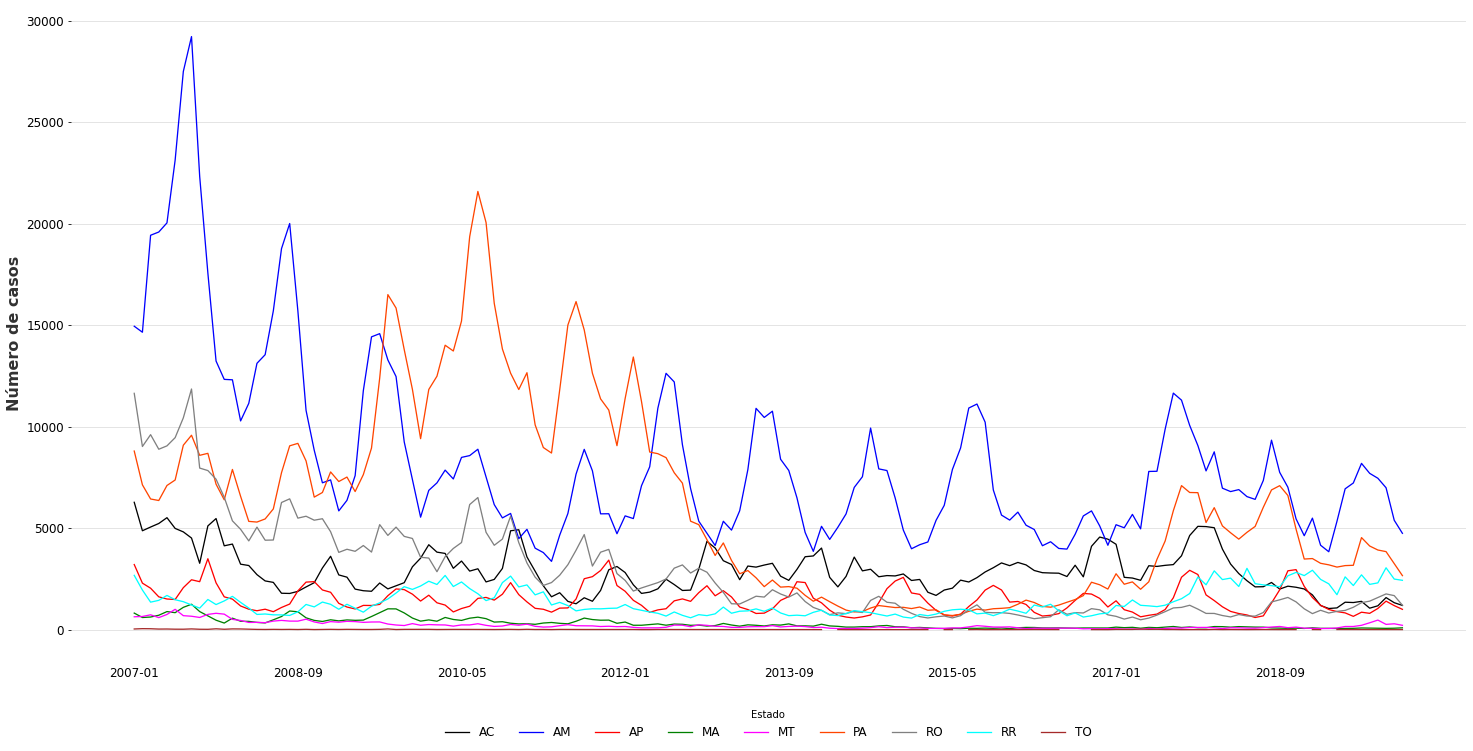

In [65]:
col = ['black','blue','red','green','magenta','orangered','grey','cyan', 'brown']
fig = df_group.pivot(index='year_month_notif', columns='uf_notif', values='num_cases').plot(figsize=(25,12),color = col)
plt.xlabel('', fontsize=18)
plt.ylabel('Número de casos', fontsize=16)
plt.legend(title="Estado", loc="center", ncol=9, fontsize=12, bbox_to_anchor=(0.5,-0.1),borderaxespad=0)
plt.grid(axis = 'x')
fig.tick_params(colors='black', which='both', labelsize = 12)

plt.savefig("line_plot.pdf", format="pdf", dpi = 100, bbox_inches='tight')#

In [26]:
#df_group.groupby(['year_notif', 'uf_notif'])['num_cases'].sum().groupby(level=0).apply(lambda x: 100*x/x.sum()).unstack().plot(kind='bar', stacked=True, figsize=(25,12))
#plt.show()

In [27]:
df_group2 = df_prep.groupby(['year_notif', 'month_notif']).agg(
    dt_notif=('dt_notif', 'last'), 
    num_cases=('cod_noti', 'count')
)
df_group2 = df_group2.reset_index().sort_values('dt_notif')

In [28]:
df_group2['year_month_notif'] = df_group2.year_notif.astype(str) + '-' + ('0'+df_group2.month_notif.astype(str)).str[-2:]

In [29]:
df_group2.head()

,year_notif,month_notif,dt_notif,num_cases,year_month_notif
0,2007,1,2007-01-03,49026,2007-01
1,2007,2,2007-02-27,41217,2007-02
2,2007,3,2007-03-05,45320,2007-03
3,2007,4,2007-04-24,44458,2007-04
4,2007,5,2007-05-13,46574,2007-05


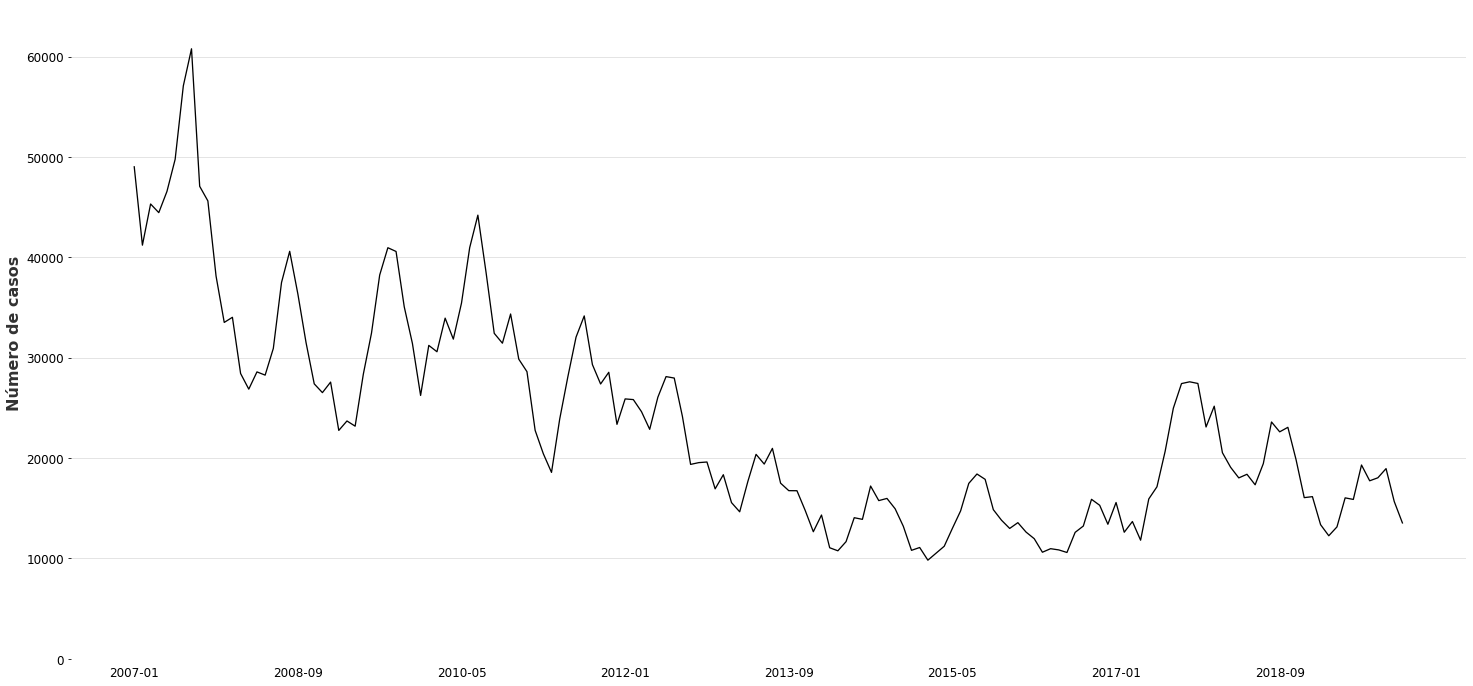

In [31]:
fig = df_group2[['num_cases','year_month_notif']].set_index('year_month_notif').plot(figsize=(25,12), legend=None)
plt.xlabel('', fontsize=18)
plt.ylabel('Número de casos', fontsize=16)
plt.grid(axis = 'x')
plt.ylim(0,65000)
fig.tick_params(colors='black', which='both', labelsize = 12)

plt.savefig("line_plot_total.pdf", format="pdf", dpi = 100, bbox_inches='tight')

In [32]:
df_ts = df_group.copy()

In [33]:
df_ts.head()

,year_notif,month_notif,uf_notif,dt_notif,num_cases,prop,year_month_notif
0,2007,1,AC,2007-01-01,6274,12.797291,2007-01
1,2007,1,AM,2007-01-03,14948,30.489944,2007-01
2,2007,1,AP,2007-01-25,3207,6.541427,2007-01
3,2007,1,MA,2007-01-09,815,1.662383,2007-01
4,2007,1,MT,2007-01-01,633,1.291152,2007-01


In [34]:
df_ts[df_ts['uf_notif'] == 'TO']['year_month_notif'].nunique()

149

In [35]:
(df_ts[df_ts['uf_notif'] == 'TO']['num_cases'] < 10).sum()

104

In [36]:
ufs = df_ts['uf_notif'].unique()
ufs = np.sort(ufs)
ufs

array(['AC', 'AM', 'AP', 'MA', 'MT', 'PA', 'RO', 'RR', 'TO'], dtype=object)

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

AC


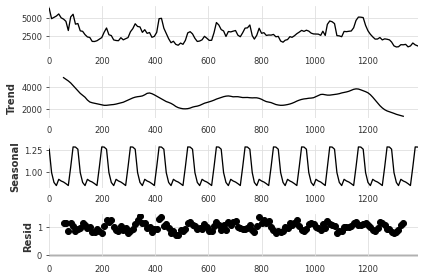



----------------------------------------


AM


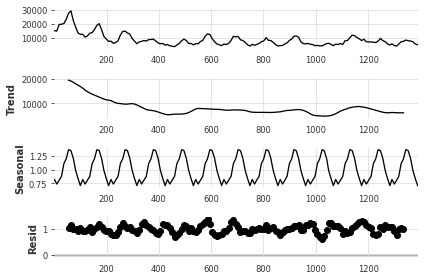



----------------------------------------


AP


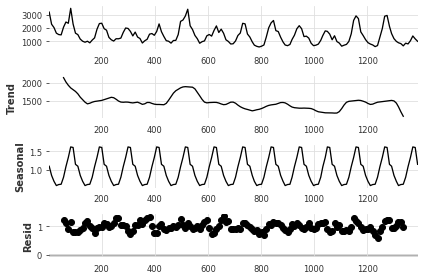



----------------------------------------


MA


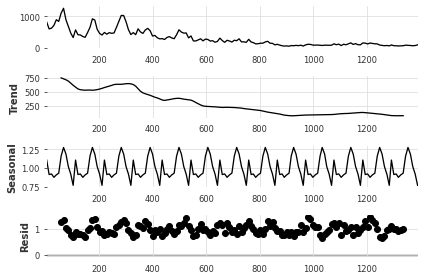



----------------------------------------


MT


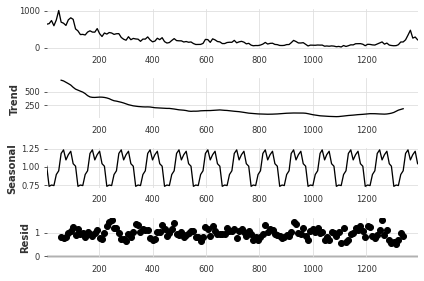



----------------------------------------


PA


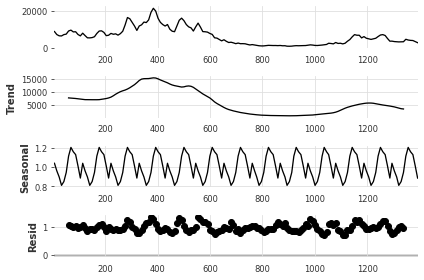



----------------------------------------


RO


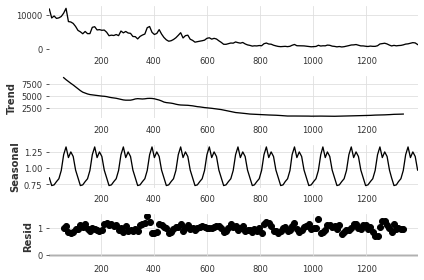



----------------------------------------


RR


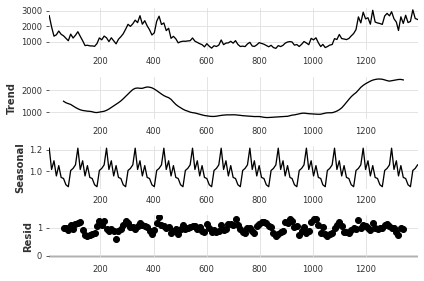



----------------------------------------


TO


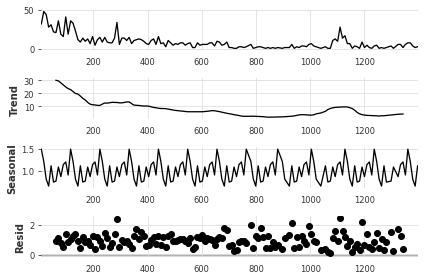



----------------------------------------




In [38]:
for uf in ufs:
    print(uf)
    cond = df_ts['uf_notif'] == uf
    aux = df_ts.loc[cond, ['num_cases']]    
    result = seasonal_decompose(aux, model='multiplicative', period=12)
    result.plot()
    pyplot.show()
    print("\n")
    print("----------------------------------------")
    print("\n")

In [41]:
from darts import TimeSeries

UF: AC
is seasonal? : True
periodicity (months) : 11.0
periodicity (~years) : 0.9


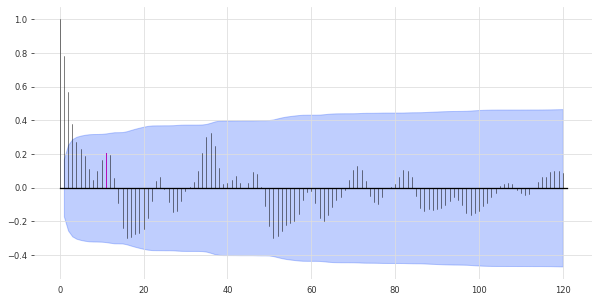

----------------------------------

UF: AM
is seasonal? : True
periodicity (months) : 12.0
periodicity (~years) : 1.0


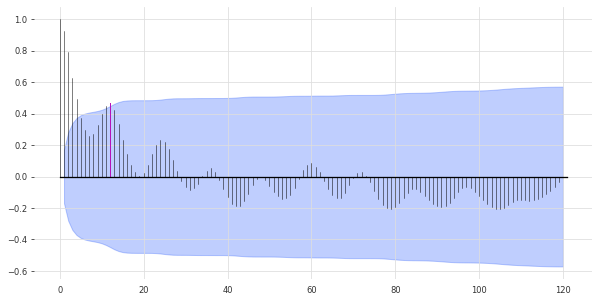

----------------------------------

UF: AP
is seasonal? : True
periodicity (months) : 12.0
periodicity (~years) : 1.0


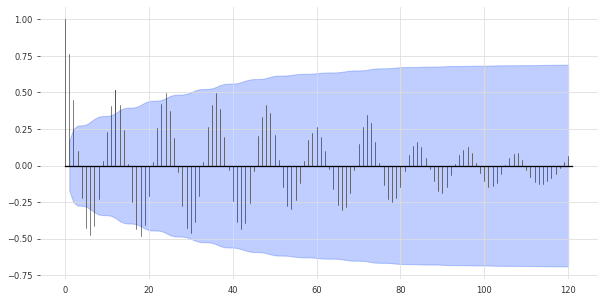

----------------------------------

UF: MA
is seasonal? : True
periodicity (months) : 12.0
periodicity (~years) : 1.0


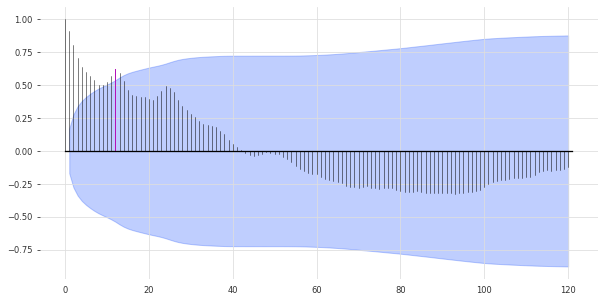

----------------------------------

UF: MT
is seasonal? : True
periodicity (months) : 36.0
periodicity (~years) : 3.0


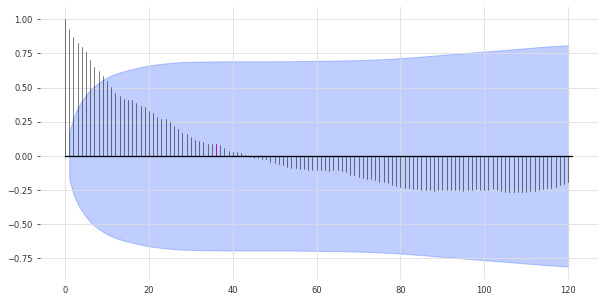

----------------------------------

UF: PA
is seasonal? : True
periodicity (months) : 10.0
periodicity (~years) : 0.8


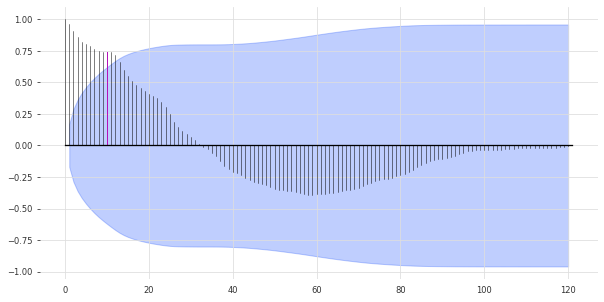

----------------------------------

UF: RO
is seasonal? : True
periodicity (months) : 23.0
periodicity (~years) : 1.9


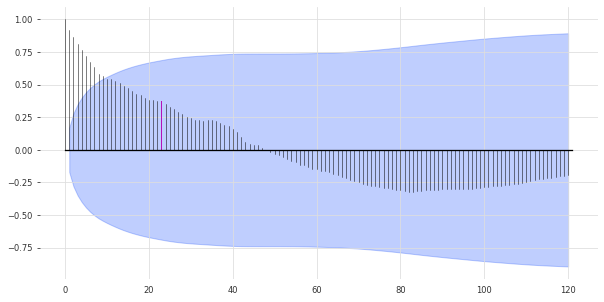

----------------------------------

UF: RR
is seasonal? : True
periodicity (months) : 84.0
periodicity (~years) : 7.0


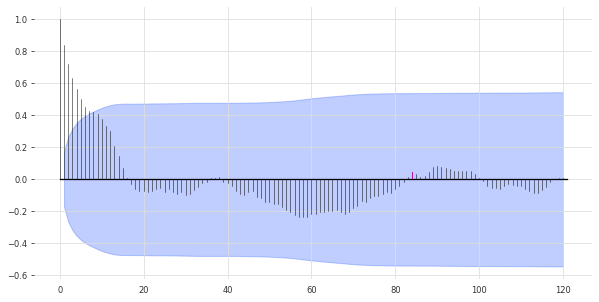

----------------------------------

UF: TO
is seasonal? : False
periodicity (months) : 0.0
periodicity (~years) : 0.0


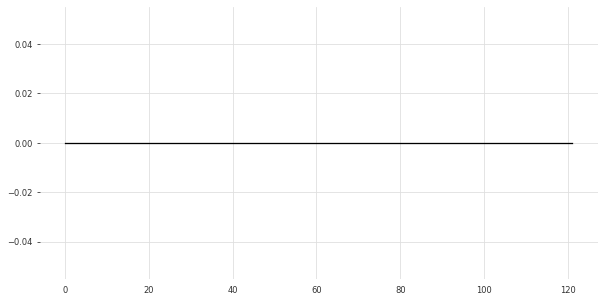

----------------------------------



In [42]:
ufs = np.sort(df_group['uf_notif'].unique())
for uf in ufs:
    print(f'UF: {uf}')
    cond = (df_ts['uf_notif'] == uf) & (df_ts['year_notif'] <= 2017)
    df_aux = df_group.loc[cond, ['dt_notif', 'num_cases']].copy()
    df_aux['dt_notif'] = pd.to_datetime(df_aux['dt_notif']).dt.year.astype(str) + "-" + pd.to_datetime(df_aux['dt_notif']).dt.month.astype(str)
    ts_aux = TimeSeries.from_dataframe(df_aux, 'dt_notif', 'num_cases', fill_missing_dates=True, freq='MS')

    # analyze its seasonality
    is_seasonal, periodicity = check_seasonality(ts_aux, max_lag=240)
    dict_seas = {
        "is seasonal?":is_seasonal, 
        "periodicity (months)":f'{periodicity:.1f}', 
        "periodicity (~years)": f'{periodicity/12:.1f}'}
    _ = [print(k,":",v) for k,v in dict_seas.items()]

    plot_acf(ts_aux, periodicity, max_lag=120)
    plt.show()

    print("----------------------------------\n")

is seasonal? : True
periodicity (months) : 12.0
periodicity (~years) : 1.0


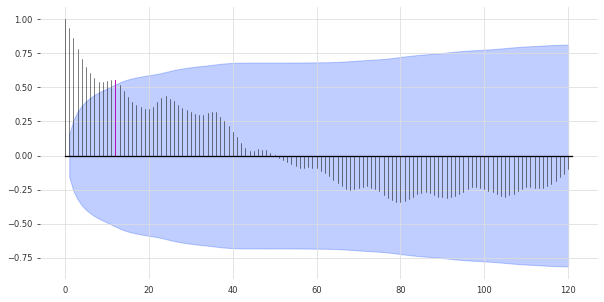

----------------------------------



In [43]:
cond = df_ts['year_notif'] <= 2017
df_aux = df_group2.loc[cond, ['dt_notif', 'num_cases']].copy()
df_aux['dt_notif'] = pd.to_datetime(df_aux['dt_notif']).dt.year.astype(str) + "-" + pd.to_datetime(df_aux['dt_notif']).dt.month.astype(str)
ts_aux = TimeSeries.from_dataframe(df_aux, 'dt_notif', 'num_cases', fill_missing_dates=True, freq='MS')

# analyze its seasonality
is_seasonal, periodicity = check_seasonality(ts_aux, max_lag=240)
dict_seas = {
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

plot_acf(ts_aux, periodicity, max_lag=120)
plt.show()

print("----------------------------------\n")

### Teste de Dikey-Fuller por mes

In [28]:
from statsmodels.tsa.stattools import adfuller

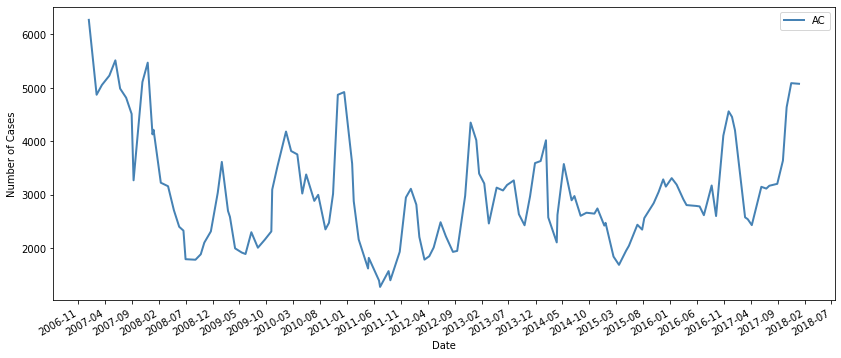

ADF Statistic: -3.634889
p-value: 0.005128
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
A série é estacionária ao nível de 1%




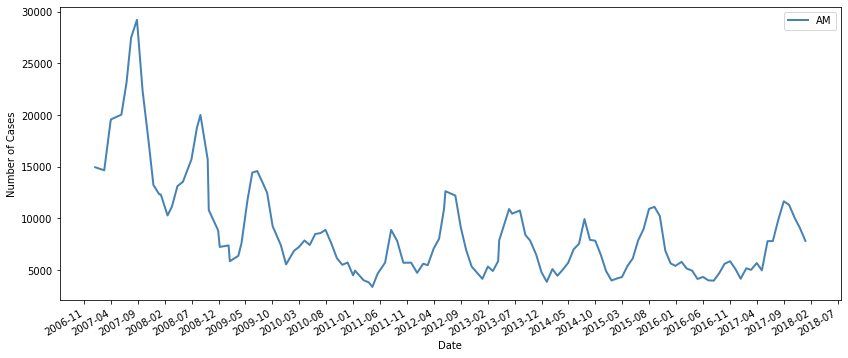

ADF Statistic: -3.412841
p-value: 0.010529
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
A série é estacionária ao nível de 5%




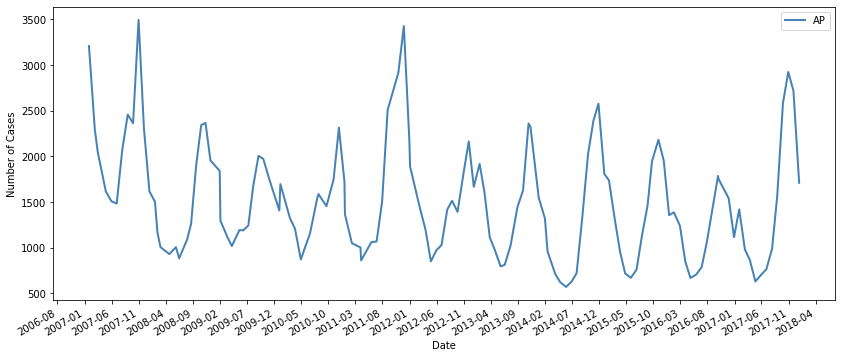

ADF Statistic: -2.880619
p-value: 0.047649
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
A série é estacionária ao nível de 5%




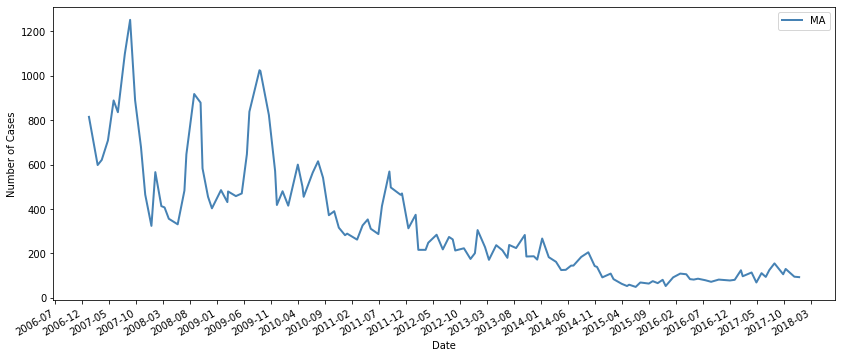

ADF Statistic: -1.527302
p-value: 0.519965
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
A série não é estacionária




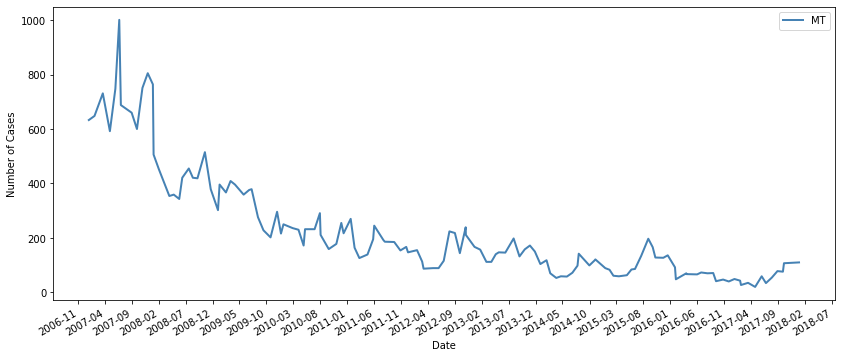

ADF Statistic: -5.022275
p-value: 0.000020
Critical Values:
	1%: -3.485
	5%: -2.886
	10%: -2.580
A série é estacionária ao nível de 1%




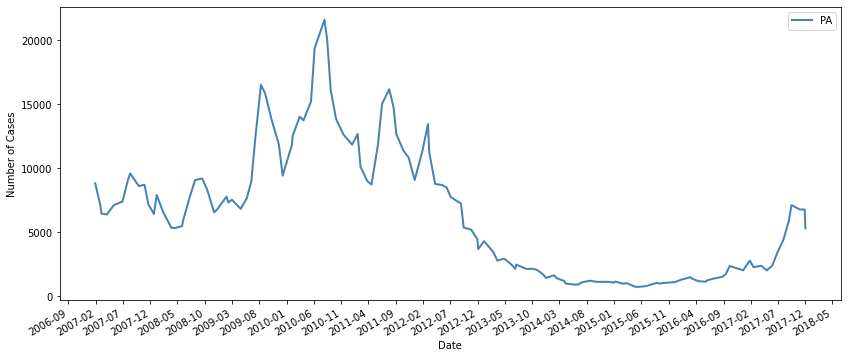

ADF Statistic: -1.732902
p-value: 0.414245
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
A série não é estacionária




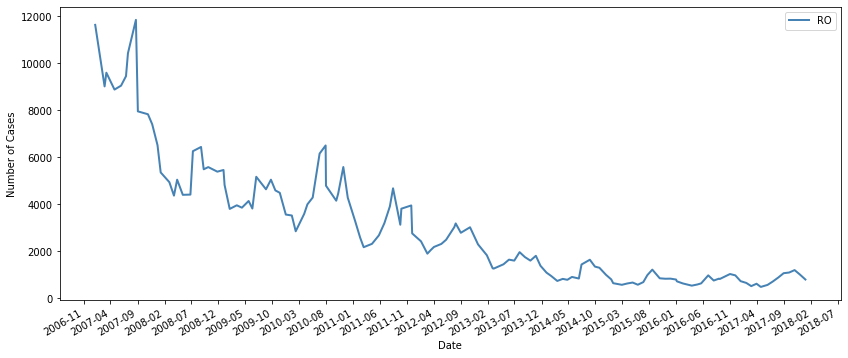

ADF Statistic: -2.378914
p-value: 0.147776
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
A série não é estacionária




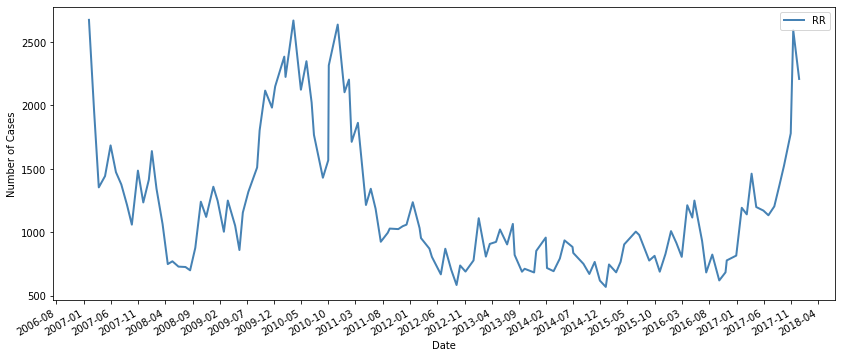

ADF Statistic: -2.256729
p-value: 0.186303
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
A série não é estacionária




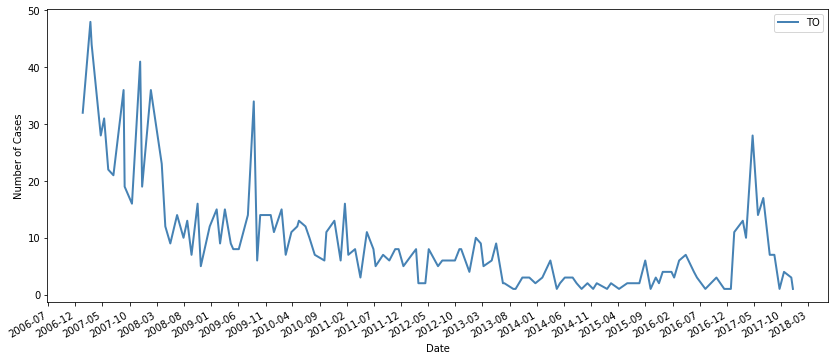

ADF Statistic: -4.052524
p-value: 0.001159
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579
A série é estacionária ao nível de 1%




In [244]:
# Plotar série do número de casos por UF e resultados dos testes de Dicky-Fuller 

plots = []

for uf in ufs:
    
    fig, ax = plt.subplots(figsize=(14,6))
    cond = (df_ts['uf_notif'] == uf) & (df_ts['year_notif'] <= 2017)
    df_ts.loc[cond, ['dt_notif','num_cases']].set_index('dt_notif').plot(ax=ax, color='steelblue',  linewidth=2)

      # Set title and labels for axes
    ax.set(xlabel="Date",ylabel="Number of Cases",title="")

    ax.legend([uf])

      # Define the date format
    date_form = mdates.DateFormatter("%Y-%m")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
    plt.show()

    result = adfuller(df_ts.loc[cond, 'num_cases'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] < 0.01:
        print('A série é estacionária ao nível de 1%')
    elif result[1] < 0.05:
        print('A série é estacionária ao nível de 5%')
    elif result[1] < 0.1:
        print('A série é estacionária ao nível de 10%')
    else: 
        print('A série não é estacionária')
    print("\n")

Como resultado dos testes para cada UF, temos que: 
 
*   as séries temporais de AC, AM, MT e TO são estacionárias em nível de significância de 1%
*   as séries temporais de AP e RO são estacionárias em nível de significância de 10%
*   as séries temporais de MA, PA e RR **não** são estacionárias.


In [246]:
ufs_estac = ['AC','AM','AP','MT', 'TO']
ufs_naoestac = ['MA','PA','RR','RO']

### Teste Dickey-Fuller para o total

In [31]:
df_ts2 = df_group2.copy()

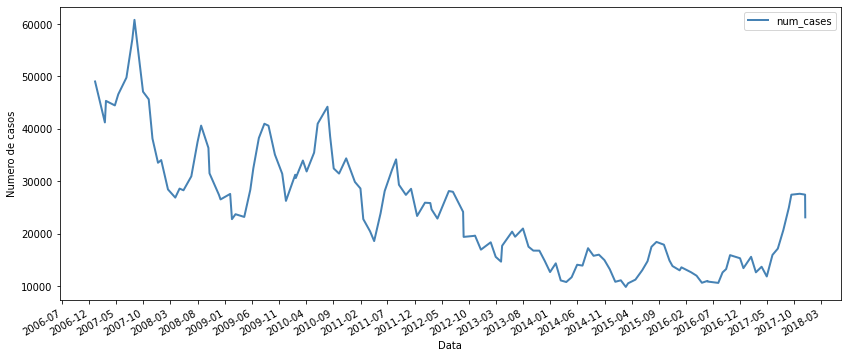

ADF Statistic: -1.768966
p-value: 0.395975
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
A série não é estacionária




In [257]:
fig, ax = plt.subplots(figsize=(14,6))
cond = df_ts2['year_notif'] <= 2017
df_ts2.loc[cond, ['dt_notif','num_cases']].set_index('dt_notif').plot(ax=ax, color='steelblue',  linewidth=2)

# Set title and labels for axes
ax.set(xlabel="Data",ylabel="Numero de casos",title="")

      # Define the date format
date_form = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.savefig('line_plot_total.png')
plt.show()

result = adfuller(df_ts2.loc[cond, 'num_cases'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1] < 0.01:
    print('A série é estacionária ao nível de 1%')
elif result[1] < 0.05:
    print('A série é estacionária ao nível de 5%')
elif result[1] < 0.1:
    print('A série é estacionária ao nível de 10%')
else: 
    print('A série não é estacionária')
print("\n")

### Analisando a autocorrelação

#### Auto Correlation Function (ACF) e (PACF)

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

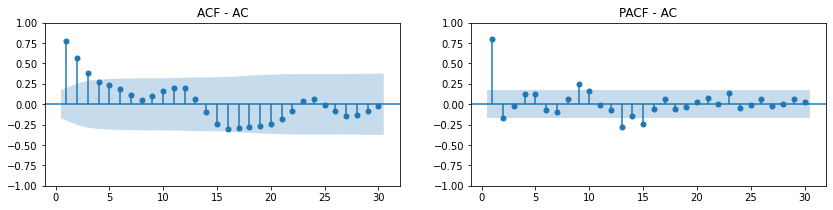

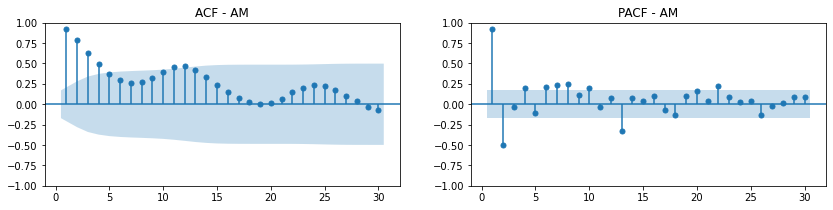

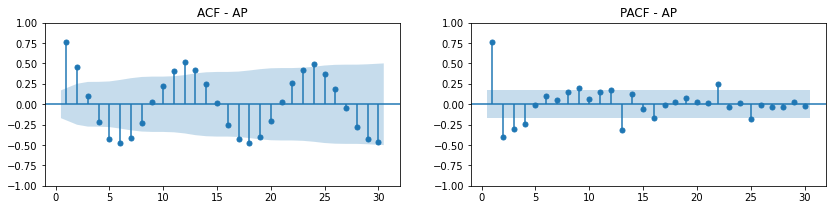

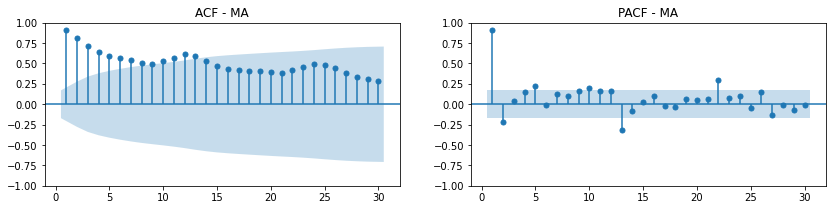

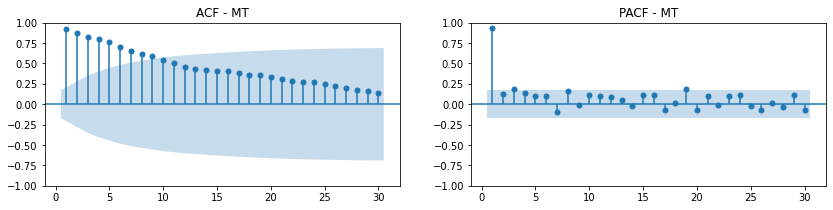

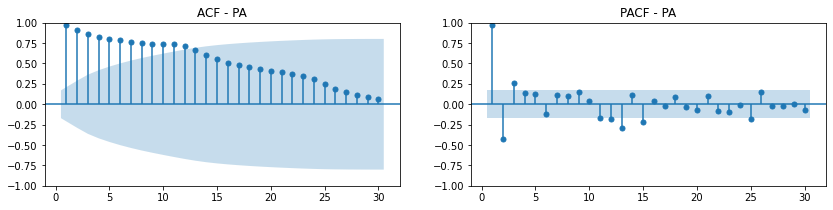

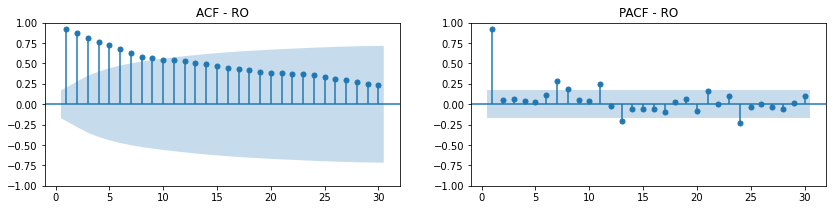

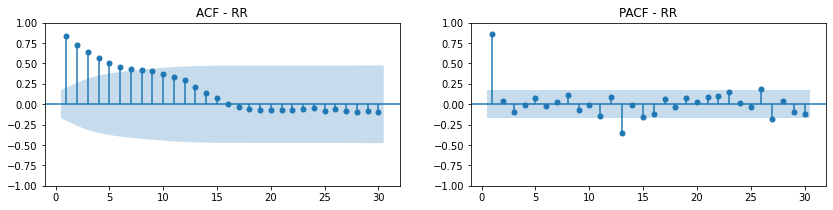

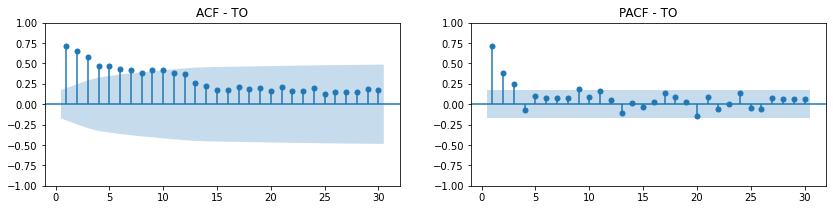

In [258]:
# Plotar os gráficos ACF e PACF para cada série
for uf in ufs:
    cond = (df_ts['uf_notif'] == uf) & (df_ts['year_notif'] <= 2017)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))

    plot_acf(df_ts.loc[cond, 'num_cases'], lags=30, zero=False, title="ACF - " + uf, ax=ax1)
    plot_pacf(df_ts.loc[cond, 'num_cases'], lags=30, zero=False, title="PACF - " + uf, method='ols', ax=ax2)
    plt.show()

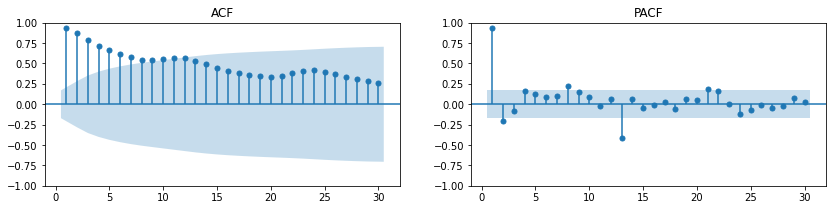

In [260]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))
cond = df_ts2['year_notif'] <= 2017
plot_acf(df_ts2.loc[cond,'num_cases'], lags=30, zero=False, title="ACF", ax=ax1)
plot_pacf(df_ts2.loc[cond,'num_cases'], lags=30, zero=False, title="PACF", method='ols', ax=ax2)
plt.show()

## Rolling Forecast using Auto Arima
Neste experimento vamos começar usando as observações de 2007 a 2017 para treinar o primeiro modelo e gerar uma previsão para o mês seguinte, janeiro de de 2018. Em seguida, o mês de janeiro de 2018 é incluído na base de treinamento para gerar um novo modelo e gerar uma previsão para fevereiro de 2018, e assim sucessivamente.

As obervações dos anos de 2007 a 2017 serão utilizadas para treino, enquanto o conjunto de teste conterá as observações de 2018 e 2019.

In [248]:
df_result_validacao = pd.DataFrame(columns=['dt_notif','uf_notif','num_cases','y_pred'])

# Gerar um modelo de regressão para série, considerando cada UF
#for uf in ufs:

    print("UF: " + uf)
    cond = df_ts['uf_notif'] == uf
    df_uf = df_ts[cond].copy().reset_index(drop=True)
    X_val = df_uf[ (df_uf['year_notif'] > 2015) & (df_uf['year_notif'] <= 2017)].copy()
    X_val['y_pred'] = 0.0

    X_train = df_uf[df_uf['year_notif'] <= 2015].copy()
    last_index = df_uf[df_uf['year_notif'] <= 2015].index
    last_index = last_index[-1]
    index_val = X_val.index[0]
    predictions = list()
    
    if uf in ufs_estac:
        print('Estacionaria')
        start_d = 0
    else:
        print('Nao Estacionaria')
        start_d = 1

    for t in range(len(X_val)):
    
        print(f"Criando modelo para: {df_uf.iloc[last_index + 1]['year_notif']}-{df_uf.iloc[last_index + 1]['month_notif']}")
        arima_model = auto_arima(X_train['num_cases'], start_p=0, d=start_d, start_q=0,
                              max_p=10, max_d=10, maxq_q=10, start_P=0,
                              D=1, start_Q=0, max_P=10, max_D=10,
                              max_Q=10, m=12, seasonal=True,
                              error_action='warn', trace=True,
                              supress_warnings=True, stepwise=True, randon_state=13)
        y_pred = arima_model.predict(n_periods=1)
        predictions.append(y_pred)
        X_val.loc[index_val, 'y_pred'] = y_pred
        last_index += 1
        index_val += 1
        X_train = X_train.append(df_uf.iloc[last_index])

    frames = [df_result_validacao, X_val[['dt_notif','uf_notif','num_cases','y_pred']].copy()]
    df_result_validacao = pd.concat(frames)  
    print("R^2: ", r2_score(X_val['num_cases'], predictions))
    mse = mean_squared_error(X_val['num_cases'], predictions)
    rmse = math.sqrt(mse)
    mape = mean_absolute_percentage_error(X_val['num_cases'], predictions)
    print("RMSE: ", rmse)
    print("MAPE: ", mape)

    print("----------------------------------------\n")

UF: AC
Estacionaria
Criando modelo para: 2016-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1631.825, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1499.393, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1636.333, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1535.560, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1482.533, Time=1.50 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1483.467, Time=3.12 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1483.062, Time=1.90 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1486.654, Time=0.84 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1486.288, Time=4.28 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1537.116, Time=0.69 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1484.869, Time=1.26 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1484.476, Time=1.85 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1482.781, Time=0.56 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 21.129 seconds
Criando modelo para: 2016-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1648.742, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1513.870, Time=0.63 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1652.840, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1550.720, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1497.049, Time=1.52 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1497.936, Time=2.83 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1497.586, Time=1.92 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1500.995, Time=0.89 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.42 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1552.143, Time=0.71 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1499.395, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1497.201, Time=0.56 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 20.957 seconds
Criando modelo para: 2016-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1666.668, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1531.760, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1670.118, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1567.071, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1513.416, Time=1.00 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1514.389, Time=1.83 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1513.637, Time=2.00 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1517.140, Time=0.86 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.26 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1567.782, Time=0.75 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1515.002, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=1.55 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 31.744 seconds
Criando modelo para: 2016-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1684.275, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1546.705, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1687.181, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1582.067, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1528.327, Time=1.70 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1529.279, Time=2.78 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1528.969, Time=1.96 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1531.810, Time=0.86 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.36 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1584.226, Time=0.72 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1530.325, Time=2.0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=1.74 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 33.326 seconds
Criando modelo para: 2016-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1701.149, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1561.203, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1703.707, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1596.846, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1543.209, Time=1.02 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1543.863, Time=3.11 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1543.499, Time=2.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1546.064, Time=0.92 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.74 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1599.311, Time=0.72 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1544.855, Time=2.1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.28 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 33.973 seconds
Criando modelo para: 2016-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1717.840, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1576.053, Time=0.46 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1720.110, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1611.695, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1557.655, Time=1.01 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1558.721, Time=1.82 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1557.916, Time=2.01 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1560.323, Time=0.87 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1614.339, Time=0.72 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1559.279, Time=1.9

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.21 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 31.579 seconds
Criando modelo para: 2016-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1734.054, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1590.613, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1736.199, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1626.500, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1571.577, Time=1.53 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1572.633, Time=3.45 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1572.239, Time=1.97 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1574.700, Time=0.88 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.28 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1629.354, Time=0.73 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1573.577, Time=2.1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.24 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 34.433 seconds
Criando modelo para: 2016-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1750.200, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1605.075, Time=0.64 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1752.248, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1641.268, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1585.956, Time=1.61 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1587.051, Time=3.07 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1586.742, Time=2.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1588.910, Time=1.08 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.09 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1644.473, Time=0.73 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1588.325, Time=1.2

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.30 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 33.614 seconds
Criando modelo para: 2016-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1766.674, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1621.116, Time=0.68 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1768.503, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1656.603, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1602.887, Time=1.62 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1603.766, Time=3.01 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1603.396, Time=1.93 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1606.168, Time=0.92 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=3.86 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1660.560, Time=0.71 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1605.201, Time=1.3

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=1605.460, Time=2.51 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 32.967 seconds
Criando modelo para: 2016-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1782.618, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1636.426, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1784.526, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1672.304, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1617.524, Time=1.68 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1618.788, Time=1.97 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1617.934, Time=1.95 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1620.601, Time=1.08 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.14 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1675.659, Time=0.72 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1619.506, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=1.54 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 32.181 seconds
Criando modelo para: 2016-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1799.776, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1657.515, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1801.308, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1691.333, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1638.161, Time=1.62 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1639.571, Time=3.05 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1639.262, Time=2.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1640.500, Time=1.00 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=3.85 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1694.359, Time=0.75 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1640.014, Time=1.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.02 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 33.245 seconds
Criando modelo para: 2016-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1817.357, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1673.527, Time=0.64 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1818.459, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1706.819, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1654.157, Time=1.15 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1655.944, Time=2.08 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1655.561, Time=2.20 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1654.961, Time=0.98 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.41 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1713.077, Time=0.76 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1655.916, Time=2.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.46 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 34.709 seconds
Criando modelo para: 2017-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1834.973, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1689.137, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1835.670, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1721.972, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1669.594, Time=1.10 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1671.447, Time=2.21 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1671.129, Time=2.00 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1669.566, Time=1.06 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1667.575, Time=0.76 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1669.565, Time=1.71 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.4

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(0,1,1)[12]             : AIC=inf, Time=0.36 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12] intercept
Total fit time: 16.518 seconds
Criando modelo para: 2017-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1851.782, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1703.692, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1852.226, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1736.731, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1683.908, Time=1.13 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1685.594, Time=3.14 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1685.459, Time=2.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1683.779, Time=1.07 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1683.777, Time=1.55 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(1,1,1)[12]             : AIC=inf, Time=1.14 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12]          
Total fit time: 45.204 seconds
Criando modelo para: 2017-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1867.872, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1720.499, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1868.470, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1755.129, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1698.944, Time=1.19 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1700.734, Time=2.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1700.652, Time=1.49 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1699.980, Time=1.02 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.66 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1762.931, Time=0.80 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1700.935, Time=1.4

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=1701.023, Time=1.54 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 31.545 seconds
Criando modelo para: 2017-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1883.839, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1735.202, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1884.535, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1769.972, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1713.689, Time=1.17 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1715.455, Time=2.13 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1715.178, Time=2.07 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1778.469, Time=0.79 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1715.653, Time=1.5

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.17 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 32.497 seconds
Criando modelo para: 2017-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1899.799, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1749.721, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1900.595, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1784.737, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1728.177, Time=1.17 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1729.901, Time=2.14 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1729.786, Time=1.61 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.43 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1793.514, Time=0.80 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1730.134, Time=1.41 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.10 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 32.723 seconds
Criando modelo para: 2017-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1915.943, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1765.961, Time=0.63 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1916.638, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1800.749, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1742.873, Time=1.08 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1744.598, Time=2.06 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1744.494, Time=1.67 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1743.983, Time=1.04 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.73 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1808.606, Time=0.79 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1744.813, Time=1.3

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.16 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 32.550 seconds
Criando modelo para: 2017-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1932.059, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1780.514, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1932.661, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1815.549, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1757.330, Time=1.69 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1759.085, Time=3.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1759.095, Time=1.57 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.08 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1824.030, Time=0.80 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1759.396, Time=1.35 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.28 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 34.151 seconds
Criando modelo para: 2017-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1948.371, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1795.373, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1948.826, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1830.627, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1771.907, Time=1.70 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1773.822, Time=2.11 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1773.731, Time=1.70 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1772.974, Time=1.06 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.55 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1839.542, Time=0.85 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1773.977, Time=1.3

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.55 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 33.378 seconds
Criando modelo para: 2017-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1964.304, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1809.908, Time=0.64 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1964.751, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1845.623, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1786.398, Time=1.14 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1788.165, Time=2.27 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1788.048, Time=1.69 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1787.722, Time=1.11 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.76 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1855.274, Time=0.82 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1788.352, Time=1.3

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.67 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 33.260 seconds
Criando modelo para: 2017-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1981.325, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1826.100, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1981.496, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1863.249, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1802.585, Time=1.12 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1804.355, Time=2.13 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1804.250, Time=1.58 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1804.571, Time=1.23 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.92 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1872.353, Time=0.85 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1804.521, Time=1.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.45 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 33.567 seconds
Criando modelo para: 2017-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1997.589, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1841.086, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1854.057, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1997.629, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1878.094, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1819.685, Time=1.20 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1821.357, Time=2.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1821.085, Time=1.63 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1821.116, Time=1.06 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.53 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1892.720, Time=1.34 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1821.677, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=1820.822, Time=2.53 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 33.139 seconds
Criando modelo para: 2017-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2013.839, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1856.123, Time=0.67 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1870.696, Time=0.77 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2013.754, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1892.923, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1835.897, Time=1.15 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1837.643, Time=2.07 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1837.256, Time=1.52 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1835.685, Time=1.09 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1833.668, Time=0.85 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1835.702, Time=2.00 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(0,1,1)[12]             : AIC=1835.747, Time=1.00 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12]          
Total fit time: 23.527 seconds
R^2:  0.5990947935752065
RMSE:  519.3536885254011
MAPE:  0.1265988828781853
----------------------------------------

UF: AM
Estacionaria
Criando modelo para: 2016-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1822.431, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1698.938, Time=0.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1702.939, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1840.904, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1720.454, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1688.912, Time=1.23 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1680.815, Time=2.24 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1679.222, Time=2.14 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1670.020, Time=11.90 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(3,1,1)[12]             : AIC=inf, Time=3.89 sec

Best model:  ARIMA(2,0,0)(3,1,1)[12] intercept
Total fit time: 144.212 seconds
Criando modelo para: 2016-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1841.361, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1715.754, Time=0.83 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1719.801, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1859.267, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1737.580, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1705.561, Time=1.18 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1702.371, Time=1.09 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1695.856, Time=2.16 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1697.337, Time=5.54 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=7.27 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1687.070, Time=2.07 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1684.679, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,1)[12]             : AIC=inf, Time=0.83 sec

Best model:  ARIMA(1,0,0)(2,1,1)[12] intercept
Total fit time: 43.945 seconds
Criando modelo para: 2016-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1859.845, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1733.566, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1737.329, Time=0.71 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1877.466, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1754.370, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1721.172, Time=1.70 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1713.744, Time=2.29 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1711.908, Time=2.17 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1713.382, Time=5.55 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1698.834, Time=8.47 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1699.857, Time=3.84 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(4,1,1)[12]             : AIC=1703.334, Time=4.99 sec

Best model:  ARIMA(2,0,0)(4,1,1)[12] intercept
Total fit time: 188.525 seconds
Criando modelo para: 2016-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1877.884, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1748.964, Time=0.69 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1757.893, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1895.615, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1771.267, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1738.437, Time=1.13 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1734.982, Time=1.04 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1718.874, Time=4.29 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1719.646, Time=11.84 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1714.948, Time=7.44 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1715.873, Time=4.35 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=i

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(4,1,1)[12]             : AIC=1720.324, Time=4.73 sec

Best model:  ARIMA(2,0,0)(4,1,1)[12] intercept
Total fit time: 207.662 seconds
Criando modelo para: 2016-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1895.835, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1766.025, Time=0.74 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1770.547, Time=0.82 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1914.073, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1788.494, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1755.873, Time=1.24 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1752.506, Time=1.05 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1744.830, Time=2.09 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1736.367, Time=11.23 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=1746.997, Time=7.98 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, Time=19.07 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1731.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(4,1,1)[12]             : AIC=1737.821, Time=4.66 sec

Best model:  ARIMA(2,0,0)(4,1,1)[12] intercept
Total fit time: 195.180 seconds
Criando modelo para: 2016-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1914.202, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1783.459, Time=0.69 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1788.662, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1933.269, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1806.088, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1774.098, Time=1.21 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1771.398, Time=1.23 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1753.542, Time=4.31 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1764.545, Time=5.55 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1749.842, Time=7.54 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1751.251, Time=4.44 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=17

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(4,1,1)[12]             : AIC=1756.424, Time=4.96 sec

Best model:  ARIMA(2,0,0)(4,1,1)[12] intercept
Total fit time: 190.089 seconds
Criando modelo para: 2016-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1933.354, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1801.145, Time=0.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1807.196, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1953.464, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1823.897, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1791.857, Time=1.28 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1790.113, Time=1.08 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1781.750, Time=2.28 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1783.228, Time=4.96 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1769.659, Time=7.22 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1771.681, Time=3.27 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=17

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(4,1,1)[12]             : AIC=1775.502, Time=3.93 sec

Best model:  ARIMA(2,0,0)(4,1,1)[12] intercept
Total fit time: 201.226 seconds
Criando modelo para: 2016-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1954.286, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1821.091, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1828.094, Time=0.73 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1975.602, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1843.036, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1815.659, Time=0.67 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1804.865, Time=3.37 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1792.897, Time=4.17 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1803.942, Time=5.00 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1791.002, Time=7.09 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1793.491, Time=3.57 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=17

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(4,1,1)[12]             : AIC=1796.261, Time=3.55 sec

Best model:  ARIMA(2,0,0)(4,1,1)[12] intercept
Total fit time: 186.898 seconds
Criando modelo para: 2016-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1974.581, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1837.644, Time=0.80 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1844.791, Time=0.96 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1997.090, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1859.928, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1828.120, Time=1.18 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1826.433, Time=1.14 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1819.240, Time=2.38 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1820.500, Time=5.57 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1807.592, Time=6.99 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1812.246, Time=1.81 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=18

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(4,1,1)[12]             : AIC=1812.804, Time=4.96 sec

Best model:  ARIMA(3,0,0)(4,1,1)[12] intercept
Total fit time: 280.136 seconds
Criando modelo para: 2016-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1993.425, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1855.559, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1862.333, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2016.971, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1876.898, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1844.672, Time=1.28 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1843.048, Time=1.14 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1835.727, Time=1.98 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1837.005, Time=5.80 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1823.987, Time=6.99 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1826.686, Time=3.23 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(4,1,1)[12]             : AIC=1828.962, Time=5.01 sec

Best model:  ARIMA(3,0,0)(4,1,1)[12] intercept
Total fit time: 275.541 seconds
Criando modelo para: 2016-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2011.406, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1873.232, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1879.304, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2035.241, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1897.653, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1863.210, Time=1.12 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1861.637, Time=1.14 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1844.858, Time=4.67 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1845.209, Time=11.77 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1842.820, Time=7.33 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1845.687, Time=3.35 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(4,1,1)[12]             : AIC=1845.572, Time=4.23 sec

Best model:  ARIMA(3,0,0)(4,1,1)[12] intercept
Total fit time: 285.597 seconds
Criando modelo para: 2016-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2029.466, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1890.083, Time=0.78 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1897.044, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2053.440, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1913.515, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1880.021, Time=1.16 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1878.313, Time=1.17 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1871.072, Time=2.22 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1861.686, Time=11.61 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=1873.951, Time=8.68 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=1864.950, Time=12.21 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(4,1,1)[12]             : AIC=1862.445, Time=4.70 sec

Best model:  ARIMA(3,0,0)(4,1,1)[12] intercept
Total fit time: 301.236 seconds
Criando modelo para: 2017-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2047.406, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1906.623, Time=0.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1913.478, Time=0.87 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2071.733, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1930.322, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1896.407, Time=1.24 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1894.559, Time=1.16 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1887.212, Time=2.31 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1878.012, Time=11.89 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=1890.070, Time=8.36 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=1881.152, Time=12.71 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(3,1,2)[12]             : AIC=1879.882, Time=3.77 sec

Best model:  ARIMA(2,0,0)(3,1,2)[12] intercept
Total fit time: 195.104 seconds
Criando modelo para: 2017-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2065.428, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1923.537, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1930.602, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2089.924, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1947.298, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1913.107, Time=1.19 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1911.198, Time=1.17 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1903.790, Time=2.13 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1894.598, Time=11.95 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=1895.550, Time=17.95 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=1906.860, Time=6.93 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



Criando modelo para: 2017-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2083.569, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1941.430, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1947.312, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2108.076, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1964.278, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1929.798, Time=1.20 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1927.846, Time=1.19 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1920.367, Time=2.35 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1911.258, Time=12.25 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=1923.187, Time=8.64 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=1914.237, Time=11.70 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1908.858, Time=6.46 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1914.290, Time=1.75 sec
 ARIMA(1,0,0)(4,1,2)[12] intercept   : AIC=1913.886, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(5,1,1)[12]             : AIC=1913.623, Time=6.69 sec

Best model:  ARIMA(2,0,0)(5,1,1)[12] intercept
Total fit time: 306.822 seconds
Criando modelo para: 2017-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2102.051, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1957.206, Time=0.86 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1964.734, Time=0.88 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2126.263, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1981.604, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1950.566, Time=0.62 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1944.694, Time=1.20 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1937.146, Time=2.14 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1927.920, Time=11.87 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=1939.964, Time=10.89 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=1930.873, Time=11.59 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(4,1,1)[12]             : AIC=1927.569, Time=4.86 sec

Best model:  ARIMA(3,0,0)(4,1,1)[12] intercept
Total fit time: 296.294 seconds
Criando modelo para: 2017-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2120.565, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1973.742, Time=0.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1981.019, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2144.454, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1998.526, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1967.132, Time=0.64 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1961.327, Time=1.20 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1943.491, Time=4.82 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1944.002, Time=12.21 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1941.654, Time=6.41 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1944.478, Time=3.12 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(4,1,1)[12]             : AIC=1944.009, Time=8.01 sec

Best model:  ARIMA(3,0,0)(4,1,1)[12] intercept
Total fit time: 304.351 seconds
Criando modelo para: 2017-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2141.108, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1994.415, Time=0.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1999.678, Time=0.85 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2163.592, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2018.862, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1982.546, Time=1.30 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1980.328, Time=1.27 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1961.803, Time=4.85 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1962.538, Time=13.12 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1959.931, Time=7.80 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1962.946, Time=3.76 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(4,1,1)[12]             : AIC=1962.049, Time=4.92 sec

Best model:  ARIMA(3,0,0)(4,1,1)[12] intercept
Total fit time: 324.961 seconds
Criando modelo para: 2017-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2161.939, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2010.126, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2016.037, Time=0.84 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2182.937, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2036.431, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1999.346, Time=1.40 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1997.207, Time=1.22 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1989.522, Time=2.30 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1978.863, Time=13.00 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=1979.783, Time=18.88 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=1979.083, Time=21.13 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(4,1,1)[12]             : AIC=1978.379, Time=3.68 sec

Best model:  ARIMA(2,0,0)(4,1,1)[12] intercept
Total fit time: 254.341 seconds
Criando modelo para: 2017-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2185.330, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2029.115, Time=0.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2035.133, Time=0.91 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2203.982, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2056.853, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2017.808, Time=1.29 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2010.199, Time=2.61 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1997.705, Time=5.32 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1998.404, Time=13.04 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=7.71 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1998.752, Time=4.53 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, T

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(4,1,1)[12]             : AIC=1996.642, Time=5.01 sec

Best model:  ARIMA(3,0,0)(4,1,1)[12] intercept
Total fit time: 311.482 seconds
Criando modelo para: 2017-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2210.009, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2048.280, Time=0.69 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2054.685, Time=1.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2226.084, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2075.865, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2038.380, Time=1.40 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2032.024, Time=2.82 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2021.922, Time=5.16 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2032.486, Time=6.52 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=8.02 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2021.009, Time=3.94 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2021.07

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(4,1,1)[12]             : AIC=2016.636, Time=5.41 sec

Best model:  ARIMA(2,0,0)(4,1,1)[12] intercept
Total fit time: 184.782 seconds
Criando modelo para: 2017-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2232.596, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2065.174, Time=0.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2074.953, Time=0.91 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2246.864, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2092.726, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2055.104, Time=1.41 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2048.978, Time=2.99 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2048.293, Time=2.67 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2049.147, Time=6.45 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2039.578, Time=7.32 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2039.585, Time=3.69 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=i

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(4,1,1)[12]             : AIC=2032.988, Time=5.22 sec

Best model:  ARIMA(2,0,0)(4,1,1)[12] intercept
Total fit time: 214.887 seconds
Criando modelo para: 2017-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2253.357, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2082.242, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2095.457, Time=0.92 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2266.458, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2109.506, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2071.917, Time=1.41 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2069.941, Time=1.25 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2058.174, Time=5.02 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2065.553, Time=6.18 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2057.611, Time=8.18 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2057.481, Time=3.64 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(0,1,2)[12]             : AIC=2044.056, Time=0.86 sec

Best model:  ARIMA(2,0,1)(0,1,2)[12] intercept
Total fit time: 90.344 seconds
Criando modelo para: 2017-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2273.813, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2100.225, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2116.191, Time=0.97 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2285.887, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2126.537, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2092.266, Time=0.70 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2083.425, Time=2.49 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2081.779, Time=2.37 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2082.602, Time=6.26 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2075.536, Time=8.40 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2075.327, Time=3.85 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=20

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(0,1,2)[12]             : AIC=2061.066, Time=0.93 sec

Best model:  ARIMA(2,0,1)(0,1,2)[12] intercept
Total fit time: 103.683 seconds
R^2:  0.5746885141549605
RMSE:  1528.951061297233
MAPE:  0.191541226158781
----------------------------------------

UF: AP
Estacionaria
Criando modelo para: 2016-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1477.902, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1381.457, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1479.849, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1408.710, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1375.948, Time=1.26 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1377.451, Time=2.39 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=3.42

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1376.335, Time=0.41 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 19.239 seconds
Criando modelo para: 2016-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1492.466, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1394.866, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1494.673, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1422.212, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1389.105, Time=1.27 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1390.603, Time=2.42 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=3.55 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1443.289, Time=1.00 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1390.469, Time=1.69 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1389.528, Time=0.40 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 20.158 seconds
Criando modelo para: 2016-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1506.813, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1408.788, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1509.072, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1436.142, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1402.662, Time=1.23 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1404.140, Time=2.46 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=3.92 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1457.165, Time=0.95 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1403.992, Time=1.49 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1402.938, Time=0.43 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 19.833 seconds
Criando modelo para: 2016-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1521.143, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1422.007, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1523.481, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1449.627, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1415.802, Time=1.20 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1417.275, Time=2.47 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=3.58 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1471.014, Time=0.93 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1417.135, Time=1.49 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1416.122, Time=0.43 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 19.587 seconds
Criando modelo para: 2016-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1535.475, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1435.224, Time=0.63 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1537.854, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1463.141, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1428.932, Time=1.23 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1430.400, Time=2.54 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=3.68 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1485.015, Time=0.61 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1430.267, Time=1.48 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1429.312, Time=0.42 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 19.787 seconds
Criando modelo para: 2016-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1549.866, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1448.618, Time=0.54 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1552.213, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1476.731, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1442.314, Time=1.24 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1443.713, Time=2.42 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=3.90 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1498.975, Time=0.59 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1443.656, Time=1.53 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1442.577, Time=0.44 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 19.934 seconds
Criando modelo para: 2016-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1564.236, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1461.879, Time=0.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1566.559, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1490.207, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1455.519, Time=1.25 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1456.901, Time=2.61 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1454.263, Time=4.28 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1455.040, Time=7.09 sec
 ARIMA(1,0,0)(3,1,2)[12] intercept   : AIC=inf, Time=4.20 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(3,1,1)[12]             : AIC=inf, Time=2.60 sec

Best model:  ARIMA(1,0,0)(3,1,1)[12] intercept
Total fit time: 61.844 seconds
Criando modelo para: 2016-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1578.533, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1475.246, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1580.910, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1503.666, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1468.857, Time=1.34 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1470.170, Time=2.63 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.61 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1527.240, Time=0.62 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1470.169, Time=1.68 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1468.957, Time=0.42 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 21.140 seconds
Criando modelo para: 2016-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1592.842, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1488.421, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1595.237, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1517.146, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1481.952, Time=1.32 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1483.264, Time=2.60 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1479.905, Time=4.00 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1480.644, Time=7.48 sec
 ARIMA(1,0,0)(3,1,2)[12] intercept   : AIC=inf, Time=4.60 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(3,1,1)[12]             : AIC=inf, Time=3.44 sec

Best model:  ARIMA(1,0,0)(3,1,1)[12] intercept
Total fit time: 63.606 seconds
Criando modelo para: 2016-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1607.128, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1502.022, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1609.651, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1530.662, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1495.106, Time=1.57 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1496.346, Time=2.43 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.22 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1554.993, Time=0.65 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1496.410, Time=1.75 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1495.394, Time=0.67 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 22.432 seconds
Criando modelo para: 2016-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1621.810, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1516.767, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1624.666, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1544.758, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1510.920, Time=1.79 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1511.980, Time=3.79 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1570.181, Time=0.66 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1512.012, Time=1.91 se

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1511.676, Time=0.42 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 24.650 seconds
Criando modelo para: 2016-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1636.438, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1531.148, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1639.625, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1558.208, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1525.523, Time=1.34 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1526.833, Time=2.87 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.54 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1586.738, Time=1.10 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1526.252, Time=2.12 se

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1526.579, Time=0.49 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 22.853 seconds
Criando modelo para: 2017-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1650.758, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1544.378, Time=0.57 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1654.151, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1571.694, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1538.695, Time=1.45 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1539.962, Time=2.96 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1601.323, Time=1.04 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1539.429, Time=1.78 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1539.728, Time=0.71 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 23.487 seconds
Criando modelo para: 2017-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1665.086, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1558.118, Time=0.81 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1668.448, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1585.674, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1552.737, Time=1.52 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1553.752, Time=2.56 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.61 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1615.146, Time=0.93 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1553.171, Time=1.79 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1553.525, Time=0.43 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 22.283 seconds
Criando modelo para: 2017-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1679.410, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1571.541, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1682.995, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1599.584, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1565.962, Time=1.25 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1567.001, Time=2.67 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=3.34 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1628.931, Time=1.19 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1566.563, Time=1.95 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1566.926, Time=0.48 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 21.327 seconds
Criando modelo para: 2017-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1693.705, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1585.221, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1697.273, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1613.538, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1579.560, Time=1.45 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1580.601, Time=2.83 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.68 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1642.910, Time=1.02 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1580.224, Time=1.77 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1580.344, Time=0.41 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 22.936 seconds
Criando modelo para: 2017-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1707.945, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1598.363, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1711.547, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1626.919, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1592.640, Time=1.32 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1593.676, Time=3.03 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.79 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1656.745, Time=1.04 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1593.313, Time=1.68 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1593.486, Time=0.50 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 23.427 seconds
Criando modelo para: 2017-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1722.204, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1611.630, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1725.806, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1640.339, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1605.921, Time=1.54 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1606.988, Time=2.64 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.98 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1670.782, Time=1.06 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1606.611, Time=1.65 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1606.662, Time=0.52 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 23.783 seconds
Criando modelo para: 2017-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1736.436, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1624.762, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1740.059, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1653.706, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1619.012, Time=1.57 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1620.080, Time=2.63 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.36 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1684.952, Time=0.65 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1619.692, Time=1.59 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1619.748, Time=0.42 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 21.953 seconds
Criando modelo para: 2017-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1750.632, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1637.933, Time=0.54 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1754.327, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1667.062, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1632.070, Time=1.39 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1633.135, Time=2.71 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.87 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1698.721, Time=1.19 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1632.749, Time=1.81 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1632.838, Time=0.48 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 23.486 seconds
Criando modelo para: 2017-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1765.061, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1651.771, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1768.631, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1680.942, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1645.672, Time=1.42 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1646.744, Time=2.75 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=5.04 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1713.060, Time=1.13 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1646.392, Time=1.60 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1646.240, Time=0.72 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12] intercept
Total fit time: 23.150 seconds
Criando modelo para: 2017-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1782.733, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1670.519, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1785.480, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1699.806, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1663.645, Time=1.63 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1665.211, Time=3.13 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1660.581, Time=1.01 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1658.731, Time=0.58 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1660.610, Time=1.73 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(0,1,1)[12]             : AIC=1659.730, Time=0.31 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12] intercept
Total fit time: 17.846 seconds
Criando modelo para: 2017-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1803.613, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1686.581, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1805.252, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1717.181, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1678.882, Time=1.62 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1680.126, Time=2.80 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1676.427, Time=2.40 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1674.867, Time=0.90 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1674.897, Time=1.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=1675.454, Time=0.60 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 22.991 seconds
Criando modelo para: 2017-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1824.172, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1700.984, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1824.895, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1731.839, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1692.389, Time=1.48 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1693.597, Time=3.04 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1687.933, Time=1.08 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1687.965, Time=1.86 se

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=1688.470, Time=0.65 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 22.980 seconds
R^2:  0.8853707021136803
RMSE:  216.25977859111885
MAPE:  0.10763562195506098
----------------------------------------

UF: MA
Nao Estacionaria
Criando modelo para: 2016-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1143.721, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1138.444, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1136.037, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1145.719, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1137.866, Time=0.37 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1137.887, Time=0.68 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1138.444, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1134.147, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1136.081, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 6.805 seconds
Criando modelo para: 2016-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1154.785, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1149.348, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1146.914, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1156.783, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1148.735, Time=0.36 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1148.758, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1149.347, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1145.024, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1146.871, Time=0.22 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1146.891, Time=0.55 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1147.349,

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1146.964, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 6.633 seconds
Criando modelo para: 2016-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1165.973, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1160.688, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1158.364, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1167.972, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1160.173, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1160.197, Time=0.76 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1160.688, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1156.458, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1158.294, Time=0.35 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1158.316, Time=0.51 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1158.689,

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1158.349, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 7.464 seconds
Criando modelo para: 2016-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1177.002, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1171.610, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1169.239, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1179.001, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1171.035, Time=0.35 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1171.062, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1171.609, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1167.346, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1169.170, Time=0.32 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1169.194, Time=0.53 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1169.613,

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1169.223, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 6.945 seconds
Criando modelo para: 2016-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1188.002, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1182.487, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1180.110, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1190.001, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1181.909, Time=0.39 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1181.937, Time=0.75 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1182.486, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.44 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1178.217, Time=0.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1180.043, Time=0.43 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1180.069, Time=0.53 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1180.489,

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



Criando modelo para: 2016-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1198.984, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1193.356, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1190.941, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1200.983, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1192.737, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1192.765, Time=0.77 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1193.355, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1194.731, Time=1.16 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1189.051, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1190.875, Time=0.46 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1190.900, Time=0.53 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1191.359, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1190.973, Time=0.21 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



Criando modelo para: 2016-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1209.970, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1204.214, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1201.775, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1211.969, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1203.567, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1203.597, Time=1.00 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1204.212, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1205.561, Time=1.67 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1199.887, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1201.708, Time=0.38 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1202.216, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1201.807, Time=0.21 sec
 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1201.772, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 8.199 seconds
Criando modelo para: 2016-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1221.006, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1215.109, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1212.716, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1223.004, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1214.542, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1214.567, Time=0.66 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1215.108, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.12 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1210.823, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1212.673, Time=0.28 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1212.695, Time=0.50 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1213.112,

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1212.733, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 6.747 seconds
Criando modelo para: 2016-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1231.952, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1225.980, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1223.545, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1233.951, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1225.370, Time=0.41 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1225.394, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1225.979, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1227.365, Time=1.17 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1221.658, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1223.508, Time=0.25 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1223.529, Time=0.92 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1223

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1223.579, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 7.234 seconds
Criando modelo para: 2016-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1242.889, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1236.809, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1234.338, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1244.888, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1236.161, Time=0.39 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1236.184, Time=0.71 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1236.807, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1232.453, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1234.300, Time=0.33 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1234.322, Time=0.48 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1234.812

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1234.376, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 8.284 seconds
Criando modelo para: 2016-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1253.821, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1247.704, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1245.243, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1255.820, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1247.056, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1247.081, Time=0.66 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1247.703, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1249.052, Time=1.34 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1243.355, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1245.195, Time=0.34 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1245.217, Time=0.46 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=124

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1245.257, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 7.359 seconds
Criando modelo para: 2016-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1264.772, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1258.527, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1256.022, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1266.770, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1257.831, Time=0.35 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1257.856, Time=0.66 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1258.525, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1259.826, Time=1.29 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1254.136, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1255.971, Time=0.53 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1255.994, Time=0.75 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=125

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1256.042, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 7.873 seconds
Criando modelo para: 2017-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1275.791, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1269.506, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1266.954, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1277.789, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1268.766, Time=0.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1268.788, Time=0.64 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1269.505, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1270.763, Time=1.34 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1265.066, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1266.905, Time=0.58 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1266.925, Time=0.91 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1267

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1266.945, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 7.443 seconds
Criando modelo para: 2017-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1286.693, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1280.314, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1277.712, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1288.691, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1279.523, Time=0.35 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1279.545, Time=0.67 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1280.312, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1281.520, Time=1.23 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1275.826, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1277.663, Time=0.55 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



Criando modelo para: 2017-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1297.811, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1291.212, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1288.483, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1299.809, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1290.288, Time=0.35 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1290.310, Time=0.67 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1291.211, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1286.603, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1288.434, Time=0.37 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1288.454, Time=1.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1289.215, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1290.430, Time=0.88 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1288.517, Time=0.22 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1288.493, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 7.817 seconds
Criando modelo para: 2017-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1308.742, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1302.077, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1299.329, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1310.739, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1301.117, Time=0.38 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1301.143, Time=0.64 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1302.076, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1303.114, Time=1.50 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1297.446, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1299.263, Time=0.39 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1300.078,

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1299.313, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 7.838 seconds
Criando modelo para: 2017-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1319.680, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1312.941, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1310.192, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1321.676, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1311.984, Time=0.37 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1312.009, Time=0.67 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1312.940, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1313.981, Time=1.37 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1308.300, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1310.120, Time=0.41 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1310.143, Time=0.72 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1310

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



Criando modelo para: 2017-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1330.779, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1323.927, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1321.177, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1332.774, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1322.974, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1322.999, Time=0.67 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1323.927, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1324.971, Time=1.39 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1319.273, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1321.097, Time=0.30 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1321.119, Time=0.54 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1321.928, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1321.204, Time=0.23 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1321.129, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 7.391 seconds
Criando modelo para: 2017-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1341.692, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1334.714, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1331.938, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1343.686, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1333.737, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1333.762, Time=0.76 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1334.714, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1335.734, Time=1.53 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1330.029, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1331.854, Time=0.45 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1331.875, Time=0.60 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1332

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.29 sec

Best model:  ARIMA(1,1,2)(0,1,1)[12]          
Total fit time: 25.749 seconds
Criando modelo para: 2017-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1352.720, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1345.569, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1342.731, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1354.712, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1344.515, Time=0.41 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1344.542, Time=0.76 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1345.569, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1346.510, Time=1.77 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1340.822, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1342.633, Time=0.63 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1343.569, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.32 sec

Best model:  ARIMA(1,1,2)(0,1,1)[12]          
Total fit time: 26.508 seconds
Criando modelo para: 2017-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1363.733, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1356.484, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1353.549, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1365.727, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1355.317, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1355.347, Time=0.65 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1356.484, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1357.313, Time=1.44 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1351.652, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1353.448, Time=0.58 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1354.484, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.38 sec

Best model:  ARIMA(1,1,2)(0,1,1)[12]          
Total fit time: 26.453 seconds
Criando modelo para: 2017-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1375.001, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1367.697, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1364.767, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1376.990, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1366.492, Time=0.36 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1366.534, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1367.697, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1368.483, Time=1.60 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1362.856, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1364.614, Time=0.44 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1364.652, Time=0.94 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1365.69

[WARNING] c:\users\w10ps\appdata\local\programs\python\python38\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,1)(1,1,0)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)



 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=3.04 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1358.681, Time=0.69 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=1360.672, Time=0.96 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=1360.674, Time=1.70 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=1361.709, Time=0.72 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=inf, Time=3.24 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1362.771, Time=0.40 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,3)(0,1,1)[12]             : AIC=1360.340, Time=1.12 sec
 ARIMA(0,1,3)(0,1,1)[12]             : AIC=1364.572, Time=0.51 sec
 ARIMA(2,1,3)(0,1,1)[12]             : AIC=inf, Time=1.03 sec


[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.32 sec

Best model:  ARIMA(1,1,2)(0,1,1)[12]          
Total fit time: 28.017 seconds
Criando modelo para: 2017-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1385.917, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1378.531, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1375.704, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1387.902, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1377.452, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1377.492, Time=0.82 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1378.531, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1379.441, Time=1.34 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1373.767, Time=0.23 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1375.543, Time=0.65 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1376.532, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.45 sec

Best model:  ARIMA(1,1,2)(0,1,1)[12]          
Total fit time: 27.594 seconds
Criando modelo para: 2017-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1396.878, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1389.456, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1386.576, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1398.860, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1388.292, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1388.340, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1389.455, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1390.279, Time=1.42 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1384.630, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1386.375, Time=0.67 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1386.418, Time=0.59 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1387.45

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.22 sec

Best model:  ARIMA(1,1,2)(0,1,1)[12]          
Total fit time: 25.404 seconds
R^2:  -1.5117215579489307
RMSE:  32.63922166331067
MAPE:  0.26270356066977235
----------------------------------------

UF: MT
Estacionaria
Criando modelo para: 2016-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1194.046, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1107.648, Time=0.37 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1146.479, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1224.889, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1119.590, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1107.994, Time=0.98 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1105.623, Time=0.52 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1104.105, Time=0.30 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1105.580, Time=0.67 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=11

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,2)(0,1,1)[12]             : AIC=1105.008, Time=0.57 sec

Best model:  ARIMA(1,0,2)(0,1,1)[12] intercept
Total fit time: 26.567 seconds
Criando modelo para: 2016-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1205.946, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1118.129, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1157.478, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1236.626, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1130.178, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1118.449, Time=1.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1116.050, Time=0.64 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1114.511, Time=0.34 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1116.013, Time=0.99 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1117.618, Time=1.94 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1207.431, Time=0.37 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=111

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,2)(0,1,1)[12]             : AIC=1115.586, Time=0.59 sec

Best model:  ARIMA(1,0,2)(0,1,1)[12] intercept
Total fit time: 29.333 seconds
Criando modelo para: 2016-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1217.606, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1128.561, Time=0.35 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1168.639, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1248.358, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1140.752, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1128.861, Time=0.92 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1126.443, Time=0.53 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1124.897, Time=0.36 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1126.408, Time=0.67 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1127.997, Time=1.72 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1219.130, Time=0.20 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=112

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,2)(0,1,1)[12]             : AIC=1125.904, Time=0.59 sec

Best model:  ARIMA(1,0,2)(0,1,1)[12] intercept
Total fit time: 27.772 seconds
Criando modelo para: 2016-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1229.506, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1139.424, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1180.015, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1260.077, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1151.579, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1139.669, Time=1.18 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1137.308, Time=0.55 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1135.739, Time=0.35 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1137.274, Time=0.67 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1138.932, Time=1.66 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1231.096, Time=0.20 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=113

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,2)(0,1,1)[12]             : AIC=1136.269, Time=0.67 sec

Best model:  ARIMA(1,0,2)(0,1,1)[12] intercept
Total fit time: 27.376 seconds
Criando modelo para: 2016-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1241.312, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1149.865, Time=0.41 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1191.127, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1271.781, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1162.172, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1150.054, Time=1.20 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1147.677, Time=0.54 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1146.138, Time=0.38 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1147.634, Time=0.67 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1149.326, Time=1.54 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1242.954, Time=0.21 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=114

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,2)(0,1,1)[12]             : AIC=1146.543, Time=0.65 sec

Best model:  ARIMA(1,0,2)(0,1,1)[12] intercept
Total fit time: 38.324 seconds
Criando modelo para: 2016-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1252.897, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1160.272, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1202.143, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1283.491, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1172.718, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1160.429, Time=1.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1157.999, Time=0.53 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1156.456, Time=0.34 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1157.957, Time=0.75 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1159.651, Time=1.66 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1254.586, Time=0.19 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=115

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,2)(0,1,1)[12]             : AIC=1156.863, Time=0.63 sec

Best model:  ARIMA(1,0,2)(0,1,1)[12] intercept
Total fit time: 28.450 seconds
Criando modelo para: 2016-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1264.514, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1170.711, Time=0.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1213.232, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1295.183, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1183.318, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1170.844, Time=1.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1168.323, Time=0.54 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1166.771, Time=0.38 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1168.286, Time=0.82 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1169.973, Time=1.56 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1266.243, Time=0.20 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=116

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,2)(0,1,1)[12]             : AIC=1167.225, Time=0.62 sec

Best model:  ARIMA(1,0,2)(0,1,1)[12] intercept
Total fit time: 38.850 seconds
Criando modelo para: 2016-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1275.871, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1181.163, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1224.049, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1307.076, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1194.054, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1181.309, Time=1.05 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1178.713, Time=0.58 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1177.131, Time=0.59 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1178.694, Time=1.12 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1180.383, Time=1.63 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1277.609, Time=0.21 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=117

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,2)(0,1,1)[12]             : AIC=1177.874, Time=0.67 sec

Best model:  ARIMA(1,0,2)(0,1,1)[12] intercept
Total fit time: 28.980 seconds
Criando modelo para: 2016-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1287.433, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1191.857, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1234.968, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1319.599, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1205.165, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1191.696, Time=1.14 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1189.250, Time=2.19 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1191.222, Time=4.01 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1191.231, Time=3.10 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1190.993, Time=1.67 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1193.246, Time=3.04 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=128

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1194.187, Time=2.60 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 97.971 seconds
Criando modelo para: 2016-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1298.977, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1202.219, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1245.786, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1332.107, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1215.703, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1202.015, Time=1.25 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1199.539, Time=2.51 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1201.508, Time=4.62 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1201.518, Time=2.97 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1201.275, Time=1.62 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1203.533, Time=4.08 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=12

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1204.433, Time=2.49 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 105.645 seconds
Criando modelo para: 2016-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1310.310, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1212.621, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1256.584, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1344.126, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1226.379, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1212.365, Time=1.10 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1209.803, Time=2.33 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1211.764, Time=4.69 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1211.777, Time=2.98 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1211.538, Time=1.57 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1213.794, Time=4.01 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,1)(3,1,0)[12]             : AIC=1210.663, Time=1.62 sec

Best model:  ARIMA(1,0,1)(3,1,0)[12] intercept
Total fit time: 119.461 seconds
Criando modelo para: 2016-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1321.645, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1222.954, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1267.371, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1356.196, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1236.887, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1222.666, Time=1.19 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1220.043, Time=2.76 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1222.003, Time=4.87 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1222.016, Time=3.55 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1221.789, Time=1.54 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1224.033, Time=4.08 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,3)(3,1,0)[12]             : AIC=1219.530, Time=3.66 sec

Best model:  ARIMA(2,0,3)(3,1,0)[12] intercept
Total fit time: 223.522 seconds
Criando modelo para: 2017-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1332.970, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1233.399, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1278.148, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1368.263, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1247.377, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1233.202, Time=1.03 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1230.655, Time=2.73 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1232.624, Time=4.90 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1232.635, Time=3.00 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1232.452, Time=1.61 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1234.649, Time=3.96 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=13

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1235.655, Time=2.75 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 106.195 seconds
Criando modelo para: 2017-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1344.315, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1243.853, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1289.012, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1380.041, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1258.074, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1243.572, Time=1.23 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1240.942, Time=2.18 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1242.907, Time=4.96 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1242.918, Time=3.13 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1242.747, Time=1.62 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1244.933, Time=3.88 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=13

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1245.871, Time=2.33 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 104.994 seconds
Criando modelo para: 2017-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1355.816, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1254.319, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1299.992, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1391.704, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1268.760, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1254.060, Time=1.31 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1251.414, Time=2.40 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1253.382, Time=5.08 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1253.393, Time=2.93 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1253.277, Time=1.55 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1255.409, Time=4.14 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=13

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1256.132, Time=3.03 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 105.718 seconds
Criando modelo para: 2017-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1367.210, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1264.650, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1310.805, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1403.402, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1279.225, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1264.408, Time=1.21 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1261.701, Time=2.61 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1263.676, Time=4.08 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1263.685, Time=2.81 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1263.648, Time=1.45 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1265.698, Time=3.91 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=13

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1266.350, Time=2.71 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 107.353 seconds
Criando modelo para: 2017-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1378.537, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1274.939, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1321.594, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1415.148, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1289.682, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1274.668, Time=1.23 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1271.906, Time=2.46 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1273.879, Time=4.65 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1273.889, Time=2.99 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1273.861, Time=1.66 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1275.902, Time=4.14 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=13

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1276.757, Time=2.64 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 105.732 seconds
Criando modelo para: 2017-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1390.140, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1285.548, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1332.791, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1426.763, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1300.530, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1285.329, Time=1.42 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1282.517, Time=2.66 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1284.497, Time=4.65 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1284.503, Time=2.99 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1284.488, Time=1.65 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1286.514, Time=4.00 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=13

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1287.106, Time=2.34 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 108.977 seconds
Criando modelo para: 2017-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1401.485, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1295.860, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1343.511, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1438.455, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1311.013, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1295.618, Time=0.98 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1292.730, Time=3.05 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1294.710, Time=4.76 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1294.717, Time=3.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1294.763, Time=1.64 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1296.728, Time=4.26 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=14

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1297.492, Time=2.65 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 106.907 seconds
Criando modelo para: 2017-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1412.984, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1306.135, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1354.604, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1450.066, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1321.632, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1305.867, Time=1.22 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1302.891, Time=2.33 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1304.871, Time=4.67 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1304.878, Time=3.16 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1304.959, Time=1.59 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1306.889, Time=3.65 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=14

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1307.802, Time=2.53 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 104.264 seconds
Criando modelo para: 2017-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1424.719, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1316.391, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1365.489, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1461.656, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1332.318, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1316.095, Time=1.14 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1313.236, Time=2.49 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1315.220, Time=4.69 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1315.226, Time=3.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1315.236, Time=1.55 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1317.235, Time=4.03 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=14

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1312.393, Time=2.64 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 111.033 seconds
Criando modelo para: 2017-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1436.859, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1326.924, Time=0.46 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1376.950, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1473.308, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1343.166, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1326.679, Time=1.13 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1323.539, Time=2.57 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1325.532, Time=4.98 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1325.535, Time=3.10 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1325.780, Time=1.69 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1327.538, Time=3.98 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1322.525, Time=3.67 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 109.062 seconds
Criando modelo para: 2017-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1449.455, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1337.986, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1388.548, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1485.093, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1354.077, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1337.582, Time=1.05 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1334.213, Time=3.50 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1336.165, Time=6.09 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1336.183, Time=3.66 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1336.436, Time=1.68 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1338.207, Time=3.86 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1332.946, Time=2.82 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 114.916 seconds
Criando modelo para: 2017-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1462.221, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1348.394, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1400.212, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1496.942, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1364.802, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1347.930, Time=1.44 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1344.535, Time=2.63 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1346.491, Time=4.92 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1346.508, Time=3.56 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1346.743, Time=1.46 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1348.530, Time=3.89 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1348.718, Time=2.41 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 110.060 seconds
R^2:  0.05197256707517317
RMSE:  24.106725884264726
MAPE:  0.36531911623156316
----------------------------------------

UF: PA
Nao Estacionaria
Criando modelo para: 2016-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1657.788, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1638.278, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1620.168, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1642.852, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1630.697, Time=0.27 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1641.116, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1622.1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1622.056, Time=0.44 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 7.159 seconds
Criando modelo para: 2016-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1674.215, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1654.432, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1636.481, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1659.071, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1635.682, Time=0.84 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.07 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.87 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.66 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1637.482, Time=1.51 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1637.406, Time=1.09 sec
 ARIM

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1637.389, Time=1.74 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.059 seconds
Criando modelo para: 2016-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1690.691, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1670.658, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1652.890, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1675.346, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1652.401, Time=0.82 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.64 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.06 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1654.174, Time=1.23 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1654.091, Time=1.07 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1654.299, Time=1.02 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 15.447 seconds
Criando modelo para: 2016-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1707.104, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1686.817, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1668.823, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1691.599, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1668.331, Time=0.85 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.92 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.90 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.90 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1670.105, Time=1.51 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1670.023, Time=1.12 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1670.200, Time=1.07 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 17.705 seconds
Criando modelo para: 2016-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1723.500, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1702.943, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1684.791, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1707.811, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1684.283, Time=0.90 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.55 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1686.080, Time=1.65 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1686.006, Time=1.10 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1686.165, Time=1.69 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 17.935 seconds
Criando modelo para: 2016-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1739.883, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1719.056, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1700.792, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1723.996, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1700.378, Time=1.55 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.92 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.30 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1702.199, Time=1.34 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1702.129, Time=1.17 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1702.234, Time=1.72 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.484 seconds
Criando modelo para: 2016-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1756.258, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1735.161, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1716.678, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1740.169, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1716.242, Time=0.92 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.76 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.55 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1718.056, Time=1.48 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1717.985, Time=1.13 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1718.086, Time=1.10 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.838 seconds
Criando modelo para: 2016-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1772.621, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1751.255, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1732.587, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1756.329, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1732.197, Time=0.88 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.95 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.15 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1734.032, Time=1.29 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1733.968, Time=1.11 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1734.005, Time=1.03 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.518 seconds
Criando modelo para: 2016-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1788.976, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1767.338, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1748.517, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1772.478, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1748.075, Time=0.89 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.92 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.25 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.16 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1749.909, Time=1.42 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1749.843, Time=1.02 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1749.908, Time=1.12 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 17.374 seconds
Criando modelo para: 2016-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1805.349, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1783.447, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1764.612, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1788.645, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1764.324, Time=0.89 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.11 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.07 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=2.88 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1766.141, Time=1.34 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1766.069, Time=1.07 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1766.235, Time=1.11 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.042 seconds
Criando modelo para: 2016-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1821.862, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1799.707, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1780.758, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1804.922, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1780.497, Time=1.50 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.40 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.82 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1782.345, Time=1.45 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1782.286, Time=1.05 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1782.455, Time=1.09 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.249 seconds
Criando modelo para: 2016-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1838.200, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1815.855, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1796.624, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1821.135, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1796.303, Time=0.96 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.91 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1798.149, Time=1.35 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1798.089, Time=1.07 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1798.262, Time=1.56 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 17.353 seconds
Criando modelo para: 2017-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1854.548, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1831.919, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1812.484, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1837.249, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1812.126, Time=0.91 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.62 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.06 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.31 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1813.974, Time=1.38 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1813.915, Time=1.12 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1814.094, Time=1.07 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 17.727 seconds
Criando modelo para: 2017-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1871.035, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1848.283, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1828.343, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1853.348, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1827.914, Time=0.92 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.66 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1829.759, Time=1.37 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1829.699, Time=1.10 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1829.883, Time=1.10 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.821 seconds
Criando modelo para: 2017-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1887.609, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1864.774, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1844.409, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1870.110, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1843.798, Time=0.96 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.20 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.30 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.78 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1845.638, Time=1.25 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1845.577, Time=1.13 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1845.744, Time=1.09 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 17.160 seconds
Criando modelo para: 2017-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1903.932, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1880.910, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1860.611, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1886.540, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1859.889, Time=0.90 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.13 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.48 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.28 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1861.715, Time=1.35 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1861.649, Time=1.14 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1861.875, Time=1.12 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.758 seconds
Criando modelo para: 2017-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1920.233, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1896.960, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1876.546, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1902.799, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1875.731, Time=0.94 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.34 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.22 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.19 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1877.552, Time=1.31 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1877.484, Time=1.18 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1877.700, Time=1.12 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.878 seconds
Criando modelo para: 2017-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1936.599, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1913.117, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1892.518, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1919.154, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1891.530, Time=1.01 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.32 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.35 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.51 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1893.355, Time=1.41 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1893.288, Time=1.20 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1893.524, Time=1.17 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.425 seconds
Criando modelo para: 2017-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1953.411, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1929.659, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1908.608, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1935.543, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1907.486, Time=1.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.29 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.25 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.49 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1909.295, Time=1.88 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1909.225, Time=1.22 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1909.515, Time=1.36 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.779 seconds
Criando modelo para: 2017-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1969.994, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1945.768, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1924.451, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1951.963, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1923.217, Time=1.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.66 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.32 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.82 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1925.029, Time=2.33 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1924.960, Time=1.59 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1925.192, Time=1.86 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 22.486 seconds
Criando modelo para: 2017-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1987.259, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1962.612, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1941.772, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1968.893, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1940.583, Time=1.02 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.11 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.19 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.62 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1942.409, Time=1.49 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1942.352, Time=1.18 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1942.583, Time=1.80 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 20.111 seconds
Criando modelo para: 2017-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2004.113, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1978.880, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1958.130, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1985.105, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1957.305, Time=1.11 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.44 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.69 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1959.179, Time=1.49 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1959.142, Time=1.22 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1959.280, Time=1.95 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.977 seconds
Criando modelo para: 2017-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2020.914, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1995.908, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1974.533, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2001.964, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1973.634, Time=0.96 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.25 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.64 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.52 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1975.434, Time=1.47 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1975.370, Time=1.22 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1975.665, Time=1.26 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 20.253 seconds
Criando modelo para: 2017-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2037.172, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2011.980, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1990.715, Time=0.42 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2018.355, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1990.011, Time=1.02 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.24 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.32 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1991.804, Time=1.39 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1991.748, Time=1.20 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1992.020, Time=1.24 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.292 seconds
R^2:  0.8800244479583732
RMSE:  670.5485917459215
MAPE:  0.22994634053047155
----------------------------------------

UF: RO
Nao Estacionaria
Criando modelo para: 2016-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1534.725, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1512.880, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1501.475, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1522.899, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1501.451, Time=0.77 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1512.502, Time=0.23 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1501.883, Time=1.19 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1502.093, Time=1.29 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1500.649, Time=0.90 sec
 ARIMA(0,1,1)(0,1,3)[12]             

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1501.357, Time=1.83 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.660 seconds
Criando modelo para: 2016-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1549.865, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1527.799, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1516.463, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1537.960, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1516.317, Time=0.76 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1527.448, Time=0.24 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1516.939, Time=1.83 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1517.060, Time=1.31 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1515.531, Time=0.91 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1516.970, Time=1.65 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1519.002, Time=3.69 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1515.841, Time=2.12 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.582 seconds
Criando modelo para: 2016-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1564.985, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1542.670, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1531.448, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1552.957, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1531.460, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1530.710, Time=0.74 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1532.234, Time=1.82 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1532.101, Time=1.62 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.25 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1532.705, Time=1.48 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1532.911, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1530.805, Time=1.48 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 13.959 seconds
Criando modelo para: 2016-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1580.132, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1557.191, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1546.158, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1567.978, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1546.148, Time=0.67 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1557.225, Time=0.22 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1546.700, Time=1.25 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1546.914, Time=1.76 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1545.392, Time=0.97 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1546.779, Time=1.85 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.62 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1545.491, Time=1.79 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.177 seconds
Criando modelo para: 2016-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1595.230, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1572.041, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1560.854, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1582.956, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1560.825, Time=1.01 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1572.072, Time=0.26 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1561.371, Time=1.75 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1561.586, Time=1.48 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1560.064, Time=1.10 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1561.451, Time=1.90 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.61 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1560.182, Time=1.91 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.455 seconds
Criando modelo para: 2016-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1610.353, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1586.898, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1575.539, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1597.954, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1575.490, Time=0.77 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1586.921, Time=0.22 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1576.028, Time=1.52 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1576.247, Time=1.33 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1574.723, Time=0.89 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1576.111, Time=1.72 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1578.107, Time=2.76 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1574.846, Time=1.75 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.020 seconds
Criando modelo para: 2016-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1625.526, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1601.947, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1590.330, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1613.060, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1590.202, Time=0.84 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1601.968, Time=0.21 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1590.739, Time=1.25 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1590.963, Time=1.26 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1589.421, Time=0.85 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1590.823, Time=1.80 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.56 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1589.463, Time=1.86 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 17.582 seconds
Criando modelo para: 2016-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1641.078, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1617.380, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1606.026, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1628.376, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1606.184, Time=0.77 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1605.394, Time=0.90 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1606.807, Time=1.55 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1606.556, Time=1.79 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1608.533, Time=3.92 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1607.388, Time=1.39 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1607.392

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1605.955, Time=1.69 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.997 seconds
Criando modelo para: 2016-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1656.185, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1632.474, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1620.854, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1643.499, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1621.026, Time=0.82 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1620.211, Time=0.95 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1621.612, Time=1.40 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1621.316, Time=1.70 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1623.279, Time=3.09 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1622.207, Time=1.27 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1622.210

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1620.935, Time=1.52 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 15.223 seconds
Criando modelo para: 2016-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1671.468, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1647.474, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1635.787, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1658.564, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1636.187, Time=0.70 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1635.418, Time=0.90 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1636.734, Time=1.37 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1636.312, Time=1.64 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1638.242, Time=3.21 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1637.418, Time=1.26 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1637.48

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1635.911, Time=1.63 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 14.798 seconds
Criando modelo para: 2016-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1686.615, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1662.565, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1650.619, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1673.699, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1651.063, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1650.288, Time=1.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1651.561, Time=1.24 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1651.075, Time=1.74 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.94 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1652.282, Time=1.55 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1652.349, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1650.634, Time=2.05 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 15.603 seconds
Criando modelo para: 2016-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1701.661, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1677.393, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1665.323, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1688.622, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1665.736, Time=0.66 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1664.949, Time=0.94 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1666.227, Time=1.38 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1665.730, Time=1.93 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.08 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1666.945, Time=1.38 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1667.007, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1665.244, Time=1.96 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.863 seconds
Criando modelo para: 2017-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1716.773, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1692.238, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1679.980, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1703.611, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1680.408, Time=0.65 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1679.622, Time=0.91 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1680.893, Time=1.38 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1680.373, Time=1.58 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.73 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1681.620, Time=1.19 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1681.622, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1679.848, Time=1.67 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 15.097 seconds
Criando modelo para: 2017-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1731.794, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1707.022, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1694.659, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1718.520, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1695.076, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1694.284, Time=0.88 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1695.552, Time=1.50 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1695.040, Time=1.77 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1696.984, Time=4.75 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1696.283, Time=1.32 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1696.284

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1694.441, Time=1.82 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.472 seconds
Criando modelo para: 2017-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1746.810, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1721.801, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1709.326, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1733.422, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1709.804, Time=0.67 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1709.030, Time=0.88 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1710.256, Time=1.59 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1709.701, Time=1.79 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1711.584, Time=2.80 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1711.030, Time=1.33 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1711.066

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1709.072, Time=1.76 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 14.164 seconds
Criando modelo para: 2017-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1761.885, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1736.609, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1724.002, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1748.369, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1724.498, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1723.727, Time=0.92 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1724.928, Time=1.52 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1724.359, Time=1.72 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1726.239, Time=3.40 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1725.727, Time=1.40 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1725.760

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=1726.169, Time=2.66 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12] intercept
Total fit time: 36.341 seconds
Criando modelo para: 2017-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1776.946, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1751.409, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1738.670, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1763.280, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1739.161, Time=0.70 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1738.385, Time=0.97 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1739.584, Time=1.44 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1739.003, Time=1.65 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.52 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1740.384, Time=1.37 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1740.416, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1738.409, Time=1.94 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 15.907 seconds
Criando modelo para: 2017-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1791.935, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1766.159, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1753.271, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1778.147, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1753.759, Time=0.61 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1752.981, Time=1.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1754.175, Time=1.45 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1753.586, Time=1.77 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1755.464, Time=3.79 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1754.980, Time=1.42 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1755.009

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1753.034, Time=1.95 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 15.620 seconds
Criando modelo para: 2017-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1806.987, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1780.924, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1767.877, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1793.091, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1768.388, Time=0.66 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1767.615, Time=0.95 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1768.797, Time=1.53 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1768.172, Time=1.73 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1770.773, Time=4.28 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1769.615, Time=1.29 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1769.642

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1767.762, Time=1.86 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 15.757 seconds
Criando modelo para: 2017-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1822.259, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1795.747, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1782.465, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1808.175, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1782.986, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1782.212, Time=1.04 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1783.387, Time=1.37 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1782.736, Time=1.80 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1784.596, Time=3.77 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1784.212, Time=1.25 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1784.244

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1782.432, Time=1.95 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 15.510 seconds
Criando modelo para: 2017-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1837.243, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1810.515, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1797.054, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1823.121, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1797.574, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1796.800, Time=1.00 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1797.972, Time=1.32 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1797.309, Time=1.85 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1799.171, Time=4.50 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1798.800, Time=1.34 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1798.831

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1796.975, Time=2.14 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.570 seconds
Criando modelo para: 2017-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1852.201, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1825.306, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1811.893, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1837.988, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1812.519, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1811.758, Time=1.02 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1812.854, Time=1.43 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1812.063, Time=1.81 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1814.330, Time=4.16 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1813.757, Time=1.40 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1813.77

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=1813.941, Time=3.19 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12] intercept
Total fit time: 39.637 seconds
Criando modelo para: 2017-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1867.171, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1840.016, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1826.474, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1852.828, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1827.096, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1826.329, Time=1.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1827.419, Time=1.79 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1826.606, Time=2.10 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1828.393, Time=5.17 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1828.328, Time=1.71 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1828.34

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=inf, Time=2.73 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12] intercept
Total fit time: 40.361 seconds
Criando modelo para: 2017-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1882.144, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1854.786, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1841.045, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1867.704, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1841.671, Time=0.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1840.900, Time=1.02 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1841.981, Time=2.01 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1841.140, Time=2.15 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.28 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1842.898, Time=1.38 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1842.911, Time=0.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=1843.092, Time=3.36 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12] intercept
Total fit time: 39.000 seconds
R^2:  -0.6042375893648995
RMSE:  253.43004052410237
MAPE:  0.2521925110752849
----------------------------------------

UF: RR
Nao Estacionaria
Criando modelo para: 2016-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1328.014, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1322.247, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1313.826, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1330.013, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1322.243, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1315.327, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1315.465, Time=0.52 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 5.984 seconds
Criando modelo para: 2016-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1342.052, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1336.084, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1327.856, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1344.033, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1336.073, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1329.283, Time=0.54 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1328.743, Time=0.36 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1327.874, Time=0.27 sec


[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1329.658, Time=0.55 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 6.736 seconds
Criando modelo para: 2016-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1355.040, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1348.921, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1340.721, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1357.027, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1339.727, Time=1.38 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.25 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.07 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1340.970, Time=1.67 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1340.442, Time=1.56 sec
 ARIM

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1341.406, Time=1.96 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.705 seconds
Criando modelo para: 2016-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1369.556, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1363.905, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1355.916, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1371.535, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1355.280, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1363.893, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1357.095, Time=1.22 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1357.148, Time=2.21 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1355.170, Time=0.83 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1357.140, Time=1.80 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1359.133, Time=3.62 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1356.556, Time=1.83 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.520 seconds
Criando modelo para: 2016-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1383.324, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1377.504, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1368.715, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1385.247, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1367.985, Time=0.92 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1377.468, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1369.778, Time=2.36 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1369.839, Time=1.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1367.859, Time=0.89 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1369.831, Time=1.73 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1371.823, Time=3.58 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1369.270, Time=1.65 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 20.047 seconds
Criando modelo para: 2016-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1396.326, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1390.356, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1381.458, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1398.235, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1380.692, Time=0.95 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1390.318, Time=0.16 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1382.496, Time=1.69 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1382.552, Time=2.22 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1380.575, Time=1.39 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1382.544, Time=1.85 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1384.537, Time=4.64 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1381.924, Time=1.99 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 21.619 seconds
Criando modelo para: 2016-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1411.066, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1404.902, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1395.463, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1412.955, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1394.811, Time=0.51 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1404.864, Time=0.21 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1396.592, Time=2.19 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1396.659, Time=1.70 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1394.673, Time=1.39 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1396.653, Time=1.61 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1398.638, Time=1.97 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1396.288, Time=1.78 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 17.692 seconds
Criando modelo para: 2016-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1424.752, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1418.582, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1409.412, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1426.713, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1408.477, Time=1.57 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1410.432, Time=1.52 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1410.414, Time=2.15 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1412.410, Time=2.92 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1408.773, Time=1.5

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1410.273, Time=1.77 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.503 seconds
Criando modelo para: 2016-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1439.457, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1432.916, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1423.596, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1441.344, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1422.738, Time=1.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.85 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1423.664, Time=1.66 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1422.591, Time=1.25 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,2)(0,1,2)[12] intercept   : AIC=1424.148, Time=1.71 sec

Best model:  ARIMA(0,1,2)(0,1,2)[12]          
Total fit time: 29.634 seconds
Criando modelo para: 2016-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1453.274, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1446.363, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1436.881, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1455.053, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1436.290, Time=1.29 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1438.249, Time=1.72 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1438.230, Time=2.11 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.98 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1436.439, Time=1.29 se

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1438.047, Time=1.72 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.711 seconds
Criando modelo para: 2016-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1466.759, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1459.388, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1449.576, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1468.465, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1448.968, Time=0.93 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1450.914, Time=1.82 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1452.910, Time=3.59 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1449.918, Time=1.60 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1449.074, Time=1.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1450.755, Time=1.67 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.975 seconds
Criando modelo para: 2016-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1479.736, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1472.263, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1462.405, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1481.427, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1461.751, Time=0.80 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1472.194, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1463.600, Time=1.78 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1463.652, Time=2.36 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1461.685, Time=0.80 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1463.636, Time=1.89 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1465.632, Time=3.37 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1463.436, Time=1.80 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.187 seconds
Criando modelo para: 2017-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1492.978, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1485.147, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1475.094, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1494.678, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1474.376, Time=0.88 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1476.339, Time=2.62 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1476.321, Time=2.00 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1478.315, Time=3.03 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1475.304, Time=1.26 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1474.413, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1476.161, Time=1.48 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 16.958 seconds
Criando modelo para: 2017-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1509.238, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1500.359, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1489.338, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1510.803, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1488.905, Time=0.96 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1490.869, Time=1.98 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1490.844, Time=1.79 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1492.827, Time=2.82 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1489.775, Time=1.54 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1488.996, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1490.472, Time=2.07 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 17.575 seconds
Criando modelo para: 2017-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1522.239, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1513.238, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1502.453, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1523.876, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1502.256, Time=0.53 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1513.170, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1504.142, Time=1.83 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1504.191, Time=1.90 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1502.223, Time=0.89 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1504.165, Time=1.82 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1506.146, Time=2.99 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1503.646, Time=1.74 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.265 seconds
Criando modelo para: 2017-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1535.294, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1526.062, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1515.672, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1536.912, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1515.419, Time=0.56 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1525.996, Time=0.16 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1517.268, Time=1.65 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1517.336, Time=2.80 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1515.365, Time=1.51 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1517.308, Time=1.91 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.79 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1516.662, Time=1.93 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 20.302 seconds
Criando modelo para: 2017-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1548.647, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1539.906, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1529.167, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1550.292, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1528.516, Time=0.91 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1539.834, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1530.324, Time=1.85 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1530.410, Time=2.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1528.447, Time=0.92 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1530.376, Time=1.73 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1532.341, Time=3.61 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1529.868, Time=1.63 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.842 seconds
Criando modelo para: 2017-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1561.977, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1553.112, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1542.187, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1563.678, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1541.501, Time=0.90 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1553.056, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1543.309, Time=1.97 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.51 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1541.436, Time=0.89 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1543.359, Time=1.78 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1545.324, Time=2.22 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1542.985, Time=1.54 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.661 seconds
Criando modelo para: 2017-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1576.119, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1566.335, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1555.017, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1577.723, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1554.467, Time=0.83 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1566.266, Time=0.15 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1556.304, Time=2.23 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1556.379, Time=3.21 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1554.416, Time=1.40 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1556.342, Time=2.56 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.69 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,2)(0,1,2)[12] intercept   : AIC=1555.733, Time=1.95 sec

Best model:  ARIMA(0,1,2)(0,1,2)[12]          
Total fit time: 37.859 seconds
Criando modelo para: 2017-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1590.588, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1580.185, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1568.101, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1592.361, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1567.709, Time=0.72 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1580.132, Time=0.17 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1569.537, Time=1.89 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1569.621, Time=2.32 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1567.649, Time=1.37 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1569.587, Time=1.75 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.48 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,2)(0,1,2)[12] intercept   : AIC=1568.722, Time=1.64 sec

Best model:  ARIMA(0,1,2)(0,1,2)[12]          
Total fit time: 34.167 seconds
Criando modelo para: 2017-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1603.530, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1593.414, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1581.853, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1605.322, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1581.101, Time=0.87 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1593.377, Time=0.16 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1582.900, Time=2.02 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1582.991, Time=2.33 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1581.024, Time=1.53 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1582.959, Time=1.91 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.01 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1582.048, Time=1.86 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 21.121 seconds
Criando modelo para: 2017-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1618.369, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1607.508, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1595.504, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1620.185, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1594.696, Time=0.94 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1596.647, Time=1.86 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.15 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1596.031, Time=1.26 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1595.066, Time=1.72 se

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=inf, Time=1.85 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.233 seconds
Criando modelo para: 2017-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1631.867, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1621.535, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1608.707, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1633.770, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1621.528, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1606.708, Time=0.12 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1619.561, Time=0.05 sec
 ARIMA(0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1607.527, Time=0.47 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 7.286 seconds
Criando modelo para: 2017-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1652.496, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1642.738, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1633.459, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1654.490, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1632.941, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1642.736, Time=0.17 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1634.909, Time=1.30 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1634.926, Time=2.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1633.063, Time=1.20 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1641.501, Time=0.43 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=2.85 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.99 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 15.222 seconds
R^2:  0.6726061263377121
RMSE:  265.3838505687791
MAPE:  0.1791406717406113
----------------------------------------

UF: TO
Estacionaria
Criando modelo para: 2016-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=649.543, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=619.545, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=625.401, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=665.113, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=637.365, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=619.483, Time=0.56 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=621.460, Time=1.30 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=620.916, Time=1.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=619.228, Time=0.28 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=618.327, Time

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=610.882, Time=0.22 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 14.476 seconds
Criando modelo para: 2016-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=656.185, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=625.348, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=631.410, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=671.362, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=643.518, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=625.188, Time=0.58 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=627.164, Time=1.20 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=626.636, Time=1.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=624.919, Time=0.28 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=624.052, Time=0.22 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=625.203, Time=0.53 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=626.878, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=616.281, Time=0.27 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 14.752 seconds
Criando modelo para: 2016-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=662.449, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=630.977, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=637.256, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=677.492, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=649.366, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=630.767, Time=0.59 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=632.743, Time=1.16 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=632.165, Time=1.23 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=630.493, Time=0.30 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=629.619, Time=0.22 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=630.779, Time=0.53 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=632.451, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=621.726, Time=0.30 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 14.673 seconds
Criando modelo para: 2016-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=669.554, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=637.634, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=644.673, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=683.949, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=656.000, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=637.572, Time=0.57 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=639.557, Time=1.33 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=639.179, Time=1.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=637.387, Time=0.30 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=636.683, Time=0.22 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=637.691, Time=0.53 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=639.361, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(2,1,0)[12]             : AIC=628.512, Time=0.50 sec

Best model:  ARIMA(3,0,0)(2,1,0)[12] intercept
Total fit time: 25.728 seconds
Criando modelo para: 2016-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=676.635, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=643.704, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=650.833, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=690.401, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=662.254, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=643.412, Time=0.56 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=645.402, Time=1.14 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=644.943, Time=1.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=643.214, Time=0.30 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=642.447, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=643.508, Time=0.50 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=645.185, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=632.863, Time=0.30 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 14.680 seconds
Criando modelo para: 2016-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=683.213, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=649.210, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=656.719, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=696.622, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=668.179, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=648.883, Time=0.57 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=650.872, Time=1.14 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=650.396, Time=1.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=648.690, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=647.987, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=648.993, Time=0.48 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=650.664, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=638.300, Time=0.30 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 14.655 seconds
Criando modelo para: 2016-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=689.432, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=655.060, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=662.832, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=702.719, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=673.984, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=654.758, Time=0.58 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=656.755, Time=1.09 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=654.592, Time=0.30 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=653.784, Time=0.17 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=654.894, Time=0.52 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=656.561, Time=0.83 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=643.718, Time=0.30 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 14.564 seconds
Criando modelo para: 2016-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=695.428, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=660.552, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=668.549, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=708.806, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=679.728, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=660.214, Time=0.57 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=662.212, Time=1.11 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=661.676, Time=1.53 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=660.057, Time=0.30 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=659.302, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=660.362, Time=0.53 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=662.030, Time=

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=649.220, Time=0.30 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 14.725 seconds
Criando modelo para: 2016-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=701.338, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=666.078, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=674.204, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=715.002, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=685.470, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=665.697, Time=0.58 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=667.695, Time=1.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=667.186, Time=1.28 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=665.533, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=664.779, Time=0.20 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=665.831, Time=0.56 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=667.507, Time=

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=654.711, Time=0.27 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 14.824 seconds
Criando modelo para: 2016-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=707.405, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=671.629, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=680.080, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=721.056, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=691.381, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=671.321, Time=0.62 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=673.318, Time=1.24 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=672.756, Time=1.37 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=671.149, Time=0.32 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=670.470, Time=0.20 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=671.483, Time=0.56 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=673.118, Time=

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=660.032, Time=0.30 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 15.207 seconds
Criando modelo para: 2017-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=713.317, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=677.131, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=685.773, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=727.161, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=697.095, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=676.832, Time=0.62 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=678.829, Time=1.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=678.278, Time=1.34 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=676.662, Time=0.34 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=675.996, Time=0.23 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=676.996, Time=0.66 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=678.631, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=665.343, Time=0.31 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 15.474 seconds
Criando modelo para: 2017-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=721.716, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=686.667, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=695.497, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=734.412, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=705.576, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=686.723, Time=0.63 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=686.450, Time=0.32 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=685.325, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=686.797, Time=0.51 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=688.344, Time=0.87 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=711.673, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=678.581, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=673.831, Time=0.37 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 13.390 seconds
Criando modelo para: 2017-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=730.048, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=693.505, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=703.681, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=741.664, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=712.288, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=693.765, Time=0.59 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=693.548, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=692.818, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=693.908, Time=0.52 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=695.490, Time=0.81 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=721.531, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=686.637, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=680.012, Time=0.44 sec

Best model:  ARIMA(1,0,1)(0,1,1)[12]          
Total fit time: 33.235 seconds
Criando modelo para: 2017-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=737.281, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=699.448, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=710.611, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=748.243, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=718.300, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=699.659, Time=0.58 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=699.386, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=698.603, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=699.738, Time=0.53 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=701.312, Time=0.81 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=729.602, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=692.097, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=685.588, Time=0.42 sec

Best model:  ARIMA(1,0,1)(0,1,1)[12]          
Total fit time: 32.984 seconds
Criando modelo para: 2017-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=755.501, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=717.992, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=731.441, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=763.326, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=735.142, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=718.534, Time=0.58 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=718.224, Time=0.25 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=717.351, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=718.604, Time=0.61 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=720.114, Time=1.02 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=750.251, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=708.278, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(0,1,1)[12]             : AIC=704.167, Time=0.78 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12]          
Total fit time: 18.553 seconds
Criando modelo para: 2017-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=763.189, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=723.714, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=737.424, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=770.329, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=741.035, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=724.226, Time=0.61 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=723.894, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=722.981, Time=0.20 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=724.273, Time=0.66 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=725.774, Time=1.11 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=759.007, Time=0.12 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=713.738, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(0,1,1)[12]             : AIC=709.320, Time=1.41 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12]          
Total fit time: 19.781 seconds
Criando modelo para: 2017-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=771.521, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=730.798, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=747.217, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=777.832, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=747.923, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=731.364, Time=0.62 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=730.874, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=729.733, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=731.235, Time=0.47 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=732.659, Time=0.92 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=768.370, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=719.193, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(0,1,1)[12]             : AIC=715.110, Time=0.81 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12]          
Total fit time: 17.696 seconds
Criando modelo para: 2017-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=777.977, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=736.429, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=752.996, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=784.071, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=753.727, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=737.041, Time=0.62 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=736.559, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=735.400, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=736.926, Time=0.47 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=738.325, Time=0.89 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=775.018, Time=0.12 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=725.152, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(0,1,1)[12]             : AIC=723.052, Time=1.31 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12]          
Total fit time: 18.030 seconds
Criando modelo para: 2017-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=784.595, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=742.248, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=759.916, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=790.401, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=759.790, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=742.960, Time=0.59 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=742.531, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=741.432, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=742.952, Time=1.12 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=744.279, Time=1.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=781.842, Time=0.12 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=730.591, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(0,1,1)[12]             : AIC=728.503, Time=1.33 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12]          
Total fit time: 25.228 seconds
Criando modelo para: 2017-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=790.695, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=747.900, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=765.656, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=796.499, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=765.584, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=748.611, Time=0.59 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=748.174, Time=0.32 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=747.026, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=748.590, Time=0.94 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=749.908, Time=0.97 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=787.924, Time=0.13 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=736.143, Time=

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=732.548, Time=0.30 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 15.138 seconds
Criando modelo para: 2017-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=796.869, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=753.486, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=771.627, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=802.603, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=771.448, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=754.205, Time=0.61 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=753.761, Time=0.33 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=752.635, Time=0.30 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=754.191, Time=0.77 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=755.480, Time=0.91 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=794.052, Time=0.12 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=741.566, Time=

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=738.101, Time=0.27 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 12.857 seconds
Criando modelo para: 2017-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=803.144, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=759.365, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=777.651, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=808.741, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=777.353, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=760.023, Time=0.60 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=759.604, Time=0.33 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=758.459, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=760.026, Time=0.70 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=761.349, Time=0.92 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=800.371, Time=0.12 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=747.237, Time=

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\1928589140.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=743.496, Time=0.28 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 13.293 seconds
R^2:  0.06256024632464519
RMSE:  6.267490509094579
MAPE:  0.7938229995936763
----------------------------------------



In [320]:
df_result_teste = pd.DataFrame(columns=['dt_notif','uf_notif','num_cases','y_pred'])

# Gerar um modelo de regressão para série, considerando cada UF
for uf in ufs:

    print("UF: " + uf)
    cond = df_ts['uf_notif'] == uf
    df_uf = df_ts[cond].copy().reset_index(drop=True)
    X_val = df_uf[ (df_uf['year_notif'] > 2017) & (df_uf['year_notif'] <= 2019)].copy()
    X_val['y_pred'] = 0.0

    X_train = df_uf[df_uf['year_notif'] <= 2017].copy()
    last_index = df_uf[df_uf['year_notif'] <= 2017].index
    last_index = last_index[-1]
    index_val = X_val.index[0]
    predictions = list()
    
    if uf in ufs_estac:
        print('Estacionaria')
        start_d = 0
    else:
        print('Nao Estacionaria')
        start_d = 1

    for t in range(len(X_val)):
    
        print(f"Criando modelo para: {df_uf.iloc[last_index + 1]['year_notif']}-{df_uf.iloc[last_index + 1]['month_notif']}")
        arima_model = auto_arima(X_train['num_cases'], start_p=0, d=start_d, start_q=0,
                              max_p=10, max_d=10, maxq_q=10, start_P=0,
                              D=1, start_Q=0, max_P=10, max_D=10,
                              max_Q=10, m=12, seasonal=True,
                              error_action='warn', trace=True,
                              supress_warnings=True, stepwise=True, randon_state=13)
        y_pred = arima_model.predict(n_periods=1)
        predictions.append(y_pred)
        X_val.loc[index_val, 'y_pred'] = y_pred
        last_index += 1
        index_val += 1
        X_train = X_train.append(df_uf.iloc[last_index])

    frames = [df_result_teste, X_val[['dt_notif','uf_notif','num_cases','y_pred']].copy()]
    df_result_teste = pd.concat(frames)  
    print("R^2: ", r2_score(X_val['num_cases'], predictions))
    mse = mean_squared_error(X_val['num_cases'], predictions)
    rmse = math.sqrt(mse)
    mape = mean_absolute_percentage_error(X_val['num_cases'], predictions)
    print("RMSE: ", rmse)
    print("MAPE: ", mape)

    print("----------------------------------------\n")

UF: AC
Estacionaria
Criando modelo para: 2018-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2030.182, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1871.220, Time=0.74 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1887.655, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2029.955, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1907.851, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1852.214, Time=1.41 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1854.035, Time=2.18 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1853.666, Time=1.67 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1850.643, Time=1.07 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1848.648, Time=0.85 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1850.644, Time=2.20 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1954.189, Time=0.60 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(0,1,1)[12]             : AIC=1848.855, Time=1.08 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12]          
Total fit time: 27.975 seconds
Criando modelo para: 2018-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2046.779, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1886.124, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2046.372, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1922.983, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1867.628, Time=1.25 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1869.541, Time=2.40 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1869.340, Time=2.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1865.166, Time=1.16 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1863.158, Time=0.90 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=3.1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(0,1,1)[12]             : AIC=1863.869, Time=0.83 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12]          
Total fit time: 27.910 seconds
Criando modelo para: 2018-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2064.481, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1900.639, Time=0.95 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2063.786, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1939.405, Time=0.33 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1882.311, Time=1.21 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1884.221, Time=2.38 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1883.994, Time=1.50 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.95 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1977.319, Time=0.85 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1884.295, Time=1.3

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1877.392, Time=1.06 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12]          
Total fit time: 33.223 seconds
Criando modelo para: 2018-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2080.877, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1915.416, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2080.055, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1954.399, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1896.660, Time=1.27 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1898.576, Time=2.67 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1898.355, Time=2.15 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1893.722, Time=1.34 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1891.719, Time=1.37 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=3.9

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(0,1,1)[12]             : AIC=1892.541, Time=0.88 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12]          
Total fit time: 30.796 seconds
Criando modelo para: 2018-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2096.913, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1929.945, Time=0.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2096.032, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1969.172, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1911.128, Time=1.09 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1913.021, Time=2.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1912.778, Time=1.55 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.47 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2009.351, Time=1.26 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1913.125, Time=1.4

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.03 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12]          
Total fit time: 35.660 seconds
Criando modelo para: 2018-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2113.106, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1945.751, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2112.349, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1986.118, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1926.366, Time=1.18 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1928.166, Time=2.51 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1927.802, Time=1.85 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.94 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2024.616, Time=1.44 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1928.366, Time=1.55 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.01 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12]          
Total fit time: 34.981 seconds
Criando modelo para: 2018-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2129.619, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1960.712, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2129.040, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2001.221, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1941.640, Time=1.25 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1943.510, Time=2.34 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1943.259, Time=1.64 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=5.29 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2040.402, Time=1.36 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1943.628, Time=1.54 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=1.83 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 34.536 seconds
Criando modelo para: 2018-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2146.186, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1975.195, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2145.804, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2016.066, Time=0.27 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1955.982, Time=1.57 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1957.851, Time=2.67 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1957.603, Time=1.51 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=5.37 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2056.042, Time=1.45 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1957.968, Time=1.55 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.29 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 38.360 seconds
Criando modelo para: 2018-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2162.509, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1989.840, Time=0.80 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2162.302, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2030.776, Time=0.30 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1970.452, Time=1.30 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1972.353, Time=2.40 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1972.138, Time=1.70 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=5.21 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2072.322, Time=0.98 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1972.441, Time=1.38 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.72 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 39.624 seconds
Criando modelo para: 2018-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2180.202, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2004.940, Time=0.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2180.327, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2047.571, Time=0.40 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1986.074, Time=1.59 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1988.003, Time=2.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1987.834, Time=1.55 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2088.455, Time=1.47 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1988.070, Time=1.45 se

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=3.06 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 37.812 seconds
Criando modelo para: 2018-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2200.454, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2025.362, Time=1.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2201.094, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2065.689, Time=0.34 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2004.366, Time=1.58 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2006.352, Time=2.28 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=5.80 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2107.977, Time=1.02 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2006.345, Time=1.99 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.41 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 42.838 seconds
Criando modelo para: 2018-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2222.525, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2042.998, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2223.806, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2082.763, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2021.896, Time=1.18 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2023.777, Time=2.53 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.65 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=5.76 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2128.720, Time=1.12 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2023.832, Time=1.70 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=3.36 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 39.604 seconds
Criando modelo para: 2019-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2244.610, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2058.477, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2246.583, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2098.425, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2037.498, Time=1.10 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2039.255, Time=2.42 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.89 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2148.336, Time=1.61 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2039.435, Time=1.65 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=2.48 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 38.731 seconds
Criando modelo para: 2019-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2267.392, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2074.430, Time=0.53 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2270.132, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2114.577, Time=0.24 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2054.345, Time=1.29 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2055.987, Time=2.69 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2051.155, Time=3.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=2048.897, Time=1.28 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=3.10 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=2.26 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(1,1,1)[12]             : AIC=inf, Time=1.35 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12]          
Total fit time: 40.449 seconds
Criando modelo para: 2019-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2287.853, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2089.089, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2291.301, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2129.316, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2068.871, Time=1.26 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2070.494, Time=2.54 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=2063.096, Time=1.19 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=3.27 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=2063.104, Time=1.84 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(1,1,1)[12]             : AIC=inf, Time=1.44 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12]          
Total fit time: 39.558 seconds
Criando modelo para: 2019-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2306.423, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2103.618, Time=0.69 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2310.486, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2144.100, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2083.504, Time=1.19 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2085.114, Time=2.43 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=2077.532, Time=1.25 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(1,

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(1,1,1)[12]             : AIC=inf, Time=1.47 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12]          
Total fit time: 39.265 seconds
Criando modelo para: 2019-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2323.836, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2118.162, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2328.415, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2158.897, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2097.917, Time=1.12 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2099.542, Time=2.39 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2094.363, Time=2.64 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=2091.971, Time=1.36 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=2091.978, Time=2.09 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(1,1,1)[12]             : AIC=inf, Time=1.48 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12]          
Total fit time: 38.572 seconds
Criando modelo para: 2019-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2340.303, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2132.614, Time=0.76 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2345.234, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2173.997, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2112.344, Time=1.24 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2113.958, Time=2.39 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2108.369, Time=2.49 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=2106.377, Time=1.24 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=3.04 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=2.42 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(1,1,1)[12]             : AIC=2108.507, Time=1.48 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12]          
Total fit time: 40.010 seconds
Criando modelo para: 2019-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2356.516, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2147.077, Time=0.69 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2361.716, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2188.778, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2126.754, Time=1.84 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2128.462, Time=2.41 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2124.130, Time=2.83 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=2120.683, Time=1.24 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=2.02 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(1,1,1)[12]             : AIC=inf, Time=1.39 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12]          
Total fit time: 40.136 seconds
Criando modelo para: 2019-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2372.690, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2161.607, Time=0.76 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2378.147, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2203.481, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2141.207, Time=1.12 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2142.847, Time=2.48 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2138.653, Time=2.81 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=5.05 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=3.68 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(1,

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,1)[12]             : AIC=inf, Time=1.92 sec

Best model:  ARIMA(1,0,0)(2,1,1)[12] intercept
Total fit time: 41.370 seconds
Criando modelo para: 2019-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2389.379, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2177.448, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2395.272, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2219.111, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2158.507, Time=1.16 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2160.152, Time=2.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=5.00 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2300.513, Time=1.71 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2160.487, Time=1.46 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,0)[12]             : AIC=2160.708, Time=2.07 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 37.583 seconds
Criando modelo para: 2019-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2405.605, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2192.037, Time=0.74 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2411.801, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2234.016, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2172.817, Time=1.22 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2174.474, Time=2.66 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2168.267, Time=2.86 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2171.761, Time=5.04 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=3.24 se

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(2,1,1)[12]             : AIC=inf, Time=1.84 sec

Best model:  ARIMA(1,0,0)(2,1,1)[12] intercept
Total fit time: 40.537 seconds
Criando modelo para: 2019-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2421.683, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2207.081, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2428.094, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2248.796, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2189.629, Time=1.12 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2191.151, Time=2.54 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2187.948, Time=4.97 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2184.367, Time=8.66 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2188.407, Time=4.63 se

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(4,1,1)[12]             : AIC=inf, Time=7.98 sec

Best model:  ARIMA(1,0,0)(4,1,1)[12] intercept
Total fit time: 166.620 seconds
Criando modelo para: 2019-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2437.853, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2223.298, Time=0.79 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2444.554, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2263.607, Time=0.25 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2207.161, Time=1.20 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2208.576, Time=4.14 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2203.362, Time=2.80 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=2199.236, Time=1.09 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=2197.244, Time=0.68 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=2199.236, Time=2.12 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=3

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(0,1,1)[12]             : AIC=inf, Time=1.34 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12]          
Total fit time: 29.435 seconds
R^2:  0.6858237189044427
RMSE:  536.9170649059884
MAPE:  0.2677195937428898
----------------------------------------

UF: AM
Estacionaria
Criando modelo para: 2018-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2293.957, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2116.098, Time=0.84 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2135.221, Time=1.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2305.139, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2143.501, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2108.845, Time=0.69 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2103.585, Time=1.30 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2098.427, Time=2.64 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2099.239, Time=6.46 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2092

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(0,1,2)[12]             : AIC=2077.560, Time=0.93 sec

Best model:  ARIMA(2,0,1)(0,1,2)[12] intercept
Total fit time: 104.364 seconds
Criando modelo para: 2018-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2313.998, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2133.257, Time=0.81 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2154.442, Time=1.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2324.350, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2160.539, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2125.931, Time=0.70 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2117.472, Time=2.85 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2115.466, Time=2.64 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2116.250, Time=6.26 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2110.303, Time=8.44 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2109.636, Time=3.78 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=21

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(1,1,1)[12]             : AIC=inf, Time=0.75 sec

Best model:  ARIMA(2,0,0)(1,1,1)[12] intercept
Total fit time: 58.817 seconds
Criando modelo para: 2018-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2332.900, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2150.536, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2172.261, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2342.841, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2177.438, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2139.511, Time=1.32 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2136.695, Time=1.47 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2131.462, Time=2.56 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2132.265, Time=6.44 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2126.486, Time=7.62 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2125.858, Time=4.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2125.618

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(1,1,1)[12]             : AIC=inf, Time=0.57 sec

Best model:  ARIMA(3,0,0)(1,1,1)[12] intercept
Total fit time: 71.515 seconds
Criando modelo para: 2018-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2351.411, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2167.025, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2190.148, Time=1.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2361.125, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2194.190, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2155.887, Time=1.29 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2152.906, Time=1.41 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2147.607, Time=2.56 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2144.110, Time=13.15 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=2150.136, Time=8.04 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, Time=15.64 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2144.956, T

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,1)[12]             : AIC=inf, Time=1.77 sec

Best model:  ARIMA(2,0,1)(2,1,1)[12] intercept
Total fit time: 245.370 seconds
Criando modelo para: 2018-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2370.280, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2184.451, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2206.592, Time=1.07 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2379.601, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2211.503, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2175.420, Time=0.68 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2169.795, Time=1.43 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2164.299, Time=2.57 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2165.063, Time=6.37 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2159.230, Time=7.95 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2158.636, Time=3.91 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2157.85

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=2158.174, Time=0.34 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 40.781 seconds
Criando modelo para: 2018-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2388.362, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2201.654, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2223.731, Time=0.96 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2397.896, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2230.370, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2190.332, Time=1.32 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2184.418, Time=2.64 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2178.124, Time=5.41 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2183.212, Time=6.41 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2179.405, Time=4.32 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2177.618, Time=2.41 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=217

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,2)[12]             : AIC=2162.534, Time=0.79 sec

Best model:  ARIMA(3,0,0)(0,1,2)[12] intercept
Total fit time: 115.144 seconds
Criando modelo para: 2018-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2406.443, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2217.649, Time=0.81 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2240.917, Time=1.02 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2416.215, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2247.113, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2206.728, Time=1.32 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2203.330, Time=1.38 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2198.555, Time=2.74 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2199.635, Time=6.51 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2195.885, Time=4.55 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2194.078, Time=2.52 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=21

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(0,1,2)[12]             : AIC=2178.609, Time=0.85 sec

Best model:  ARIMA(2,0,1)(0,1,2)[12] intercept
Total fit time: 83.504 seconds
Criando modelo para: 2018-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2424.702, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2237.762, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2256.976, Time=0.94 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2434.894, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2264.268, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2225.356, Time=0.68 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2219.836, Time=1.32 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2215.005, Time=2.96 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2216.065, Time=6.51 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2212.316, Time=4.99 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2210.597, Time=2.39 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=220

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(1,1,1)[12]             : AIC=2195.823, Time=0.56 sec

Best model:  ARIMA(2,0,0)(1,1,1)[12] intercept
Total fit time: 48.784 seconds
Criando modelo para: 2018-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2442.901, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2251.364, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2275.037, Time=0.95 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2453.489, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2280.995, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2241.941, Time=0.70 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2236.688, Time=1.27 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2231.994, Time=2.52 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2233.199, Time=6.82 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2229.422, Time=4.72 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2227.724, Time=2.66 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=222

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,2)(1,1,1)[12]             : AIC=inf, Time=1.62 sec

Best model:  ARIMA(2,0,2)(1,1,1)[12] intercept
Total fit time: 77.914 seconds
Criando modelo para: 2018-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2461.512, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2271.762, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2293.003, Time=0.98 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2472.680, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2298.377, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2259.099, Time=0.67 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2251.408, Time=2.67 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2248.988, Time=2.53 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2250.055, Time=7.01 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2245.894, Time=4.40 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2244.286, Time=2.20 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2242.19

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(0,1,2)[12]             : AIC=2229.646, Time=0.87 sec

Best model:  ARIMA(2,0,1)(0,1,2)[12] intercept
Total fit time: 94.114 seconds
Criando modelo para: 2018-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2479.906, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2285.115, Time=0.53 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2311.885, Time=0.96 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2491.593, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2315.099, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2273.462, Time=1.35 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2270.202, Time=1.29 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2265.322, Time=2.55 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2266.388, Time=6.86 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2262.319, Time=4.36 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2260.718, Time=2.36 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=22

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,2)[12]             : AIC=2245.837, Time=0.74 sec

Best model:  ARIMA(3,0,0)(0,1,2)[12] intercept
Total fit time: 72.312 seconds
Criando modelo para: 2018-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2498.522, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2301.800, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2327.356, Time=0.97 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2510.816, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2332.057, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2292.109, Time=0.67 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2286.633, Time=1.36 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2281.670, Time=2.80 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2282.732, Time=6.66 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2278.579, Time=4.68 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2277.018, Time=2.52 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=22

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,1)(1,1,1)[12]             : AIC=inf, Time=0.49 sec

Best model:  ARIMA(1,0,1)(1,1,1)[12] intercept
Total fit time: 51.947 seconds
Criando modelo para: 2019-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2516.954, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2318.268, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2344.693, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2529.806, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2348.759, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2308.521, Time=0.71 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2302.979, Time=1.36 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2297.970, Time=2.80 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2299.021, Time=6.91 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2294.807, Time=4.21 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2293.243, Time=2.52 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2292.509

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,2)[12]             : AIC=2278.731, Time=0.85 sec

Best model:  ARIMA(3,0,0)(0,1,2)[12] intercept
Total fit time: 74.428 seconds
Criando modelo para: 2019-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2535.405, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2334.742, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2361.390, Time=1.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2548.835, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2365.503, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2324.874, Time=0.74 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2319.255, Time=1.39 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2314.217, Time=2.71 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2315.259, Time=7.19 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2310.997, Time=4.50 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2308.241, Time=4.16 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=230

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(0,1,2)[12]             : AIC=2295.206, Time=0.86 sec

Best model:  ARIMA(2,0,1)(0,1,2)[12] intercept
Total fit time: 133.653 seconds
Criando modelo para: 2019-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2553.689, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2351.237, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2379.168, Time=1.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2567.635, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2382.195, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2341.379, Time=0.74 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2333.166, Time=2.87 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2330.681, Time=2.75 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2327.494, Time=14.40 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=2333.314, Time=14.41 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, Time=20.91 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2325

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,1)[12]             : AIC=inf, Time=1.83 sec

Best model:  ARIMA(2,0,1)(2,1,1)[12] intercept
Total fit time: 252.061 seconds
Criando modelo para: 2019-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2572.014, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2367.301, Time=0.83 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2395.164, Time=1.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2586.508, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2398.925, Time=0.24 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2355.550, Time=1.45 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2352.359, Time=1.43 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2347.284, Time=2.74 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2343.950, Time=13.53 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=2345.577, Time=22.97 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, Time=16.42 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2342.191,

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,1)[12]             : AIC=inf, Time=1.85 sec

Best model:  ARIMA(2,0,1)(2,1,1)[12] intercept
Total fit time: 255.466 seconds
Criando modelo para: 2019-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2590.046, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2385.212, Time=0.54 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2413.017, Time=1.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2604.852, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2416.066, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2373.109, Time=1.54 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2369.530, Time=1.34 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2364.241, Time=2.66 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2365.185, Time=7.25 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2358.822, Time=8.80 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2358.991, Time=2.46 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(3,1,1)[12]             : AIC=2347.258, Time=3.67 sec

Best model:  ARIMA(3,0,0)(3,1,1)[12] intercept
Total fit time: 259.977 seconds
Criando modelo para: 2019-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2608.288, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2401.460, Time=0.80 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2429.166, Time=0.89 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2622.999, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2434.109, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2392.617, Time=0.69 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2386.554, Time=1.48 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2381.338, Time=2.66 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2382.161, Time=7.21 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2377.502, Time=5.57 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2375.739, Time=2.69 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=23

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(1,1,1)[12]             : AIC=inf, Time=0.81 sec

Best model:  ARIMA(2,0,0)(1,1,1)[12] intercept
Total fit time: 55.112 seconds
Criando modelo para: 2019-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2626.664, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2418.084, Time=0.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2446.256, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2641.182, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2451.009, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2409.294, Time=0.70 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2403.030, Time=1.40 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2397.773, Time=2.78 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2398.574, Time=7.79 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2391.488, Time=8.83 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2390.591, Time=4.88 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2390.993

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(3,1,1)[12]             : AIC=2379.746, Time=3.83 sec

Best model:  ARIMA(3,0,0)(3,1,1)[12] intercept
Total fit time: 182.108 seconds
Criando modelo para: 2019-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2645.044, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2435.088, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2462.886, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2659.363, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2467.758, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2425.714, Time=0.70 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2419.352, Time=1.49 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2414.075, Time=2.81 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2409.976, Time=14.41 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=2416.376, Time=12.61 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, Time=23.14 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2410

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(2,1,1)[12]             : AIC=2394.096, Time=1.89 sec

Best model:  ARIMA(2,0,1)(2,1,1)[12] intercept
Total fit time: 325.981 seconds
Criando modelo para: 2019-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2663.064, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2452.978, Time=0.87 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2479.543, Time=2.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2677.706, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2485.894, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2443.192, Time=0.75 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2436.857, Time=1.42 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2430.857, Time=2.81 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2431.474, Time=7.04 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2426.517, Time=5.72 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2423.170, Time=4.34 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=24

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=2425.785, Time=0.64 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 43.577 seconds
Criando modelo para: 2019-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2681.123, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2469.578, Time=0.80 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2496.843, Time=1.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2695.821, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2503.775, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2457.398, Time=1.37 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2450.477, Time=3.01 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2447.445, Time=2.72 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2448.060, Time=7.38 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2440.482, Time=8.67 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2441.651, Time=2.40 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(3,1,1)[12]             : AIC=2430.329, Time=3.89 sec

Best model:  ARIMA(3,0,0)(3,1,1)[12] intercept
Total fit time: 216.663 seconds
Criando modelo para: 2019-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2699.227, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2486.058, Time=0.83 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2513.034, Time=0.92 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2713.923, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2519.944, Time=0.26 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2473.753, Time=1.43 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2469.901, Time=1.31 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2463.854, Time=2.72 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2464.470, Time=6.88 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=2459.934, Time=5.09 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2456.704, Time=4.43 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,2)[12]             : AIC=2443.485, Time=0.99 sec

Best model:  ARIMA(3,0,0)(0,1,2)[12] intercept
Total fit time: 110.383 seconds
Criando modelo para: 2019-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2717.313, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2502.476, Time=0.80 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2529.647, Time=0.95 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2732.018, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2536.617, Time=0.26 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2490.078, Time=1.40 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2486.231, Time=1.38 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2480.094, Time=2.77 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2475.760, Time=14.22 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=2477.173, Time=22.49 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, Time=24.79 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=247

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(3,1,1)[12]             : AIC=2462.792, Time=3.52 sec

Best model:  ARIMA(3,0,0)(3,1,1)[12] intercept
Total fit time: 256.272 seconds
R^2:  0.634977988274176
RMSE:  837.5619251105037
MAPE:  0.10534366080619186
----------------------------------------

UF: AP
Estacionaria
Criando modelo para: 2018-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1840.207, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1714.544, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1840.558, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1745.713, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1705.754, Time=1.50 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1706.891, Time=2.69 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1701.282, Time=0.94 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=1702.186, Time=0.65 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 22.915 seconds
Criando modelo para: 2018-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1854.531, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1728.581, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1854.876, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1760.496, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1719.531, Time=1.56 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1720.460, Time=2.60 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1714.837, Time=0.91 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1714.895, Time=1.55 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=1716.163, Time=0.47 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 22.074 seconds
Criando modelo para: 2018-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1869.001, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1741.734, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1869.264, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1774.166, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1732.600, Time=1.54 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1733.530, Time=2.76 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1727.857, Time=1.14 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1727.921, Time=1.36 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=1729.174, Time=0.47 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 22.870 seconds
Criando modelo para: 2018-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1883.324, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1754.930, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1883.570, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1787.577, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1745.754, Time=1.59 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1746.693, Time=2.76 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1740.840, Time=1.08 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1740.899, Time=1.45 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=1742.178, Time=0.42 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 22.885 seconds
Criando modelo para: 2018-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1897.808, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1768.316, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1897.966, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1801.245, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1759.082, Time=1.50 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1759.999, Time=2.64 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1754.006, Time=1.06 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1754.064, Time=1.88 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=1755.247, Time=0.44 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 23.224 seconds
Criando modelo para: 2018-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1912.104, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1781.481, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1912.253, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1814.670, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1772.127, Time=1.50 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1773.031, Time=3.22 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1766.949, Time=1.05 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1767.008, Time=2.08 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=1768.332, Time=0.43 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 23.812 seconds
Criando modelo para: 2018-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1926.406, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1794.928, Time=0.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1926.642, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1828.257, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1785.511, Time=1.53 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1786.369, Time=2.81 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1781.815, Time=2.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1780.147, Time=1.12 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1780.204, Time=2.0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=1781.875, Time=0.45 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 23.782 seconds
Criando modelo para: 2018-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1940.903, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1808.541, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1941.301, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1841.877, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1799.333, Time=1.47 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1800.018, Time=2.70 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1793.911, Time=1.02 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1793.970, Time=1.92 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=1795.908, Time=0.50 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 23.201 seconds
Criando modelo para: 2018-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1955.294, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1821.760, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1955.833, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1855.237, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1812.575, Time=1.47 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1813.225, Time=3.02 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1807.075, Time=1.05 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1807.128, Time=1.61 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,0,0)(1,1,1)[12]             : AIC=1808.960, Time=0.52 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 24.052 seconds
Criando modelo para: 2018-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1970.771, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1834.877, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1971.643, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1870.205, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1825.618, Time=1.57 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1826.261, Time=2.81 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1822.728, Time=2.24 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1820.937, Time=0.89 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1819.236, Time=0.73 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1820.975, Time=1.52 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12]             : AIC=1820.445, Time=0.44 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 27.274 seconds
Criando modelo para: 2018-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1985.024, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1855.151, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1985.910, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1885.589, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1846.444, Time=1.50 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1846.811, Time=3.35 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1842.345, Time=2.49 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1840.464, Time=0.98 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1838.466, Time=0.66 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1840.464, Time=1.65 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12]             : AIC=1838.329, Time=0.48 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 27.731 seconds
Criando modelo para: 2018-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1999.663, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1870.828, Time=0.57 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1872.128, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2000.400, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1899.779, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1862.727, Time=1.45 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1862.531, Time=2.76 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1864.496, Time=5.02 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.77 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1857.102, Time=2.36 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1855.132, Time=0.95 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1853.13

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12]             : AIC=1851.996, Time=0.47 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 35.676 seconds
Criando modelo para: 2019-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2014.888, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1884.286, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2015.369, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1913.916, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1876.128, Time=1.54 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1875.928, Time=2.72 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1877.894, Time=5.48 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.60 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1873.855, Time=9.18 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=1868.937, Time=19.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(5,1,0)[12]             : AIC=1866.719, Time=6.54 sec

Best model:  ARIMA(2,0,0)(5,1,0)[12] intercept
Total fit time: 338.742 seconds
Criando modelo para: 2019-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2029.316, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1898.688, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2029.711, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1927.416, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1890.417, Time=1.44 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1890.199, Time=2.79 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1892.119, Time=5.66 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1886.557, Time=4.76 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1884.737, Time=2.57 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1882.737, Time=1.17 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1880.74

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12]             : AIC=1879.482, Time=0.46 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 38.284 seconds
Criando modelo para: 2019-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2043.623, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1911.884, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2043.977, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1940.772, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1903.497, Time=1.56 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1903.259, Time=3.15 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1905.176, Time=5.21 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1899.527, Time=4.85 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1897.712, Time=2.41 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1895.712, Time=0.84 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1893.721

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12]             : AIC=1892.540, Time=0.48 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 37.547 seconds
Criando modelo para: 2019-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2057.948, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1925.046, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2058.249, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1954.172, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1916.667, Time=1.49 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1916.443, Time=3.21 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1918.361, Time=5.47 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1912.569, Time=4.69 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1910.745, Time=2.65 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1908.747, Time=0.87 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1906.761

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12]             : AIC=1905.548, Time=0.48 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 37.278 seconds
Criando modelo para: 2019-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2072.265, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1938.358, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2072.514, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1967.545, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1929.948, Time=1.42 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1929.746, Time=2.82 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1931.656, Time=5.46 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.58 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1923.948, Time=2.56 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1921.950, Time=0.80 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1919.971, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12]             : AIC=1918.619, Time=0.49 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 37.961 seconds
Criando modelo para: 2019-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2086.584, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1951.495, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2086.779, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1980.918, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1943.008, Time=1.54 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1942.793, Time=3.08 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1944.701, Time=5.46 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1938.720, Time=4.77 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1936.877, Time=2.53 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1934.880, Time=0.80 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1932.904

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12]             : AIC=1931.606, Time=0.50 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 37.742 seconds
Criando modelo para: 2019-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2100.841, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1964.702, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2101.006, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1994.245, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1956.225, Time=1.49 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1956.024, Time=3.00 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1957.925, Time=5.44 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1951.944, Time=4.54 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1950.070, Time=2.56 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1948.068, Time=0.85 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1946.102

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12]             : AIC=1944.913, Time=0.48 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 38.671 seconds
Criando modelo para: 2019-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2115.281, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1977.884, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2115.350, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2007.855, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1969.276, Time=1.59 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1969.054, Time=2.94 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1970.948, Time=5.70 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.42 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1963.024, Time=2.56 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1961.026, Time=1.10 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1959.065, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12]             : AIC=1957.890, Time=0.46 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 39.158 seconds
Criando modelo para: 2019-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2130.343, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1995.958, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2130.663, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2024.973, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1986.808, Time=1.67 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1986.291, Time=3.09 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1988.211, Time=5.82 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1982.214, Time=5.05 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1980.248, Time=2.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1978.250, Time=0.88 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1976.287

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12]             : AIC=1975.927, Time=0.42 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 39.403 seconds
Criando modelo para: 2019-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2147.656, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2015.549, Time=0.64 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2148.424, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2041.054, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2004.359, Time=1.52 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2003.577, Time=3.24 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2005.480, Time=5.52 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.55 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=10.34 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=2084.239, Time=2.72 s

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.04 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12]          
Total fit time: 74.862 seconds
Criando modelo para: 2019-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2170.281, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2033.003, Time=0.63 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2171.755, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2060.655, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2019.008, Time=1.53 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2017.903, Time=3.47 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2019.790, Time=6.44 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.47 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=7.70 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=2101.028, Time=2.89 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.87 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12]          
Total fit time: 71.869 seconds
Criando modelo para: 2019-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2195.695, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2049.112, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2198.003, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2077.794, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2034.036, Time=1.94 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2032.659, Time=3.49 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2034.620, Time=6.60 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.96 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=8.89 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=2117.807, Time=1.62 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,0)(3,1,0)[12]             : AIC=2031.576, Time=1.34 sec

Best model:  ARIMA(2,0,0)(3,1,0)[12] intercept
Total fit time: 87.600 seconds
R^2:  0.8216022433381198
RMSE:  267.86910875337446
MAPE:  0.1787141168989572
----------------------------------------

UF: MA
Nao Estacionaria
Criando modelo para: 2018-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1407.698, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1400.168, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1397.270, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1409.681, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1398.984, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1399.032, Time=0.70 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1400.167, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1400.972, Time=1.30 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1395.321, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,3)(0,1,1)[12] intercept   : AIC=inf, Time=1.37 sec

Best model:  ARIMA(2,1,3)(0,1,1)[12]          
Total fit time: 43.927 seconds
Criando modelo para: 2018-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1418.539, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1410.911, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1407.971, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1420.521, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1409.673, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1409.724, Time=0.79 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1410.910, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1411.661, Time=1.38 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1406.025, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1407.758, Time=0.61 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1407.803, Time=0.60 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1408.913

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.33 sec

Best model:  ARIMA(1,1,2)(0,1,1)[12]          
Total fit time: 27.092 seconds
Criando modelo para: 2018-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1429.401, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1421.609, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1418.667, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1431.385, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1420.392, Time=0.41 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1420.438, Time=0.74 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1421.608, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1422.379, Time=1.37 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1416.723, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1418.477, Time=0.73 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1418.519, Time=0.64 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1419.612

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,3)(0,1,1)[12] intercept   : AIC=inf, Time=1.40 sec

Best model:  ARIMA(2,1,3)(0,1,1)[12]          
Total fit time: 43.161 seconds
Criando modelo para: 2018-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1440.433, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1432.481, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1429.461, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1442.414, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1431.195, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1431.237, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1432.480, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1433.184, Time=1.61 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1427.517, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1429.276, Time=0.63 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1429.315, Time=0.61 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1430.484

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.29 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 39.698 seconds
Criando modelo para: 2018-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1451.913, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1443.769, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1440.649, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1453.881, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1442.374, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1442.417, Time=0.72 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1443.767, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1444.362, Time=1.34 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1438.696, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1440.444, Time=0.72 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1440.484, Time=0.58 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1441.775

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.36 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 38.428 seconds
Criando modelo para: 2018-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1463.078, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1454.656, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1451.485, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1465.027, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1453.219, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1453.261, Time=0.76 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1454.651, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1455.208, Time=1.41 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1449.521, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1451.276, Time=0.64 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1451.315, Time=0.91 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1452.668

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.16 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 38.000 seconds
Criando modelo para: 2018-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1473.860, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1465.324, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1462.118, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1475.807, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1463.849, Time=0.41 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1463.890, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1465.319, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1465.837, Time=1.51 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1460.154, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1461.906, Time=0.58 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1461.946, Time=0.94 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1463.336

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.27 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 38.120 seconds
Criando modelo para: 2018-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1484.784, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1476.046, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1472.826, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1486.730, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1474.580, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1474.616, Time=0.68 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1476.042, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1476.569, Time=1.33 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1470.863, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1472.637, Time=0.69 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1472.672, Time=0.50 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1474.058

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.29 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 39.927 seconds
Criando modelo para: 2018-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1496.128, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1487.120, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1483.860, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1498.086, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1485.647, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1485.677, Time=0.76 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1487.116, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1487.639, Time=1.26 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1481.908, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1483.716, Time=0.61 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1483.743, Time=0.58 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1485.128

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.11 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 38.298 seconds
Criando modelo para: 2018-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1507.082, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1497.808, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1494.494, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1509.026, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1496.289, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1496.317, Time=0.85 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1497.804, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1498.281, Time=1.25 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1492.540, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1494.353, Time=0.44 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1494.379, Time=0.54 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1495.81

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.19 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 40.665 seconds
Criando modelo para: 2018-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1518.001, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1508.547, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1505.142, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1519.937, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1506.928, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1506.957, Time=0.82 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1508.542, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1508.920, Time=1.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1503.189, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1504.994, Time=0.37 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1505.021, Time=0.60 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1506.55

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.03 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 37.290 seconds
Criando modelo para: 2018-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1528.999, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1519.325, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1515.856, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1530.926, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1517.657, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1517.682, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1519.319, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1519.651, Time=1.29 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1513.902, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1515.720, Time=0.43 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1515.744, Time=0.62 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1517.33

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.27 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 40.787 seconds
Criando modelo para: 2019-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1539.758, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1529.974, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1526.452, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1541.681, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1528.249, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1528.274, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1529.968, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1530.242, Time=1.25 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1524.498, Time=0.20 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1526.312, Time=0.40 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1526.336, Time=0.54 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1527.990

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.03 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 41.208 seconds
Criando modelo para: 2019-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1550.608, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1540.677, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1537.109, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1552.533, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1538.912, Time=0.36 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1538.935, Time=0.72 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1540.671, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1540.906, Time=1.14 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1535.157, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1536.977, Time=0.28 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1536.999, Time=0.56 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1538.691

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.11 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 40.229 seconds
Criando modelo para: 2019-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1561.392, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1551.311, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1547.705, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1563.320, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1549.502, Time=0.38 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1549.527, Time=0.67 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1551.306, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1551.495, Time=1.36 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1545.757, Time=0.20 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1547.572, Time=0.31 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1547.595, Time=0.60 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1549.325

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.00 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 40.544 seconds
Criando modelo para: 2019-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1572.200, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1561.929, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1558.293, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1574.124, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1560.092, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1560.117, Time=0.71 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1561.923, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1562.086, Time=1.29 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1556.345, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1558.163, Time=0.30 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1558.186, Time=0.63 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1559.943

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.16 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 41.697 seconds
Criando modelo para: 2019-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1583.086, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1572.537, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1568.863, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1585.003, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1570.669, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1570.693, Time=0.75 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1572.531, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1572.662, Time=1.16 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1566.916, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1568.739, Time=0.33 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1568.762, Time=0.62 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1570.551

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.21 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 42.187 seconds
Criando modelo para: 2019-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1593.830, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1583.127, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1579.415, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1595.743, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1581.220, Time=0.52 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1581.244, Time=0.80 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1583.121, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1583.213, Time=1.29 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1577.469, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1579.292, Time=0.36 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1579.315, Time=0.67 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1581.141

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.11 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 41.825 seconds
Criando modelo para: 2019-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1604.567, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1593.759, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1589.996, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1606.481, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1591.797, Time=0.46 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1591.821, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1593.753, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1593.790, Time=1.17 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1588.052, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1589.871, Time=0.32 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1589.894, Time=0.64 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1591.773

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.32 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 41.577 seconds
Criando modelo para: 2019-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1615.324, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1604.346, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1600.550, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1617.240, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1602.348, Time=0.47 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1602.373, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1604.340, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1604.341, Time=1.30 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1598.608, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1600.425, Time=0.34 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1600.449, Time=0.61 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1602.360

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.64 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 42.249 seconds
Criando modelo para: 2019-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1626.150, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1614.922, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1611.087, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1628.070, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1612.885, Time=0.46 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1612.911, Time=0.70 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1614.916, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1614.878, Time=1.56 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1609.147, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1610.966, Time=0.30 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1610.989, Time=0.64 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1612.935

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=2.05 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 42.107 seconds
Criando modelo para: 2019-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1636.834, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1625.539, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1621.626, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1638.755, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1623.418, Time=0.47 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1623.444, Time=0.68 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1625.534, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1625.411, Time=1.60 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1619.688, Time=0.20 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1621.500, Time=0.32 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1621.524, Time=0.62 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1623.55

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.23 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 40.632 seconds
Criando modelo para: 2019-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1647.509, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1636.107, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1632.146, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1649.430, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1633.933, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1633.959, Time=0.89 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1636.102, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1635.926, Time=1.37 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1630.209, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1632.017, Time=0.32 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1632.041, Time=0.65 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1634.12

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.27 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 43.033 seconds
Criando modelo para: 2019-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1658.176, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1646.688, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1642.678, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1660.096, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1644.460, Time=0.46 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1644.486, Time=0.71 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1646.682, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1646.453, Time=1.53 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1640.742, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1642.544, Time=0.32 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1642.569, Time=0.66 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1644.70

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.99 sec

Best model:  ARIMA(2,1,2)(0,1,1)[12]          
Total fit time: 42.287 seconds
R^2:  0.08059782995875575
RMSE:  30.356894719882806
MAPE:  0.19914171930294147
----------------------------------------

UF: MT
Estacionaria
Criando modelo para: 2018-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1474.789, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1358.672, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1411.657, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1508.725, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1375.329, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1358.240, Time=1.30 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1354.952, Time=2.70 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1356.921, Time=4.11 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1356.933, Time=3.41 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1358.919, Time=2.60 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 109.536 seconds
Criando modelo para: 2018-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1487.140, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1369.105, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1423.104, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1520.434, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1385.811, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1368.599, Time=1.22 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1365.126, Time=2.53 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1367.093, Time=4.38 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1367.105, Time=3.22 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1367.419, Time=1.50 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1369.124, Time=4.27 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=14

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1369.039, Time=2.53 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 107.466 seconds
Criando modelo para: 2018-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1499.072, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1379.359, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1434.175, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1532.024, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1396.204, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1378.811, Time=1.23 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1375.285, Time=2.71 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1377.254, Time=4.69 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1377.266, Time=2.91 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1377.616, Time=1.72 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1379.284, Time=4.16 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=14

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1379.156, Time=2.49 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 109.308 seconds
Criando modelo para: 2018-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1511.506, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1389.984, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1446.078, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1543.761, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1407.114, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1389.475, Time=1.09 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1386.112, Time=2.45 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1388.085, Time=5.34 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1388.096, Time=3.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1388.440, Time=1.42 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1390.112, Time=4.41 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=15

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1389.600, Time=2.52 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 109.787 seconds
Criando modelo para: 2018-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1524.162, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1400.386, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1457.583, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1555.586, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1417.814, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1399.803, Time=1.19 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1396.323, Time=2.58 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1398.285, Time=5.71 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1398.301, Time=3.11 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1398.695, Time=1.42 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1400.321, Time=4.88 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=15

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1395.271, Time=3.36 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 195.235 seconds
Criando modelo para: 2018-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1535.920, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1410.594, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1468.482, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1567.129, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1428.270, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1409.988, Time=1.09 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1406.419, Time=2.76 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1408.380, Time=5.76 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1408.396, Time=3.12 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1408.828, Time=1.53 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1410.416, Time=4.75 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=15

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1405.318, Time=4.23 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 204.274 seconds
Criando modelo para: 2018-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1547.968, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1420.903, Time=0.41 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1480.018, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1578.737, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1438.949, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1420.236, Time=1.13 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1416.548, Time=2.77 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1418.506, Time=5.24 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1418.523, Time=3.72 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1418.986, Time=1.51 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1420.545, Time=5.33 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=15

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1415.356, Time=3.46 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 194.940 seconds
Criando modelo para: 2018-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1560.136, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1431.445, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1491.258, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1590.380, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1449.504, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1430.593, Time=1.22 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1426.786, Time=3.38 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1428.732, Time=5.05 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1428.753, Time=3.30 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1429.229, Time=1.52 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1430.778, Time=4.46 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=15

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1425.346, Time=3.60 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 202.225 seconds
Criando modelo para: 2018-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1572.307, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1441.916, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1502.721, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1602.024, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1459.991, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1440.842, Time=1.22 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1436.892, Time=2.65 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1438.854, Time=5.00 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1438.869, Time=3.15 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1439.493, Time=1.53 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1440.889, Time=4.20 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=15

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1435.348, Time=3.31 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 203.058 seconds
Criando modelo para: 2018-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1585.115, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1453.299, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1514.904, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1613.930, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1471.005, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1452.189, Time=1.32 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1448.458, Time=2.74 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1450.370, Time=5.80 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1450.407, Time=3.21 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1450.919, Time=1.41 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1452.033, Time=8.00 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1446.443, Time=4.10 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 210.406 seconds
Criando modelo para: 2018-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1596.545, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1463.986, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1525.583, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1625.430, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1482.047, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1462.692, Time=1.08 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1459.049, Time=2.63 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1460.969, Time=5.77 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1461.005, Time=3.08 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1461.479, Time=1.61 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1462.494, Time=8.60 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1457.005, Time=3.53 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 209.078 seconds
Criando modelo para: 2018-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1608.229, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1474.749, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1537.428, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1636.930, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1492.684, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1473.390, Time=1.30 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1469.638, Time=2.59 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1471.574, Time=5.76 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1471.604, Time=3.69 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1472.152, Time=1.64 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1473.134, Time=8.23 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1467.175, Time=3.69 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 213.644 seconds
Criando modelo para: 2019-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1619.497, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1485.224, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1548.197, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1648.506, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1503.306, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1483.909, Time=1.15 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1479.937, Time=2.70 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1481.846, Time=4.82 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1481.887, Time=3.05 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1482.469, Time=1.77 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1483.278, Time=7.90 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=16

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1477.693, Time=4.20 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 213.130 seconds
Criando modelo para: 2019-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1630.775, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1495.426, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1559.233, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1660.052, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1513.655, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1494.131, Time=1.18 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1490.064, Time=2.49 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1491.962, Time=4.46 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1492.008, Time=3.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1492.627, Time=1.81 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1493.426, Time=8.29 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=16

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1487.708, Time=4.14 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 213.496 seconds
Criando modelo para: 2019-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1642.258, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1505.850, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1570.048, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1671.515, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1524.289, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1504.593, Time=1.20 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1500.426, Time=3.01 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1502.335, Time=4.86 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1502.376, Time=3.66 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1503.114, Time=1.63 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1503.750, Time=8.49 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=16

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1497.857, Time=3.80 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 215.070 seconds
Criando modelo para: 2019-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1653.517, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1516.000, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1580.723, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1683.052, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1534.694, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1514.709, Time=1.13 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1510.471, Time=2.55 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1512.383, Time=6.27 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1512.423, Time=3.44 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1513.198, Time=1.77 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1513.812, Time=8.49 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=16

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1507.878, Time=3.74 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 219.386 seconds
Criando modelo para: 2019-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1664.925, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1526.669, Time=0.41 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1591.781, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1694.505, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1545.224, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1525.340, Time=1.17 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1520.981, Time=2.68 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1522.889, Time=5.18 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1522.930, Time=3.91 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1523.761, Time=1.78 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1524.348, Time=8.48 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=16

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(4,0,1)(3,1,0)[12]             : AIC=1518.382, Time=3.76 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12] intercept
Total fit time: 221.029 seconds
Criando modelo para: 2019-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1677.638, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1538.258, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1604.134, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1706.358, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1557.511, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1537.031, Time=1.13 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1532.544, Time=2.60 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1534.465, Time=5.32 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1534.501, Time=3.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1535.468, Time=1.58 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1535.960, Time=8.55 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=16

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(5,0,2)(3,1,0)[12]             : AIC=1531.894, Time=6.94 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12]          
Total fit time: 288.676 seconds
Criando modelo para: 2019-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1690.440, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1548.862, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1615.681, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1718.263, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1568.087, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1547.482, Time=1.35 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1542.799, Time=2.68 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1544.708, Time=5.21 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1544.749, Time=3.52 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1545.756, Time=1.62 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1546.203, Time=8.56 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=16

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(5,0,2)(3,1,0)[12]             : AIC=1542.198, Time=6.56 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12]          
Total fit time: 288.128 seconds
Criando modelo para: 2019-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1703.972, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1559.982, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1628.662, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1730.565, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1579.172, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1558.723, Time=1.22 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1553.592, Time=2.90 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1555.490, Time=4.74 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1555.533, Time=3.28 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1556.749, Time=1.57 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1556.839, Time=8.61 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=17

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(5,0,2)(3,1,0)[12]             : AIC=1552.890, Time=7.47 sec

Best model:  ARIMA(4,0,1)(3,1,0)[12]          
Total fit time: 292.127 seconds
Criando modelo para: 2019-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1720.949, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1574.414, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1644.687, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1745.065, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1593.311, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1573.433, Time=1.23 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1567.188, Time=2.71 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1569.013, Time=5.53 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1569.099, Time=2.46 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1571.288, Time=1.55 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=1570.038, Time=8.18 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=17

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,1)(3,1,0)[12]             : AIC=1567.913, Time=3.32 sec

Best model:  ARIMA(2,0,1)(3,1,0)[12] intercept
Total fit time: 166.637 seconds
Criando modelo para: 2019-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1742.582, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1590.694, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1663.961, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1763.042, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1608.475, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1590.278, Time=1.30 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1584.835, Time=2.72 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1586.793, Time=5.67 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1586.812, Time=2.32 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1588.764, Time=1.67 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=9.00 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=1736.6

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,2)(3,1,0)[12]             : AIC=inf, Time=3.86 sec

Best model:  ARIMA(1,0,1)(3,1,0)[12]          
Total fit time: 141.390 seconds
Criando modelo para: 2019-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1757.222, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1605.368, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1675.052, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1776.239, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1620.128, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1605.662, Time=1.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1603.069, Time=0.60 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1601.597, Time=0.44 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1602.940, Time=1.13 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1604.377, Time=1.92 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1759.014, Time=0.11 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=1600.9

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,3)(0,1,1)[12]             : AIC=1598.303, Time=1.34 sec

Best model:  ARIMA(1,0,2)(0,1,1)[12]          
Total fit time: 63.240 seconds
Criando modelo para: 2019-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1771.781, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1616.084, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1690.022, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1789.432, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1630.841, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1616.430, Time=1.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1613.836, Time=0.60 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1612.343, Time=0.43 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1613.716, Time=1.17 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1615.102, Time=1.82 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1773.517, Time=0.11 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=16

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(2,0,3)(0,1,1)[12]             : AIC=1608.832, Time=1.30 sec

Best model:  ARIMA(1,0,2)(0,1,1)[12]          
Total fit time: 61.948 seconds
R^2:  0.6001503436599178
RMSE:  64.75175808869909
MAPE:  0.29083182110359335
----------------------------------------

UF: PA
Nao Estacionaria
Criando modelo para: 2018-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2054.296, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2029.307, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2008.591, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2036.310, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2007.724, Time=0.98 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.50 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.28 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.85 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.91

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2009.756, Time=1.16 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.834 seconds
Criando modelo para: 2018-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2070.538, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2045.595, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2025.114, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2052.695, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2023.716, Time=1.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.74 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.52 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.68 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2025.563, Time=1.29 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2025.515, Time=1.16 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2025.766, Time=1.24 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.636 seconds
Criando modelo para: 2018-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2086.855, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2061.911, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2041.966, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2069.062, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2039.901, Time=1.67 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.43 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.02 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2041.806, Time=1.74 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2041.774, Time=1.30 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2041.897, Time=1.85 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 21.622 seconds
Criando modelo para: 2018-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2103.197, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2077.894, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2057.849, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2085.117, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2055.640, Time=0.92 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.49 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.96 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2057.551, Time=1.40 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2057.519, Time=1.34 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2057.715, Time=1.17 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 20.909 seconds
Criando modelo para: 2018-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2119.417, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2093.864, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2073.626, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2101.161, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2071.339, Time=1.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=1.88 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.14 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2073.249, Time=1.35 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2073.216, Time=1.32 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2073.438, Time=1.17 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 18.257 seconds
Criando modelo para: 2018-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2135.628, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2109.822, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2089.409, Time=0.43 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2117.191, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2087.036, Time=1.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.58 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2088.942, Time=1.36 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2088.909, Time=1.38 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2089.033, Time=1.83 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.723 seconds
Criando modelo para: 2018-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2152.215, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2125.963, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2105.277, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2133.626, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2102.988, Time=1.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.68 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=5.24 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2104.907, Time=1.53 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2104.877, Time=1.41 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2105.034, Time=1.34 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 19.656 seconds
Criando modelo para: 2018-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2168.413, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2142.063, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2121.345, Time=0.42 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2149.748, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2118.782, Time=1.01 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.23 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.71 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.94 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2120.694, Time=1.45 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2120.661, Time=1.21 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2120.776, Time=1.99 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 22.045 seconds
Criando modelo para: 2018-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2184.842, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2158.053, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2137.078, Time=0.48 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2166.216, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2134.450, Time=0.99 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.55 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.16 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=5.05 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2136.359, Time=1.50 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2136.326, Time=2.23 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2136.465, Time=1.34 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 21.245 seconds
Criando modelo para: 2018-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2201.648, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2174.261, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2152.799, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2182.524, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2150.165, Time=1.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.34 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.71 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2152.081, Time=1.30 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2152.049, Time=1.19 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2152.166, Time=1.30 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 21.302 seconds
Criando modelo para: 2018-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2217.842, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2190.222, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2168.651, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2198.537, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2165.846, Time=1.58 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.61 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.19 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.96 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2167.760, Time=1.36 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2167.728, Time=1.40 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2167.855, Time=1.80 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 20.554 seconds
Criando modelo para: 2018-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2235.626, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2207.726, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2185.862, Time=0.48 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2216.612, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2200.131, Time=0.33 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2211.920, Time=0.22 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2187.862, Time=0.52 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2187.862, Time=0.46 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2193.376, Time=0.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=2187.844, Time=0.53 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 8.414 seconds
Criando modelo para: 2019-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2251.804, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2223.652, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2201.599, Time=0.46 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2233.029, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2216.029, Time=0.34 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.76 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2228.306, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2203.598, Time=0.51 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2203.598, Time=0.48 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2209.200, Time=0.41

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=2203.579, Time=0.53 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 8.073 seconds
Criando modelo para: 2019-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2268.274, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2239.801, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2217.598, Time=0.48 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2249.780, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2214.913, Time=1.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.25 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.30 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.30 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2216.851, Time=1.42 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2216.831, Time=2.02 sec
 ARIM

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2216.808, Time=1.41 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 20.849 seconds
Criando modelo para: 2019-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2284.706, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2256.188, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2233.518, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2266.651, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2231.078, Time=1.56 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.56 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.13 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=5.63 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2233.018, Time=1.39 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2232.996, Time=1.19 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2233.056, Time=2.16 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 22.383 seconds
Criando modelo para: 2019-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2300.907, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2272.087, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2249.211, Time=0.55 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2282.672, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2246.713, Time=1.31 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.96 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.93 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=5.44 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2248.654, Time=1.75 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2248.632, Time=1.26 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2248.687, Time=1.63 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 22.680 seconds
Criando modelo para: 2019-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2317.084, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2288.000, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2264.961, Time=0.48 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2298.716, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2262.421, Time=1.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.55 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.83 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=5.22 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2264.372, Time=1.64 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2264.353, Time=1.51 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2264.383, Time=2.25 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 24.214 seconds
Criando modelo para: 2019-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2333.271, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2303.977, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2280.736, Time=0.48 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2314.801, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2278.240, Time=1.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.56 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.10 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.44 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2280.198, Time=1.91 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2280.181, Time=1.98 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2280.203, Time=1.34 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 22.804 seconds
Criando modelo para: 2019-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2349.456, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2320.020, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2296.502, Time=0.46 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2330.782, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2293.960, Time=2.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.52 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.86 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.74 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2295.914, Time=1.95 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2295.896, Time=1.83 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2295.900, Time=2.38 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 24.243 seconds
Criando modelo para: 2019-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2365.697, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2336.210, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2312.896, Time=0.48 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2346.907, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2310.059, Time=1.47 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.41 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.89 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.71 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2311.987, Time=1.62 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2311.960, Time=1.31 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2312.038, Time=1.82 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 23.097 seconds
Criando modelo para: 2019-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2382.825, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2354.240, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2330.533, Time=0.43 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2364.444, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2327.134, Time=1.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.81 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.88 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2329.036, Time=1.88 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2329.001, Time=2.16 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=inf, Time=1.43 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 23.819 seconds
Criando modelo para: 2019-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2399.056, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2370.155, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2346.326, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2380.438, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2343.202, Time=1.19 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.49 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.08 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.70 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2345.110, Time=1.61 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2345.075, Time=1.36 sec
 ARIMA(1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2345.129, Time=1.35 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 22.284 seconds
Criando modelo para: 2019-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2415.277, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2386.330, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2361.982, Time=0.46 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2396.469, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2358.802, Time=1.76 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.39 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.21 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=5.62 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2360.707, Time=1.85 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2360.673, Time=1.49 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2360.731, Time=2.38 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 25.003 seconds
Criando modelo para: 2019-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2432.101, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2402.307, Time=0.48 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2377.635, Time=0.50 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2413.062, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2374.537, Time=2.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.03 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.37 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2376.468, Time=2.16 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2376.442, Time=1.39 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2376.551, Time=2.40 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 23.335 seconds
R^2:  0.8330164306109575
RMSE:  522.4253325161957
MAPE:  0.09792497981218269
----------------------------------------

UF: RO
Nao Estacionaria
Criando modelo para: 2018-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1897.076, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1869.496, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1855.595, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1882.517, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1856.242, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1855.483, Time=1.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1856.548, Time=1.99 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1855.673, Time=2.15 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=5.32 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=inf, Time=2.74 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12] intercept
Total fit time: 48.374 seconds
Criando modelo para: 2018-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1912.008, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1884.193, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1870.199, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1897.331, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1870.865, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1870.115, Time=1.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1871.186, Time=1.47 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1870.285, Time=1.96 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1872.056, Time=4.41 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1872.114, Time=1.32 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1872.120, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=inf, Time=2.84 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12] intercept
Total fit time: 38.095 seconds
Criando modelo para: 2018-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1926.922, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1898.875, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1884.783, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1912.135, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1885.511, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1884.781, Time=1.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1885.827, Time=1.48 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1884.840, Time=1.80 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1886.579, Time=3.87 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1886.781, Time=1.53 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1886.784, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=inf, Time=2.92 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12] intercept
Total fit time: 37.773 seconds
Criando modelo para: 2018-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1941.888, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1913.574, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1899.322, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1926.978, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1900.048, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1899.318, Time=1.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1900.357, Time=1.36 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1899.363, Time=1.72 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1901.097, Time=4.77 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1901.317, Time=1.43 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1901.320, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=1901.257, Time=2.93 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12] intercept
Total fit time: 38.113 seconds
Criando modelo para: 2018-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1956.923, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1928.306, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1913.883, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1941.857, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1914.612, Time=0.59 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1913.883, Time=1.00 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1928.048, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1914.914, Time=1.77 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1927.757, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1915.866, Time=0.48 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1915.876, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=191

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=1915.716, Time=2.77 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12] intercept
Total fit time: 30.108 seconds
Criando modelo para: 2018-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1971.867, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1942.980, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1928.426, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1956.650, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1929.162, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1928.431, Time=1.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1942.722, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1929.451, Time=1.43 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1942.422, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1930.409, Time=0.49 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1930.419, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=192

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=1930.431, Time=3.03 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12] intercept
Total fit time: 31.063 seconds
Criando modelo para: 2018-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1986.798, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1957.813, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1943.085, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1971.496, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1943.830, Time=0.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1943.088, Time=1.00 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1957.530, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1944.077, Time=1.44 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1957.128, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1945.066, Time=0.49 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1945.076, Time=0.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=194

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1943.147, Time=0.70 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 6.553 seconds
Criando modelo para: 2018-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2001.673, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1972.465, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1957.601, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1986.262, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1958.392, Time=0.52 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1957.680, Time=1.00 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1972.174, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1958.648, Time=1.40 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1971.723, Time=0.22 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1959.582, Time=0.50 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1959.592, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1958

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1957.715, Time=0.67 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 6.447 seconds
Criando modelo para: 2018-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2016.790, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1987.571, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1972.504, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2001.264, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1973.261, Time=0.52 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1972.522, Time=1.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1987.221, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1973.471, Time=1.46 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1986.760, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1974.478, Time=0.45 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1974.492, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1973

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1972.278, Time=1.81 sec

Best model:  ARIMA(0,1,1)(0,1,3)[12] intercept
Total fit time: 52.710 seconds
Criando modelo para: 2018-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2031.663, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2002.328, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1987.413, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2016.096, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1988.262, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1987.560, Time=1.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2001.990, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1988.489, Time=1.56 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2001.579, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1989.381, Time=0.47 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1989.401, Time=0.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=19

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=1989.080, Time=1.37 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 16.356 seconds
Criando modelo para: 2018-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2046.516, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2016.952, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2001.941, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2030.849, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2002.800, Time=0.51 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2002.104, Time=1.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2016.618, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2003.030, Time=1.53 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2016.154, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2003.913, Time=0.47 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2003.933, Time=0.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=20

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2003.543, Time=1.55 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 16.403 seconds
Criando modelo para: 2018-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2061.363, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2031.586, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2016.424, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2045.580, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2017.282, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2016.584, Time=1.03 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2031.238, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2017.503, Time=1.44 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2030.748, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2018.393, Time=0.48 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2018.416, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=20

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2018.067, Time=1.44 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 16.361 seconds
Criando modelo para: 2019-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2076.239, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2046.253, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2030.935, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2060.348, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2031.771, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2031.067, Time=1.07 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2045.896, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2031.991, Time=1.50 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2045.326, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2032.899, Time=0.52 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2032.925, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=203

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2030.634, Time=1.95 sec

Best model:  ARIMA(0,1,1)(0,1,3)[12] intercept
Total fit time: 56.148 seconds
Criando modelo para: 2019-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2091.196, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2061.037, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2045.517, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2075.265, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2046.332, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2045.623, Time=1.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2060.688, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2046.558, Time=1.38 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2059.936, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2047.477, Time=0.48 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2047.505, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=204

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2045.227, Time=1.88 sec

Best model:  ARIMA(0,1,1)(0,1,3)[12] intercept
Total fit time: 56.569 seconds
Criando modelo para: 2019-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2106.184, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2075.760, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2060.187, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2090.052, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2061.076, Time=0.73 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2060.390, Time=1.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2075.383, Time=0.24 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2061.270, Time=1.46 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2074.835, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2062.149, Time=0.49 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2062.179, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=206

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2061.894, Time=1.17 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 16.521 seconds
Criando modelo para: 2019-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2121.011, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2090.353, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2074.644, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2104.756, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2075.530, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2074.842, Time=1.11 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2089.977, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2075.715, Time=1.52 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2089.433, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2076.607, Time=0.47 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2076.638, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=207

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2076.411, Time=1.20 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 16.362 seconds
Criando modelo para: 2019-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2135.824, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2104.936, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2089.090, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2119.457, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2089.976, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2089.285, Time=1.12 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2104.558, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2090.152, Time=1.52 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2103.974, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2091.053, Time=0.49 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2091.086, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=209

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2090.809, Time=1.16 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 16.376 seconds
Criando modelo para: 2019-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2150.661, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2119.534, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2103.533, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2134.177, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2104.420, Time=0.57 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2103.728, Time=1.17 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2119.148, Time=0.23 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2104.587, Time=1.57 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2118.504, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2105.496, Time=0.49 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2105.530, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=210

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2105.229, Time=1.34 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 16.983 seconds
Criando modelo para: 2019-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2165.516, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2134.158, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2117.975, Time=0.46 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2148.962, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2118.863, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2118.171, Time=1.17 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2133.770, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2119.019, Time=1.68 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2133.028, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2119.938, Time=0.53 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2119.972, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=211

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2119.618, Time=1.10 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 16.820 seconds
Criando modelo para: 2019-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2180.311, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2148.745, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2132.412, Time=0.42 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2163.675, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2133.289, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2132.594, Time=1.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2148.359, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2133.444, Time=1.50 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2147.542, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2134.375, Time=0.52 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2134.411, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=213

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2134.011, Time=1.19 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 17.095 seconds
Criando modelo para: 2019-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2195.569, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2163.611, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2146.956, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2178.786, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2147.865, Time=0.57 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2147.183, Time=1.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2163.183, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2147.997, Time=1.82 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2162.162, Time=0.22 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2148.915, Time=0.53 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2148.946, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=214

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2148.558, Time=1.50 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 17.276 seconds
Criando modelo para: 2019-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2210.359, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2178.163, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2161.454, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2193.463, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2162.399, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2161.731, Time=1.15 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2177.730, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2162.513, Time=1.55 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2176.881, Time=0.33 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2163.418, Time=0.54 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2163.451, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=21

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2162.925, Time=1.26 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 16.866 seconds
Criando modelo para: 2019-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2225.139, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2192.737, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2175.902, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2208.125, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2176.855, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2176.188, Time=1.15 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2192.281, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2176.953, Time=1.54 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2191.387, Time=0.37 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2177.864, Time=0.51 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2177.901, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=21

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2177.299, Time=1.37 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 17.116 seconds
Criando modelo para: 2019-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2239.946, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2207.340, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2190.349, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2222.836, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2191.304, Time=0.61 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2190.634, Time=1.21 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2206.880, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2191.388, Time=1.62 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2205.893, Time=0.34 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2192.312, Time=0.53 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2192.349, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=21

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=2191.651, Time=1.32 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] intercept
Total fit time: 17.441 seconds
R^2:  0.7508351887858428
RMSE:  175.91126408965363
MAPE:  0.14824436371811234
----------------------------------------

UF: RR
Nao Estacionaria
Criando modelo para: 2018-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1668.047, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1659.096, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1649.658, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1669.768, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1649.064, Time=0.83 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1659.067, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1650.952, Time=1.69 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1651.007, Time=2.46 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1649.072, Time=1.34 sec
 ARIMA(0,1,1)(2,1,0)[12]            

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=1649.205, Time=1.06 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 14.679 seconds
Criando modelo para: 2018-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1682.411, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1675.073, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1666.555, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1683.936, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1665.227, Time=0.89 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1675.033, Time=0.17 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1666.951, Time=1.28 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1667.065, Time=1.72 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1665.107, Time=1.26 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1667.033, Time=1.86 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.38 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1663.719

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,1)(0,1,2)[12] intercept   : AIC=inf, Time=3.03 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12] intercept
Total fit time: 38.613 seconds
Criando modelo para: 2018-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1697.433, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1689.631, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1680.423, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1698.741, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1678.878, Time=0.74 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1689.596, Time=0.19 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1680.618, Time=1.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1680.728, Time=1.66 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1678.793, Time=1.58 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1680.675, Time=1.77 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.61 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1677.702, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=1677.858, Time=1.46 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 25.840 seconds
Criando modelo para: 2018-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1711.307, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1703.972, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1693.599, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1712.813, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1691.705, Time=1.47 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1693.641, Time=1.50 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.51 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1690.555, Time=0.60 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1692.521, Time=0.16 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1692.494, Time=1.1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.19 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 23.850 seconds
Criando modelo para: 2018-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1724.632, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1717.636, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1708.039, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1726.215, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1705.564, Time=1.58 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.25 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1704.351, Time=0.61 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1706.830, Time=0.19 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.45 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 21.231 seconds
Criando modelo para: 2018-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1749.211, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1741.557, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1731.840, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1750.517, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1730.658, Time=0.90 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1741.445, Time=0.19 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1732.519, Time=1.79 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1732.581, Time=1.81 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1730.675, Time=0.98 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1739.622, Time=0.50 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1730.079, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.00 sec

Best model:  ARIMA(0,1,0)(1,1,1)[12]          
Total fit time: 18.119 seconds
Criando modelo para: 2018-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1768.900, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1758.475, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1749.266, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1768.380, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1748.563, Time=1.49 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1758.265, Time=0.17 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1750.546, Time=2.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1750.554, Time=1.76 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1748.730, Time=1.48 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1757.023, Time=0.50 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1752.553, Time=1.54 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1750.346

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.20 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 15.735 seconds
Criando modelo para: 2018-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1782.242, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1771.637, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1762.371, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1782.098, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1761.790, Time=0.99 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1771.398, Time=0.22 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1763.787, Time=2.34 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1763.788, Time=2.61 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1761.995, Time=1.48 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1770.233, Time=0.49 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=2.33 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1763.281, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.15 sec

Best model:  ARIMA(1,1,1)(1,1,1)[12]          
Total fit time: 33.457 seconds
Criando modelo para: 2018-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1795.895, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1785.192, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1775.314, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1795.911, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1774.737, Time=0.92 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1785.017, Time=0.21 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.37 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1776.734, Time=3.20 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1774.923, Time=1.56 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1783.516, Time=0.46 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1778.713, Time=2.90 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1776.205, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.51 sec

Best model:  ARIMA(1,1,1)(1,1,1)[12]          
Total fit time: 34.106 seconds
Criando modelo para: 2018-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1809.551, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1798.348, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1788.245, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1809.735, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1787.777, Time=0.92 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1798.186, Time=0.19 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1789.774, Time=2.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1789.775, Time=2.99 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1787.960, Time=1.52 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1796.699, Time=0.51 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1789.223, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.37 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 17.064 seconds
Criando modelo para: 2018-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1823.680, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1812.996, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1803.666, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1823.649, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1802.614, Time=1.68 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.87 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=5.28 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1804.318, Time=0.97 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1804.600, Time=1.41 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1804.609, Time=1.39 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=inf, Time=1.97 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 20.536 seconds
Criando modelo para: 2018-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1841.966, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1827.575, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1816.539, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1841.437, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1815.506, Time=1.64 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=5.38 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1817.397, Time=1.07 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1817.982, Time=1.64 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1817.504, Time=1.83 sec
 AR

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=inf, Time=2.36 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 22.940 seconds
Criando modelo para: 2019-1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1855.747, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1840.573, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1829.553, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1854.813, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1828.405, Time=1.82 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.82 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=1.70 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.97 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1830.309, Time=0.94 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1830.873, Time=2.20 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1830.401, Time=1.97 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=inf, Time=2.30 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 23.156 seconds
Criando modelo para: 2019-2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1871.088, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1854.817, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1842.490, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1869.964, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1841.361, Time=1.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=3.73 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.14 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1843.237, Time=1.07 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1843.354, Time=1.32 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1843.358, Time=2.27 sec
 ARI

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=inf, Time=2.37 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 23.028 seconds
Criando modelo para: 2019-3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1884.249, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1868.445, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1856.207, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1883.189, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1868.300, Time=0.19 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.95 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1857.858, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1858.198, Time=0.75 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1858.203, Time=0.61 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1856.208, Time=0.36 sec

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1856.861, Time=0.68 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 7.810 seconds
Criando modelo para: 2019-4
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1898.434, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1883.791, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1871.772, Time=0.47 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1897.449, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1883.735, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1872.925, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1873.733, Time=0.59 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1873.753, Time=0.56 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1871.733, Time=0.46

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=1872.778, Time=0.60 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 11.500 seconds
Criando modelo para: 2019-5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1911.769, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1897.532, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1887.258, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1910.957, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1897.508, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.50 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1887.683, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1888.155, Time=0.75 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1889.193, Time=0.55 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1887.174, Time=0.3

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=1888.662, Time=0.61 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 13.012 seconds
Criando modelo para: 2019-6
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1924.915, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1911.657, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1904.090, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1924.102, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1911.567, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1905.293, Time=0.17 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1906.024, Time=0.67 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1906.065, Time=0.48 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1904.198, Time=0.3

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1905.529, Time=0.60 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 7.776 seconds
Criando modelo para: 2019-7
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1939.399, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1924.883, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1917.007, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1938.543, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1924.783, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1918.291, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1918.947, Time=0.60 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1918.983, Time=0.46 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1917.116, Time=0.30

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1918.455, Time=0.62 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 7.623 seconds
Criando modelo para: 2019-8
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1956.751, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1942.182, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1934.869, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1956.613, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1942.166, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1936.079, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1935.740, Time=0.75 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1936.843, Time=0.48 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1934.777, Time=0.34

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=1935.823, Time=0.41 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 13.316 seconds
Criando modelo para: 2019-9
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1972.178, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1957.770, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1949.969, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1971.210, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.29 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1957.700, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.49 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1952.442, Time=0.17 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1950.211, Time=0.73 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1951.949, Time=0.49 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1949.843, Time=0.3

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=1951.080, Time=0.62 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 12.421 seconds
Criando modelo para: 2019-10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1985.552, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1970.803, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1962.921, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1984.435, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1970.730, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.76 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1965.551, Time=0.16 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1963.207, Time=0.73 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1964.894, Time=0.46 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1962.782, Time=0.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=1964.013, Time=0.55 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 11.202 seconds
Criando modelo para: 2019-11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1999.219, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1985.151, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1979.099, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1998.175, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1984.995, Time=0.19 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.47 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1981.320, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1981.071, Time=0.52 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1981.090, Time=0.50 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1979.204, Time=0.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1980.219, Time=0.69 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 8.325 seconds
Criando modelo para: 2019-12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2018.634, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2008.537, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1999.568, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2017.105, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2008.315, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2004.203, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2001.521, Time=0.48 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2001.541, Time=0.50 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1999.581, Time=0.3

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=2000.582, Time=0.68 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 8.305 seconds
R^2:  -0.4896681990568723
RMSE:  396.11636726992435
MAPE:  0.12813033736635746
----------------------------------------

UF: TO
Estacionaria
Criando modelo para: 2018-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=809.219, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=764.934, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=783.402, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=814.813, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=783.113, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=765.563, Time=0.63 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=765.129, Time=0.29 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=763.978, Time=0.24 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=765.551, Time=0.64 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=766.86

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=748.908, Time=0.34 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 12.837 seconds
Criando modelo para: 2018-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=815.217, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=771.020, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=789.666, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=820.936, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=788.881, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=771.912, Time=0.61 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=771.601, Time=0.35 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=770.296, Time=0.20 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=771.994, Time=1.48 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=773.360, Time=0.94 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=812.541, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=758.598, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=754.554, Time=0.33 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 16.389 seconds
Criando modelo para: 2018-3
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=822.442, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=777.616, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=795.906, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=828.768, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=796.228, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=778.327, Time=0.64 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=777.886, Time=0.32 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=776.303, Time=0.20 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=778.193, Time=0.56 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=779.543, Time=0.90 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=818.985, Time=0.13 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=764.417, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=760.936, Time=0.33 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 13.450 seconds
Criando modelo para: 2018-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=828.559, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=783.384, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=801.878, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=835.197, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=802.008, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=784.174, Time=0.64 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=783.743, Time=0.36 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=782.125, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=784.043, Time=0.66 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=785.377, Time=0.90 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=824.921, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=769.822, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=766.296, Time=0.33 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 13.737 seconds
Criando modelo para: 2018-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=843.157, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=791.260, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=810.114, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=850.846, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=817.531, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=791.281, Time=0.65 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=790.521, Time=0.36 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=788.942, Time=0.23 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=790.835, Time=0.70 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=791.988, Time=0.93 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=834.261, Time=0.16 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=776.486, Time=0

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=774.401, Time=0.33 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 14.402 seconds
Criando modelo para: 2018-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=850.856, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=796.795, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=815.830, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=859.276, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=823.350, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=796.793, Time=0.63 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=798.543, Time=1.27 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=796.041, Time=0.34 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=794.557, Time=0.23 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=796.409, Time=0.73 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=797.509, Time=0.88 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=779.808, Time=0.36 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 17.668 seconds
Criando modelo para: 2018-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=858.525, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=802.341, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=821.657, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=867.692, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=829.730, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=802.297, Time=0.62 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=804.046, Time=1.41 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=801.538, Time=0.30 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=800.032, Time=0.26 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=801.896, Time=0.59 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=802.993, Time=0.95 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=785.154, Time=0.35 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 17.923 seconds
Criando modelo para: 2018-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=864.588, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=808.558, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=827.868, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=873.897, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=836.106, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=808.500, Time=0.59 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=810.179, Time=1.29 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=807.648, Time=0.33 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=806.089, Time=0.24 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=807.988, Time=0.69 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=809.051, Time=0.84 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=791.452, Time=0.35 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 17.842 seconds
Criando modelo para: 2018-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=870.812, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=814.188, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=833.573, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=880.526, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=842.167, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=814.093, Time=0.63 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=815.732, Time=1.51 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=813.167, Time=0.32 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=811.573, Time=0.23 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=813.481, Time=0.59 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=814.538, Time=1.03 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=796.781, Time=0.33 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 18.256 seconds
Criando modelo para: 2018-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=877.047, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=820.202, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=839.851, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=886.678, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=848.470, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=820.020, Time=0.64 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=821.645, Time=1.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=819.053, Time=0.35 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=817.555, Time=0.27 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=819.406, Time=0.65 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=820.438, Time=1.14

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=802.358, Time=0.35 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 18.281 seconds
Criando modelo para: 2018-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=883.086, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=825.772, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=845.542, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=892.932, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=854.346, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=825.595, Time=0.64 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=827.193, Time=1.32 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=824.602, Time=0.32 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=823.077, Time=0.24 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=824.945, Time=0.62 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=825.960, Time=1.09

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=807.868, Time=0.33 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 19.043 seconds
Criando modelo para: 2019-1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=889.152, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=831.486, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=851.638, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=899.070, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=860.185, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=831.396, Time=0.61 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=832.968, Time=1.40 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=830.444, Time=0.36 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=828.948, Time=0.24 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=830.814, Time=0.62 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=831.785, Time=0.88 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=813.254, Time=0.34 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 17.639 seconds
Criando modelo para: 2019-2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=895.641, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=837.433, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=857.810, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=905.311, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=866.406, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=837.254, Time=0.66 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=838.855, Time=1.27 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=836.327, Time=0.34 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=834.902, Time=0.25 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=836.738, Time=0.60 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=837.699, Time=0.86 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=818.886, Time=0.35 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 17.740 seconds
Criando modelo para: 2019-4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=902.117, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=845.294, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=863.808, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=912.314, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=873.448, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=844.265, Time=0.67 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=845.616, Time=1.36 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=842.649, Time=0.37 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=840.965, Time=0.29 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=842.840, Time=1.01 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=844.004, Time=0.81 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=825.122, Time=0.42 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 19.630 seconds
Criando modelo para: 2019-5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=908.786, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=851.224, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=870.494, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=918.646, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=880.807, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=850.197, Time=0.66 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=851.627, Time=1.39 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=848.856, Time=0.35 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=847.806, Time=0.27 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=849.290, Time=0.67 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=850.299, Time=0.88 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=830.666, Time=0.36 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 18.337 seconds
Criando modelo para: 2019-6
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=914.984, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=856.731, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=876.206, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=924.762, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=886.587, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=855.702, Time=0.67 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=857.152, Time=1.36 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=854.381, Time=0.33 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=853.321, Time=0.25 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=854.818, Time=0.67 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=855.815, Time=0.90 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=836.010, Time=0.36 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 18.489 seconds
Criando modelo para: 2019-7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=921.083, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=866.088, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=882.095, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=930.857, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=892.370, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=863.654, Time=0.73 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=864.694, Time=1.39 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=861.116, Time=0.35 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=859.375, Time=0.27 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=861.205, Time=0.65 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=862.717, Time=0.89 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=842.364, Time=0.35 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 17.964 seconds
Criando modelo para: 2019-8
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=927.942, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=872.892, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=888.664, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=937.301, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=898.911, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=870.141, Time=0.73 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=871.315, Time=1.31 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=867.906, Time=0.34 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=866.213, Time=0.25 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=867.996, Time=0.58 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=869.634, Time=0.87 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=847.863, Time=0.38 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 17.067 seconds
Criando modelo para: 2019-9
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=934.575, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=878.412, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=894.373, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=943.613, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=904.842, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=875.613, Time=0.74 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=876.798, Time=1.25 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=873.392, Time=0.35 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=871.707, Time=0.26 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=873.488, Time=0.59 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=875.102, Time=0.98 

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=853.239, Time=0.38 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 17.238 seconds
Criando modelo para: 2019-10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=941.015, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=884.537, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=900.843, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=949.820, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=910.707, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=881.770, Time=0.74 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=882.972, Time=1.38 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=879.469, Time=0.37 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=877.694, Time=0.23 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=879.538, Time=0.68 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=881.199, Time=0.97

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=858.999, Time=0.35 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 18.609 seconds
Criando modelo para: 2019-11
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=947.446, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=890.044, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=906.614, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=956.020, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=916.610, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=887.229, Time=0.71 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=888.421, Time=1.38 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=884.906, Time=0.38 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=883.139, Time=0.23 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=884.978, Time=0.60 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=886.629, Time=1.02

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=864.278, Time=0.36 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 19.123 seconds
Criando modelo para: 2019-12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=953.513, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=895.645, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=912.470, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=962.083, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=922.351, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=892.796, Time=0.81 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=893.963, Time=1.40 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=890.419, Time=0.48 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=888.646, Time=0.24 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=890.488, Time=0.63 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=892.149, Time=1.14

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\4095873816.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_uf.iloc[last_index])



 ARIMA(3,0,0)(0,1,1)[12]             : AIC=869.558, Time=0.34 sec

Best model:  ARIMA(3,0,0)(0,1,1)[12] intercept
Total fit time: 18.306 seconds
R^2:  -1.37948697717494
RMSE:  3.7680580059934665
MAPE:  1.1598948937687594
----------------------------------------



In [262]:
df_result_total_validacao = pd.DataFrame(columns=['dt_notif','num_cases','y_pred'])

x_test = df_ts2[ (df_ts2['year_notif'] > 2015) & (df_ts2['year_notif'] <= 2017)].copy()
x_test['y_pred'] = 0.0

X_train = df_ts2[df_ts2['year_notif'] <= 2015].copy()
last_index = df_ts2[df_ts2['year_notif'] <= 2015].index
last_index = last_index[-1]
index_test = x_test.index[0]
predictions = list()

for t in range(len(x_test)):
    
    print(f"Criando modelo para: {df_ts2.iloc[last_index + 1]['year_notif']}-{df_ts2.iloc[last_index + 1]['month_notif']}\n")
    arima_model = auto_arima(X_train['num_cases'], start_p=0, d=1, start_q=0,
                      max_p=10, max_d=10, maxq_q=10, start_P=0,
                      D=1, start_Q=0, max_P=10, max_D=10,
                      max_Q=10, m=12, seasonal=True,
                      error_action='warn', trace=True,
                      supress_warnings=True, stepwise=True, randon_state=13)
    y_pred = arima_model.predict(n_periods=1)
    predictions.append(y_pred)
    x_test.loc[index_test, 'y_pred'] = y_pred
    last_index += 1
    index_test += 1
    X_train = X_train.append(df_ts2.iloc[last_index])
    
df_result_total_validacao = pd.DataFrame(columns=['dt_notif','num_cases','y_pred'])
frames = [df_result_total_validacao, x_test[['dt_notif','num_cases','y_pred']].copy()]
df_result_total_validacao = pd.concat(frames)  

print("R^2: ", r2_score(x_test['num_cases'], predictions))
mse = mean_squared_error(x_test['num_cases'], predictions)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(x_test['num_cases'], predictions)
print("RMSE: ", rmse)
print("MAPE: ", mape)

print("----------------------------------------\n")

Criando modelo para: 2016-1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1794.795, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1788.199, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1782.776, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1796.875, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1778.275, Time=0.33 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1787.859, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1780.226, Time=1.11 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1778.509, Time=0.38 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1780.993, Time=0.31 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=2.32 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,0)(1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=1779.190, Time=0.78 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 11.016 seconds
Criando modelo para: 2016-2

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1812.670, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1805.940, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1800.455, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1814.753, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1796.069, Time=0.31 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1805.594, Time=0.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1798.021, Time=0.92 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1798.197, Time=0.50 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1796.158, Time=0.39 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1798.637, Time=0.36 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=3.12 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=1796.956, Time=0.71 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 10.538 seconds
Criando modelo para: 2016-3

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1830.537, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1823.725, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1818.208, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1832.623, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1813.863, Time=0.38 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1815.907, Time=0.45 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1815.856, Time=0.77 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1816.992, Time=2.24 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1815.868, Time=0.60 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1814.437, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1816.727, Time=0.45 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 8.485 seconds
Criando modelo para: 2016-4

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1848.587, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1841.629, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1835.083, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1850.674, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1831.566, Time=0.39 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1841.273, Time=0.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1833.510, Time=1.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1833.646, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1831.609, Time=0.39 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1834.132, Time=0.33 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1833.741, Time=1.65 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(2,1,2)(1,1,1)[12] intercept   : AIC=1832.982, Time=1.59 sec

Best model:  ARIMA(2,1,2)(1,1,1)[12]          
Total fit time: 48.902 seconds
Criando modelo para: 2016-5

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1866.897, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1859.874, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1854.262, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1868.983, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1849.726, Time=0.41 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1851.502, Time=0.99 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1851.708, Time=0.69 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=2.24 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1851.732, Time=0.51 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1850.277, Time=0.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1852.456, Time=0.46 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 8.863 seconds
Criando modelo para: 2016-6

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1884.962, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1877.861, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1872.239, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1887.048, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1867.728, Time=0.38 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1869.710, Time=0.71 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1870.953, Time=2.24 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1869.734, Time=0.69 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1868.314, Time=0.4

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1870.427, Time=0.48 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 10.187 seconds
Criando modelo para: 2016-7

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1903.180, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1895.852, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1890.100, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1905.267, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1885.560, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1895.481, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1887.521, Time=0.92 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1887.493, Time=1.06 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1885.659, Time=0.39 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1888.250, Time=0.36 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=2.51 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=1886.518, Time=0.78 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 9.478 seconds
Criando modelo para: 2016-8

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1922.030, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1914.742, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1908.894, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1924.114, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1904.401, Time=0.33 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1914.376, Time=0.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1906.338, Time=0.93 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1906.284, Time=1.13 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1904.346, Time=0.39 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1906.343, Time=0.75 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1907.633, Time=2.10 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1906.776, Time=0.45 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 9.987 seconds
Criando modelo para: 2016-9

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1939.981, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1932.750, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1927.093, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1942.065, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1922.453, Time=0.36 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1932.388, Time=0.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1924.419, Time=0.98 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1924.394, Time=1.24 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1922.600, Time=0.43 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1923.957, Time=0.86 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1924.718, Time=1.51 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=1923.444, Time=0.70 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 10.287 seconds
Criando modelo para: 2016-10

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1957.948, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1950.570, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1944.878, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1960.032, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1940.569, Time=0.51 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1942.499, Time=0.76 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1942.568, Time=0.71 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1943.669, Time=2.13 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1942.570, Time=0.75 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1941.248, T

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1943.068, Time=0.60 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 9.340 seconds
Criando modelo para: 2016-11

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1979.466, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1971.916, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1965.949, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1981.522, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1961.858, Time=0.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1971.564, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1963.792, Time=0.93 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1963.588, Time=0.78 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1961.662, Time=0.44 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1963.661, Time=0.79 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1964.866, Time=2.02 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=19

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=1960.584, Time=0.88 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 14.532 seconds
Criando modelo para: 2016-12

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1997.318, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1989.649, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1983.629, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1999.360, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1979.469, Time=0.36 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1989.297, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1981.400, Time=0.98 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1981.207, Time=0.51 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1979.271, Time=0.45 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1981.269, Time=0.78 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1982.486, Time=2.13 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1

[WARNING] c:\users\w10ps\appdata\local\programs\python\python38\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,1,0)(1,1,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)



 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=1980.320, Time=0.57 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=3.34 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1980.098, Time=0.38 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1981.278, Time=0.86 sec


[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=1981.989, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 14.786 seconds
Criando modelo para: 2017-1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2015.269, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2007.435, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2001.315, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2017.315, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1997.072, Time=0.34 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2007.072, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1999.004, Time=0.91 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1998.825, Time=0.51 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1996.881, Time=0.37 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1998.880, Time=0.78 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2000.086, Time=2.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=19

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=1995.791, Time=0.94 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 12.854 seconds
Criando modelo para: 2017-2

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2033.373, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2025.487, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2019.282, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2035.427, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2014.735, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2025.117, Time=0.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2016.688, Time=0.93 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2016.649, Time=0.51 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2014.662, Time=0.42 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2016.662, Time=0.81 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2017.955, Time=2.07 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2017.363, Time=0.49 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 9.976 seconds
Criando modelo para: 2017-3

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2051.655, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2043.706, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2037.387, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2053.712, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2032.658, Time=0.36 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2043.337, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2034.611, Time=0.92 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2034.564, Time=1.44 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2032.614, Time=0.42 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2034.613, Time=0.80 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2035.988, Time=2.05 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=202

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=2035.280, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 14.973 seconds
Criando modelo para: 2017-4

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2069.804, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2061.709, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2055.345, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2071.863, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2050.604, Time=0.41 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2061.337, Time=0.09 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2052.625, Time=1.14 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2050.613, Time=0.41 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2053.293, Time=0.34 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2053.078, Time=1.39 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2054.872, Time=0.40 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 9.446 seconds
Criando modelo para: 2017-5

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2087.628, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2079.486, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2073.160, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2089.689, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2068.321, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2079.114, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2070.396, Time=0.51 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2068.380, Time=0.45 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2071.070, Time=0.36 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2070.770, Time=1.32 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2072.547, Time=0.49 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 8.819 seconds
Criando modelo para: 2017-6

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2107.083, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2098.816, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2092.324, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2109.139, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2087.364, Time=0.44 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2089.250, Time=1.31 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2089.359, Time=0.81 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2090.784, Time=2.14 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2083.524, Time=1.37 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2089.380, Time=0.26 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=2085.524, Time=1.32 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 17.836 seconds
Criando modelo para: 2017-7

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2125.084, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2116.596, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2108.930, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2127.130, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2104.977, Time=0.42 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2104.665, Time=2.20 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2107.410, Time=1.41 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2108.403, Time=1.25 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2106.970, Time=0.80 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2106.863, Time=1.04 sec
 ARIMA(0,1,1)(2,1,3)[12]             : AIC=2108.84

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=2109.394, Time=1.07 sec

Best model:  ARIMA(0,1,1)(1,1,2)[12]          
Total fit time: 20.581 seconds
Criando modelo para: 2017-8

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2144.571, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2135.668, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2128.788, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2146.605, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2123.555, Time=0.39 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2135.283, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2123.672, Time=0.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2126.736, Time=0.32 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2126.130, Time=1.24 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2129.141, Time=0.42 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 11.128 seconds
Criando modelo para: 2017-9

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2162.978, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2154.073, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2147.455, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2164.991, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2142.361, Time=0.39 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2153.692, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2144.351, Time=0.95 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2144.344, Time=1.19 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2142.713, Time=0.44 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2145.423, Time=0.36 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=3.13 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2147.852, Time=0.43 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 10.168 seconds
Criando modelo para: 2017-10

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2181.161, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2172.239, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2165.643, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2183.164, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2161.022, Time=0.39 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2171.862, Time=0.13 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2163.004, Time=0.94 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2163.085, Time=0.94 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2161.091, Time=0.40 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2163.507, Time=0.41 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2163.763, Time=1.36 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=i

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2161.536, Time=0.91 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 9.249 seconds
Criando modelo para: 2017-11

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2199.679, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2190.255, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2183.491, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2201.688, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2178.894, Time=0.40 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2189.860, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2180.880, Time=0.88 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2180.988, Time=1.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2178.992, Time=0.44 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2181.412, Time=0.36 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2181.668, Time=1.43 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2183.617, Time=0.44 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 9.634 seconds
Criando modelo para: 2017-12

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2217.480, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2207.952, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2201.148, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2219.492, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2196.509, Time=0.39 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2207.552, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2198.495, Time=0.89 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2198.609, Time=0.51 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2196.610, Time=0.45 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2199.056, Time=0.35 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2199.262, Time=1.55 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\2967734837.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2201.358, Time=0.43 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 8.960 seconds
R^2:  0.8602178354616855
RMSE:  2094.307292093305
MAPE:  0.12100964029502242
----------------------------------------



In [321]:
df_result_total_teste = pd.DataFrame(columns=['dt_notif','num_cases','y_pred'])

x_test = df_ts2[ (df_ts2['year_notif'] > 2017) & (df_ts2['year_notif'] <= 2019)].copy()
x_test['y_pred'] = 0.0

X_train = df_ts2[df_ts2['year_notif'] <= 2017].copy()
last_index = df_ts2[df_ts2['year_notif'] <= 2017].index
last_index = last_index[-1]
index_test = x_test.index[0]
predictions = list()

for t in range(len(x_test)):
    
    print(f"Criando modelo para: {df_ts2.iloc[last_index + 1]['year_notif']}-{df_ts2.iloc[last_index + 1]['month_notif']}\n")
    arima_model = auto_arima(X_train['num_cases'], start_p=0, d=1, start_q=0,
                      max_p=10, max_d=10, maxq_q=10, start_P=0,
                      D=1, start_Q=0, max_P=10, max_D=10,
                      max_Q=10, m=12, seasonal=True,
                      error_action='warn', trace=True,
                      supress_warnings=True, stepwise=True, randon_state=13)
    y_pred = arima_model.predict(n_periods=1)
    predictions.append(y_pred)
    x_test.loc[index_test, 'y_pred'] = y_pred
    last_index += 1
    index_test += 1
    X_train = X_train.append(df_ts2.iloc[last_index])
    
df_result_total_teste = pd.DataFrame(columns=['dt_notif','num_cases','y_pred'])
frames = [df_result_total_teste, x_test[['dt_notif','num_cases','y_pred']].copy()]
df_result_total_teste = pd.concat(frames)  

print("R^2: ", r2_score(x_test['num_cases'], predictions))
mse = mean_squared_error(x_test['num_cases'], predictions)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(x_test['num_cases'], predictions)
print("RMSE: ", rmse)
print("MAPE: ", mape)

print("----------------------------------------\n")

Criando modelo para: 2018-1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2235.972, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2226.548, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2219.733, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2237.984, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2214.949, Time=0.46 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2214.677, Time=2.50 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2217.581, Time=1.40 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2218.523, Time=2.02 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2216.946, Time=0.85 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2216.796, Time=1.19 sec
 ARIMA(0,1,1)(2,1,3)[12]             : AIC=2218.865, Time=3.46 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=2218.766, Time=2.06 sec


[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=2219.095, Time=0.92 sec

Best model:  ARIMA(0,1,1)(1,1,2)[12]          
Total fit time: 22.607 seconds
Criando modelo para: 2018-2

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2253.741, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2244.200, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2237.346, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2255.752, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2232.492, Time=0.46 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.16 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2234.487, Time=0.81 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=4.13 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2228.941, Time=1.12 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2234.476, Time=0.42 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.50 se

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=2231.241, Time=0.97 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 17.504 seconds
Criando modelo para: 2018-3

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2271.842, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2262.397, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2255.619, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2273.853, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2250.366, Time=0.40 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2262.010, Time=0.13 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2252.343, Time=0.88 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2249.996, Time=2.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2250.614, Time=0.46 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2253.082, Time=1.36 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2254.178, Time=2.18 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=22

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=2254.899, Time=0.91 sec

Best model:  ARIMA(0,1,1)(1,1,2)[12]          
Total fit time: 21.428 seconds
Criando modelo para: 2018-4

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2290.374, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2280.669, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2273.773, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2292.372, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2268.509, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2280.273, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2270.484, Time=1.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2270.466, Time=1.20 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2268.743, Time=0.46 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2270.076, Time=0.98 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2271.228, Time=1.44 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2269.391, Time=1.00 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 10.416 seconds
Criando modelo para: 2018-5

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2308.205, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2298.386, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2291.394, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2310.209, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2286.060, Time=0.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2297.985, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2288.034, Time=1.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2288.016, Time=1.20 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2286.296, Time=0.47 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2289.230, Time=0.41 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2288.769, Time=1.30 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2290.781, Time=0.40 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 9.201 seconds
Criando modelo para: 2018-6

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2327.681, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2317.374, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2310.169, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2329.691, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2305.339, Time=0.50 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2307.112, Time=1.21 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2307.331, Time=0.82 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2308.904, Time=2.02 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2301.682, Time=1.28 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2307.180, Time=0.28 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Tim

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=2304.117, Time=0.91 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 16.603 seconds
Criando modelo para: 2018-7

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2346.058, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2335.499, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2328.213, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2348.040, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2323.446, Time=0.47 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2325.283, Time=1.20 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2325.441, Time=0.88 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2326.999, Time=2.34 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2319.958, Time=1.28 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2325.301, Time=0.30 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=2326.459, Time=0.42 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 16.932 seconds
Criando modelo para: 2018-8

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2364.058, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2353.184, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2345.804, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2366.028, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2338.180, Time=0.84 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2352.750, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2342.917, Time=1.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.95 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2341.052, Time=0.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2343.862, Time=0.42 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2343.735, Time=1.45 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(1,1,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.07 sec

Best model:  ARIMA(1,1,0)(1,1,1)[12]          
Total fit time: 17.959 seconds
Criando modelo para: 2018-9

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2381.803, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2370.807, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2363.450, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2383.773, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2358.745, Time=0.41 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2370.368, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2360.739, Time=1.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2360.728, Time=1.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2358.881, Time=0.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2361.465, Time=0.44 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=2.72 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(1,1,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.04 sec

Best model:  ARIMA(1,1,0)(1,1,1)[12]          
Total fit time: 25.851 seconds
Criando modelo para: 2018-10

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2401.012, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2389.791, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2382.174, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2402.979, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2377.284, Time=0.49 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2378.947, Time=1.12 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2379.273, Time=0.86 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2380.822, Time=2.00 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2373.639, Time=1.42 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2379.162, Time=0.29 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=2376.005, Time=0.92 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 15.545 seconds
Criando modelo para: 2018-11

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2418.759, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2407.407, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2399.734, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2420.727, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2394.895, Time=0.54 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2396.536, Time=1.26 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2396.884, Time=0.84 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2398.435, Time=2.14 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2391.208, Time=1.40 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2396.693, Time=0.29 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, T

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=2397.569, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 17.359 seconds
Criando modelo para: 2018-12

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2437.658, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2426.266, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2418.519, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2439.627, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2413.640, Time=0.53 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2415.238, Time=1.19 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2415.628, Time=0.88 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2417.154, Time=2.15 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2409.877, Time=1.35 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2415.451, Time=0.29 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, T

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=2416.145, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 16.037 seconds
Criando modelo para: 2019-1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2455.428, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2443.882, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2436.089, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2457.400, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2431.170, Time=0.52 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2432.751, Time=1.35 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=2433.156, Time=0.85 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=2434.683, Time=2.45 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2427.373, Time=1.38 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2432.994, Time=0.31 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=2429.703, Time=0.94 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 19.670 seconds
Criando modelo para: 2019-2

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2473.645, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2462.048, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2454.140, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2475.620, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2446.098, Time=0.99 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2461.602, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2451.009, Time=1.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2450.988, Time=1.24 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2449.150, Time=0.51 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2452.124, Time=0.39 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2451.689, Time=1.66 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2449.944, Time=0.93 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 10.248 seconds
Criando modelo para: 2019-3

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2491.794, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2480.016, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2471.929, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2493.779, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2466.808, Time=0.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2479.565, Time=0.15 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2468.776, Time=1.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2468.745, Time=1.21 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2466.868, Time=0.51 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2469.876, Time=0.38 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2469.406, Time=1.60 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,2)(1,1,1)[12] intercept   : AIC=2468.348, Time=1.16 sec

Best model:  ARIMA(0,1,2)(1,1,1)[12]          
Total fit time: 29.553 seconds
Criando modelo para: 2019-4

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2509.526, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2497.604, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2489.465, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2511.509, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2484.281, Time=0.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2497.147, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2486.249, Time=1.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2486.217, Time=1.24 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2484.342, Time=0.51 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2487.374, Time=0.39 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2486.867, Time=1.67 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(3,1,2)(1,1,1)[12] intercept   : AIC=2485.729, Time=1.55 sec

Best model:  ARIMA(3,1,2)(1,1,1)[12]          
Total fit time: 81.152 seconds
Criando modelo para: 2019-5

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2527.719, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2515.812, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2507.630, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2529.698, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2502.235, Time=0.38 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2515.359, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2504.197, Time=1.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2504.164, Time=1.13 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2502.311, Time=0.51 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2505.547, Time=0.40 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2501.670, Time=2.77 sec
 ARIMA(0,1,1)(3,1,2)[12]             : AIC=25

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(2,1,2)[12] intercept   : AIC=2507.259, Time=1.73 sec

Best model:  ARIMA(0,1,1)(2,1,2)[12]          
Total fit time: 35.974 seconds
Criando modelo para: 2019-6

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2546.249, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2533.853, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2525.547, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2548.209, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2517.007, Time=1.31 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2533.386, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2522.132, Time=1.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2522.109, Time=1.24 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2520.315, Time=0.53 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2523.633, Time=0.41 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2522.856, Time=1.61 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2523.808, Time=0.35 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 11.080 seconds
Criando modelo para: 2019-7

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2564.055, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2551.446, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2543.054, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2566.005, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2534.438, Time=1.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2550.971, Time=0.13 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.44 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2539.560, Time=1.32 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2537.771, Time=0.56 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2541.132, Time=0.40 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2540.299, Time=1.66 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2538.412, Time=0.93 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 12.861 seconds
Criando modelo para: 2019-8

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2581.979, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2569.167, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2560.755, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2583.924, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2552.055, Time=1.25 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2568.684, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2557.244, Time=1.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2557.230, Time=1.27 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2555.524, Time=0.53 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2558.947, Time=0.41 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2558.023, Time=1.65 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=in

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.24 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 12.240 seconds
Criando modelo para: 2019-9

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2603.884, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2591.627, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2582.970, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2605.849, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2572.641, Time=1.26 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2591.183, Time=0.15 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2578.315, Time=1.36 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2578.285, Time=1.23 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2576.697, Time=0.51 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2581.223, Time=0.39 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2578.945, Time=1.81 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Ti

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2575.519, Time=1.30 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 12.616 seconds
Criando modelo para: 2019-10

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2621.808, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2609.343, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2600.631, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2623.793, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2590.607, Time=1.30 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2608.894, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2592.604, Time=2.66 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2596.211, Time=1.14 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2594.511, Time=0.52 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2598.904, Time=0.40 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=2.98 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, T

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=2595.063, Time=0.95 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 14.333 seconds
Criando modelo para: 2019-11

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2639.545, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2626.955, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2618.166, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2641.529, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2608.173, Time=1.25 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2626.500, Time=0.13 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2613.785, Time=1.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2613.742, Time=1.23 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2612.008, Time=0.54 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2616.395, Time=0.40 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2614.349, Time=1.84 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=i

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.30 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 11.630 seconds
Criando modelo para: 2019-12

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2657.248, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2644.587, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2635.827, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2659.232, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2625.750, Time=1.27 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2644.128, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2627.731, Time=2.59 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2631.318, Time=1.20 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2629.605, Time=0.56 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2634.006, Time=0.54 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2631.935, Time=1.79 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, T

[WARNING] C:\Users\W10PS\AppData\Local\Temp\ipykernel_10368\76583299.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_ts2.iloc[last_index])



 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.24 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 13.096 seconds
R^2:  0.7194707196899792
RMSE:  1759.7814404463993
MAPE:  0.08258663059078142
----------------------------------------



In [250]:
df_result_validacao

,dt_notif,uf_notif,num_cases,y_pred
108,2016-01-10,AC,3311,3072.493763
109,2016-02-07,AC,3189,2520.716662
110,2016-03-16,AC,2914,2482.976264
111,2016-04-03,AC,2806,3130.834739
112,2016-05-28,AC,2790,3045.691880
...,...,...,...,...
122,2017-08-24,TO,7,9.999060
123,2017-09-22,TO,1,7.242604
124,2017-10-17,TO,4,5.208422
125,2017-11-27,TO,3,1.353075


## Avaliação de Resultados

*   R^2: nos diz a proporção da variância na variável de resposta de um modelo de regressão que pode ser explicada pelas variáveis preditoras. Este valor varia de 0 a 1. Quanto maior o valor de R2, melhor o modelo se ajusta a um conjunto de dados.
*   RMSE: nos informa a distância entre os valores previstos e os valores observados em um conjunto de dados, em média. Quanto menor o RMSE, melhor o modelo se ajusta a um conjunto de dados.
*   MAPE: mostra a porcentagem de erro em relação aos valores reais.






In [251]:
df_result_validacao.groupby('uf_notif').size()

uf_notif
AC    24
AM    24
AP    24
MA    24
MT    24
PA    24
RO    24
RR    24
TO    22
dtype: int64

In [317]:
#df_result_validacao.to_csv("df_result_validacao.csv", index=False)

In [322]:
#df_result_teste.to_csv("df_result_teste.csv", index=False)

In [318]:
#df_result_total_validacao.to_csv("df_result_total_validacao.csv", index=False)

In [319]:
#df_result_total_teste.to_csv("df_result_total_teste.csv", index=False)

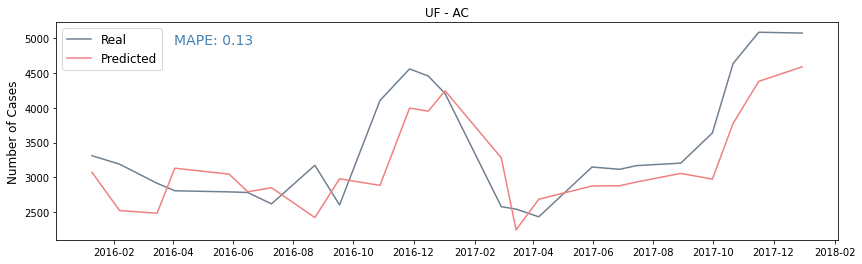

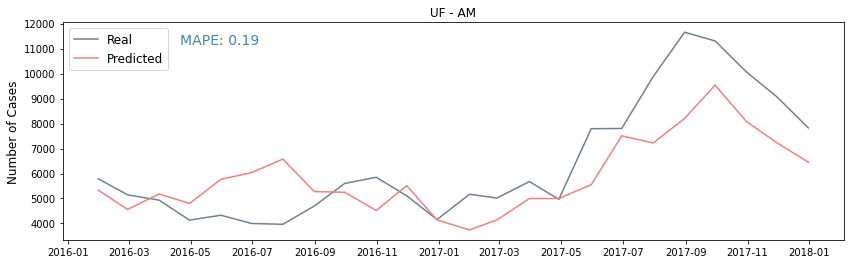

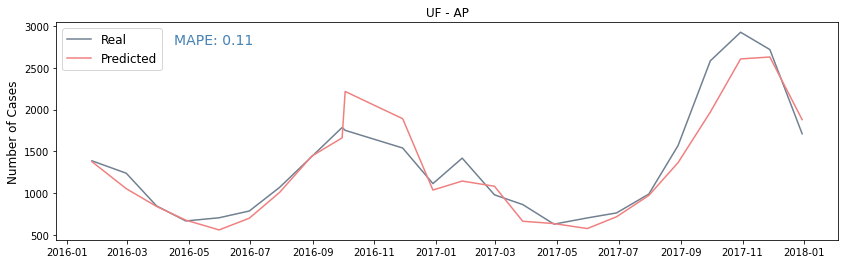

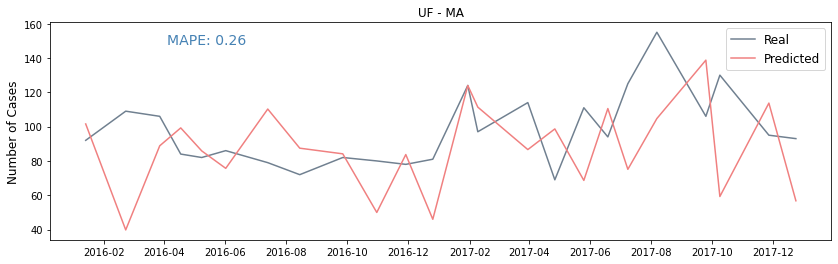

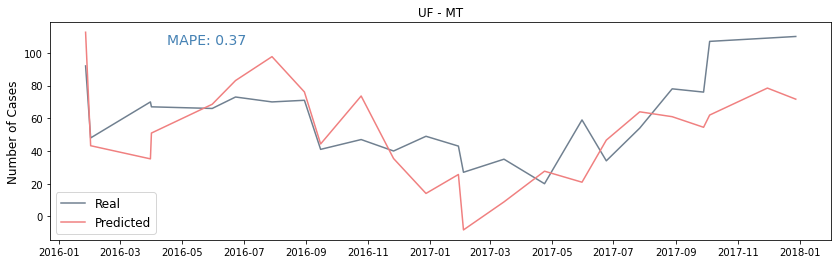

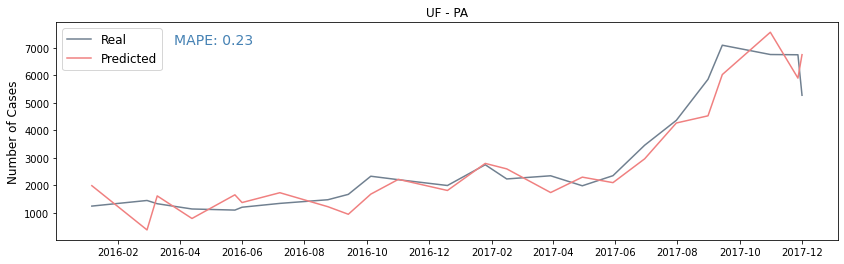

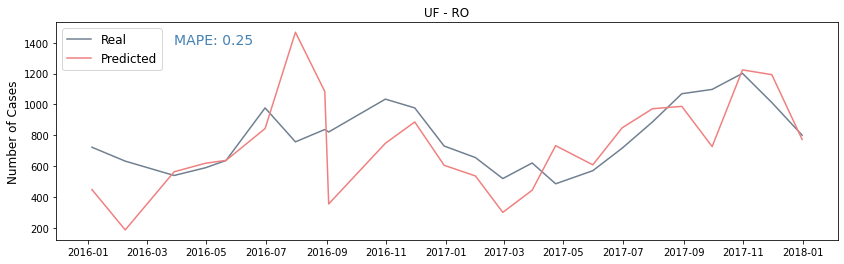

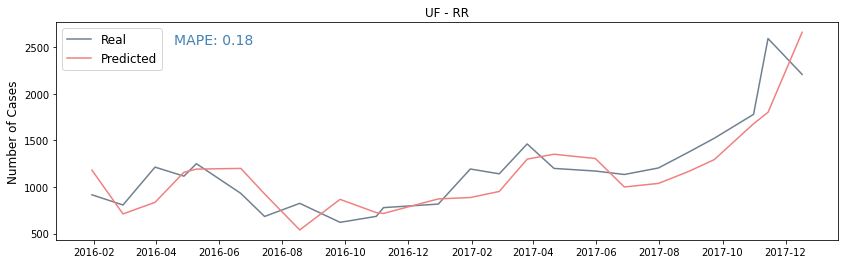

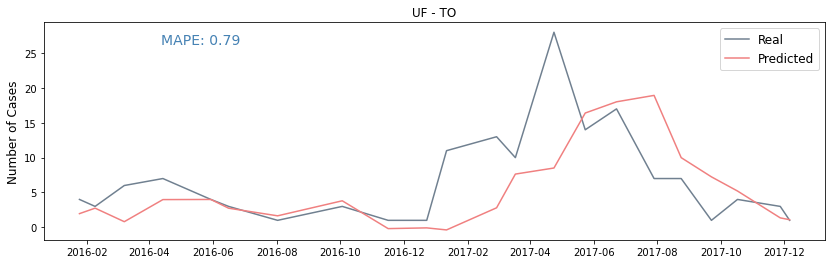

In [253]:
for uf in ufs:

    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(111)
    cond = df_result_validacao['uf_notif'] == uf
    ax.plot(df_result_validacao.loc[cond, ['dt_notif','num_cases']].set_index('dt_notif'), label='y_real', color='slategrey')
    ax.plot(df_result_validacao.loc[cond, ['dt_notif','y_pred']].set_index('dt_notif'), label='y_pred', color='lightcoral')

    #rmse = np.round(mean_squared_error(df_result_validacao.loc[cond, 'num_cases'], df_result_validacao.loc[cond, 'y_pred']),2)
    mape = np.round(mean_absolute_percentage_error(df_result_validacao.loc[cond, 'num_cases'], df_result_validacao.loc[cond, 'y_pred']), 2)

    plt.text(0.15, 0.9, 'MAPE: ' + str(mape), fontsize=14, transform=ax.transAxes, color='steelblue')
    #plt.text(0.25, 0.9, 'RMSE: ' + str(rmse), fontsize=14, transform=ax.transAxes, color='steelblue')

    # Set title and labels for axes
    ax.set(xlabel="",
          ylabel="Number of Cases",
          title=f"UF - {uf}")
  
    ax.set_ylabel("Number of Cases", fontsize=12)

  # Define the date format
    date_form = mdates.DateFormatter("%Y-%m")
    ax.xaxis.set_major_formatter(date_form)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    plt.legend(['Real', 'Predicted'], loc='best', fontsize=12)
    plt.show()

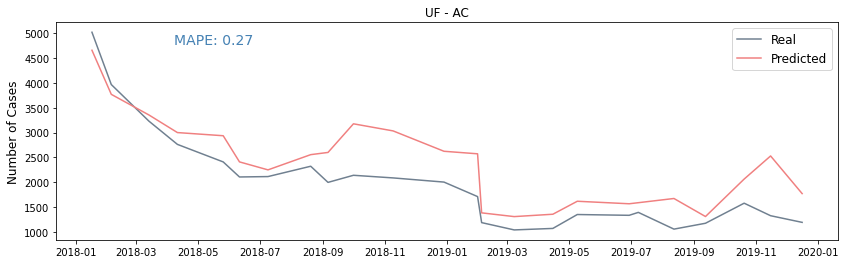

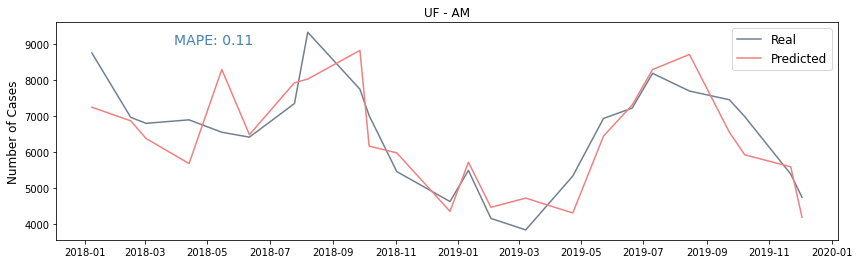

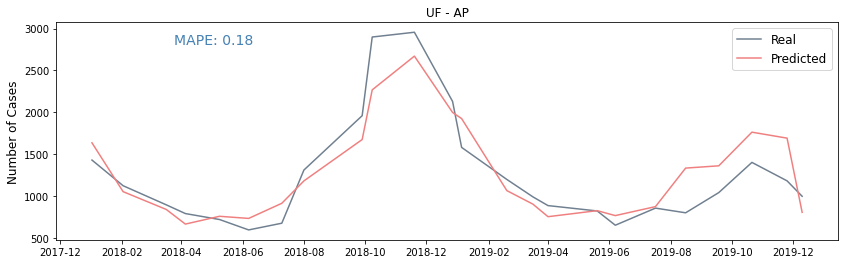

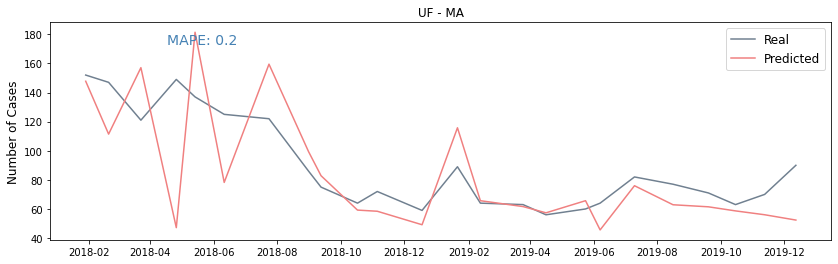

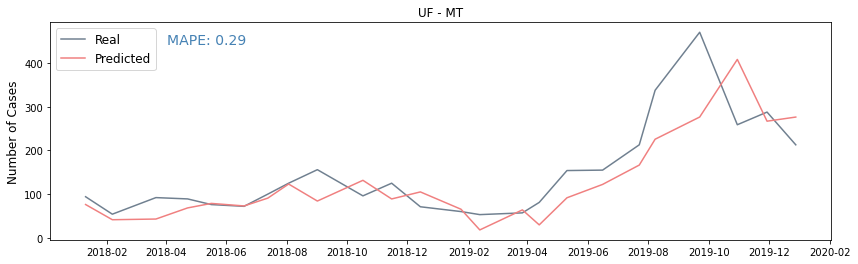

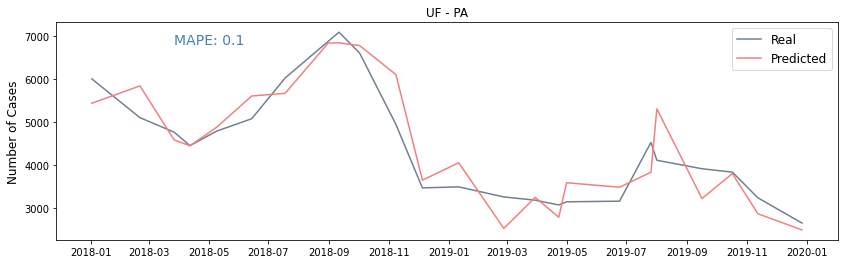

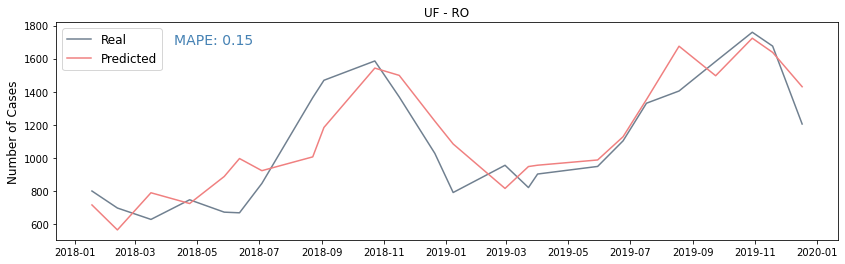

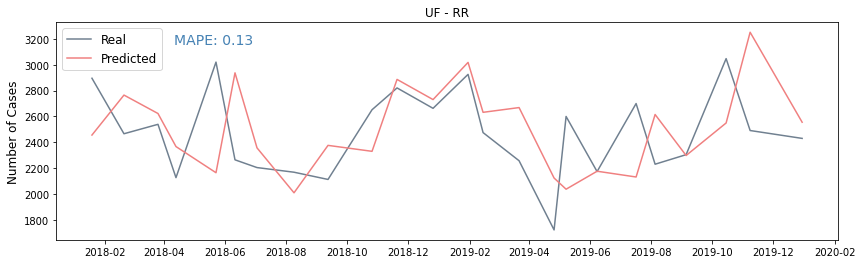

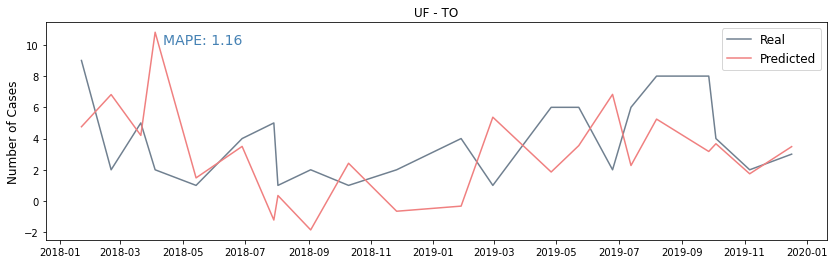

In [323]:
for uf in ufs:

    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(111)
    cond = df_result_teste['uf_notif'] == uf
    ax.plot(df_result_teste.loc[cond, ['dt_notif','num_cases']].set_index('dt_notif'), label='y_real', color='slategrey')
    ax.plot(df_result_teste.loc[cond, ['dt_notif','y_pred']].set_index('dt_notif'), label='y_pred', color='lightcoral')

    #rmse = np.round(mean_squared_error(df_result_teste.loc[cond, 'num_cases'], df_result_teste.loc[cond, 'y_pred']),2)
    mape = np.round(mean_absolute_percentage_error(df_result_teste.loc[cond, 'num_cases'], df_result_teste.loc[cond, 'y_pred']), 2)

    plt.text(0.15, 0.9, 'MAPE: ' + str(mape), fontsize=14, transform=ax.transAxes, color='steelblue')
    #plt.text(0.25, 0.9, 'RMSE: ' + str(rmse), fontsize=14, transform=ax.transAxes, color='steelblue')

    # Set title and labels for axes
    ax.set(xlabel="",
          ylabel="Number of Cases",
          title=f"UF - {uf}")
  
    ax.set_ylabel("Number of Cases", fontsize=12)

  # Define the date format
    date_form = mdates.DateFormatter("%Y-%m")
    ax.xaxis.set_major_formatter(date_form)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    plt.legend(['Real', 'Predicted'], loc='best', fontsize=12)
    plt.show()

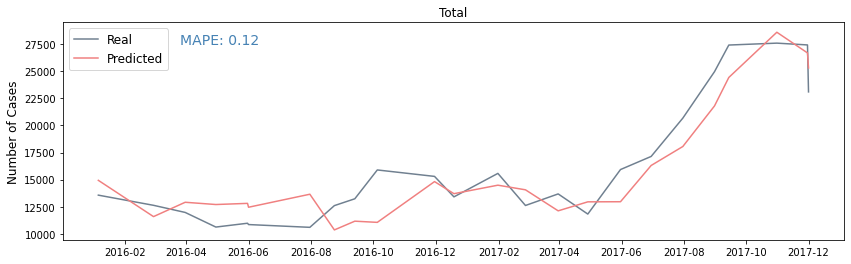

In [265]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)
ax.plot(df_result_total_validacao.loc[:, ['dt_notif','num_cases']].set_index('dt_notif'), label='y_real', color='slategrey')
ax.plot(df_result_total_validacao.loc[:, ['dt_notif','y_pred']].set_index('dt_notif'), label='y_pred', color='lightcoral')

mape = np.round(mean_absolute_percentage_error(df_result_total_validacao.loc[:,'num_cases'], df_result_total_validacao.loc[:,'y_pred']), 2)

plt.text(0.15, 0.9, 'MAPE: ' + str(mape), fontsize=14, transform=ax.transAxes, color='steelblue')

#Set title and labels for axes
ax.set(xlabel="",
      ylabel="Number of Cases",
      title=f"Total")

ax.set_ylabel("Number of Cases", fontsize=12)

#Define the date format
date_form = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.legend(['Real', 'Predicted'], loc='best', fontsize=12)
plt.show()

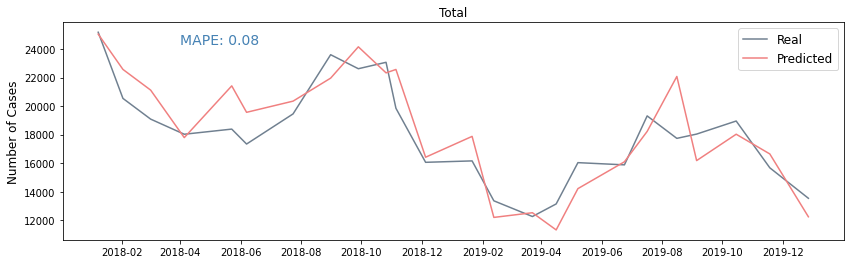

In [266]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)
ax.plot(df_result_total_teste.loc[:, ['dt_notif','num_cases']].set_index('dt_notif'), label='y_real', color='slategrey')
ax.plot(df_result_total_teste.loc[:, ['dt_notif','y_pred']].set_index('dt_notif'), label='y_pred', color='lightcoral')

mape = np.round(mean_absolute_percentage_error(df_result_total_teste.loc[:,'num_cases'], df_result_total_teste.loc[:,'y_pred']), 2)

plt.text(0.15, 0.9, 'MAPE: ' + str(mape), fontsize=14, transform=ax.transAxes, color='steelblue')

#Set title and labels for axes
ax.set(xlabel="",
      ylabel="Number of Cases",
      title=f"Total")

ax.set_ylabel("Number of Cases", fontsize=12)

#Define the date format
date_form = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.legend(['Real', 'Predicted'], loc='best', fontsize=12)
plt.show()

**Boxplot dos MAPEs por UF**

In [294]:
df_result_validacao['abs_error'] = np.abs(df_result_validacao['y_pred'] - df_result_validacao['num_cases'])
df_result_validacao.head()

,dt_notif,uf_notif,num_cases,y_pred,abs_error
108,2016-01-10,AC,3311,3072.493763,238.506237
109,2016-02-07,AC,3189,2520.716662,668.283338
110,2016-03-16,AC,2914,2482.976264,431.023736
111,2016-04-03,AC,2806,3130.834739,324.834739
112,2016-05-28,AC,2790,3045.691880,255.69188


In [324]:
df_result_teste['abs_error'] = np.abs(df_result_teste['y_pred'] - df_result_teste['num_cases'])
df_result_teste.head()

,dt_notif,uf_notif,num_cases,y_pred,abs_error
132,2018-01-17,AC,5021,4658.491620,362.50838
133,2018-02-05,AC,3968,3770.769724,197.230276
134,2018-03-14,AC,3231,3355.328251,124.328251
135,2018-04-11,AC,2763,3000.888243,237.888243
136,2018-05-26,AC,2410,2937.303829,527.303829


In [298]:
df_result_total_validacao['abs_error'] = np.abs(df_result_total_validacao['y_pred'] - df_result_total_validacao['num_cases'])
df_result_total_validacao.head()

,dt_notif,num_cases,y_pred,abs_error
108,2016-01-06,13566,14932.432372,1366.432372
109,2016-02-29,12627,11583.918075,1043.081925
110,2016-03-31,11969,12908.067459,939.067459
111,2016-04-30,10619,12699.850599,2080.850599
112,2016-05-31,10972,12806.213080,1834.21308


In [299]:
df_result_total_teste['abs_error'] = np.abs(df_result_total_teste['y_pred'] - df_result_total_teste['num_cases'])
df_result_total_teste.head()

,dt_notif,num_cases,y_pred,abs_error
132,2018-01-08,25172,25038.270176,133.729824
133,2018-02-02,20537,22567.748245,2030.748245
134,2018-03-02,19086,21118.425292,2032.425292
135,2018-04-05,18026,17789.625286,236.374714
136,2018-05-23,18386,21414.584755,3028.584755


In [464]:
for uf in ufs:
    print(f'{uf}\n')
    cond = df_result_validacao['uf_notif'] == uf
    mae_validacao = np.round(mean_absolute_error(df_result_validacao.loc[cond, 'num_cases'], df_result_validacao.loc[cond, 'y_pred']),2)
    mape_validacao = np.round(mean_absolute_percentage_error(df_result_validacao.loc[cond, 'num_cases'], df_result_validacao.loc[cond, 'y_pred']), 2)
    mse_validacao = np.round(mean_squared_error(df_result_validacao.loc[cond, 'num_cases'], df_result_validacao.loc[cond, 'y_pred']),2)
    rmse_validacao = np.round(math.sqrt(mse_validacao),2)
    rmsle_validacao = np.round(mean_squared_log_error(df_result_validacao.loc[cond, 'num_cases'], abs(df_result_validacao.loc[cond, 'y_pred'])),2)
    print(f'MSE_Validacao: {mse_validacao}')
    print(f'RMSE_Validacao: {rmse_validacao}')
    print(f'MAPE_Validacao: {mape_validacao}')
    print(f'RMSLE_Validacao: {rmsle_validacao}')
    print(f'MAE_Validacao: {mae_validacao}\n')                            
    
    cond = df_result_teste['uf_notif'] == uf
    mae_teste = np.round(mean_absolute_error(df_result_teste.loc[cond, 'num_cases'], df_result_teste.loc[cond, 'y_pred']),2)
    mape_teste = np.round(mean_absolute_percentage_error(df_result_teste.loc[cond, 'num_cases'], df_result_teste.loc[cond, 'y_pred']), 2)
    mse_teste = np.round(mean_squared_error(df_result_teste.loc[cond, 'num_cases'], df_result_teste.loc[cond, 'y_pred']),2)
    rmse_teste = np.round(math.sqrt(mse_teste),2)
    rmsle_teste = np.round(mean_squared_log_error(df_result_teste.loc[cond, 'num_cases'], abs(df_result_teste.loc[cond, 'y_pred'])),2)
    print(f'MSE_Teste: {mse_teste}')
    print(f'RMSE_Teste: {rmse_teste}')
    print(f'MAPE_Teste: {mape_teste}')
    print(f'RMSLE_Teste: {rmsle_teste}')
    print(f'MAE_Teste: {mae_teste}\n')    

AC

MSE_Validacao: 269728.25
RMSE_Validacao: 519.35
MAPE_Validacao: 0.13
RMSLE_Validacao: 0.02
MAE_Validacao: 437.31

MSE_Teste: 288279.93
RMSE_Teste: 536.92
MAPE_Teste: 0.27
RMSLE_Teste: 0.07
MAE_Teste: 443.91

AM

MSE_Validacao: 2337691.35
RMSE_Validacao: 1528.95
MAPE_Validacao: 0.19
RMSLE_Validacao: 0.05
MAE_Validacao: 1222.29

MSE_Teste: 701509.98
RMSE_Teste: 837.56
MAPE_Teste: 0.11
RMSLE_Teste: 0.02
MAE_Teste: 688.86

AP

MSE_Validacao: 46768.29
RMSE_Validacao: 216.26
MAPE_Validacao: 0.11
RMSLE_Validacao: 0.02
MAE_Validacao: 153.52

MSE_Teste: 71753.86
RMSE_Teste: 267.87
MAPE_Teste: 0.18
RMSLE_Teste: 0.04
MAE_Teste: 211.48

MA

MSE_Validacao: 1065.32
RMSE_Validacao: 32.64
MAPE_Validacao: 0.26
RMSLE_Validacao: 0.15
MAE_Validacao: 26.41

MSE_Teste: 921.54
RMSE_Teste: 30.36
MAPE_Teste: 0.2
RMSLE_Teste: 0.1
MAE_Teste: 20.69

MT

MSE_Validacao: 581.13
RMSE_Validacao: 24.11
MAPE_Validacao: 0.37
RMSLE_Validacao: 0.31
MAE_Validacao: 20.44

MSE_Teste: 4192.79
RMSE_Teste: 64.75
MAPE_Teste: 

In [456]:
mape_total_validacao = np.round(mean_absolute_percentage_error(df_result_total_validacao.loc[:, 'num_cases'], df_result_total_validacao.loc[:, 'y_pred']), 2)
mse_total_validacao = np.round(mean_squared_error(df_result_total_validacao.loc[:, 'num_cases'], df_result_total_validacao.loc[:, 'y_pred']),2)
rmse_total_validacao = np.round(math.sqrt(mse_total_validacao),2)
rmsle_total_validacao = np.round(mean_squared_log_error(df_result_total_validacao.loc[:, 'num_cases'], df_result_total_validacao.loc[:, 'y_pred']),2)
print(f'MAPE_Total_validação: {mape_total_validacao}')
print(f'RMSLE_Total_validação: {rmsle_total_validacao}')
print(f'RMSE_Total_validacao: {rmse_total_validacao}\n')

mape_total_teste = np.round(mean_absolute_percentage_error(df_result_total_teste.loc[:, 'num_cases'], df_result_total_teste.loc[:, 'y_pred']), 2)
mse_total_teste = np.round(mean_squared_error(df_result_total_teste.loc[:, 'num_cases'], df_result_total_teste.loc[:, 'y_pred']),2)
rmse_total_teste = np.round(math.sqrt(mse_total_teste),2)
rmsle_total_teste = np.round(mean_squared_log_error(df_result_total_teste.loc[:, 'num_cases'], df_result_total_teste.loc[:, 'y_pred']),2)
print(f'MAPE_Total_teste: {mape_total_teste}')
print(f'RMSLE_Total_teste: {rmsle_total_teste}')
print(f'RMSE_Total_teste: {rmse_total_teste}')

MAPE_Total_validação: 0.12
RMSLE_Total_validação: 0.02
RMSE_Total_validacao: 2094.31

MAPE_Total_teste: 0.08
RMSLE_Total_teste: 0.01
RMSE_Total_teste: 1759.78


In [309]:
df_result_validacao['abs_error_p'] = np.abs(df_result_validacao['y_pred'] - df_result_validacao['num_cases']) / df_result_validacao['num_cases']

In [327]:
df_result_teste['abs_error_p'] = np.abs(df_result_teste['y_pred'] - df_result_teste['num_cases']) / df_result_teste['num_cases']

In [310]:
df_result_total_validacao['abs_error_p'] = np.abs(df_result_total_validacao['y_pred'] - df_result_total_validacao['num_cases']) / df_result_total_validacao['num_cases']

In [311]:
df_result_total_teste['abs_error_p'] = np.abs(df_result_total_teste['y_pred'] - df_result_total_teste['num_cases']) / df_result_total_teste['num_cases']

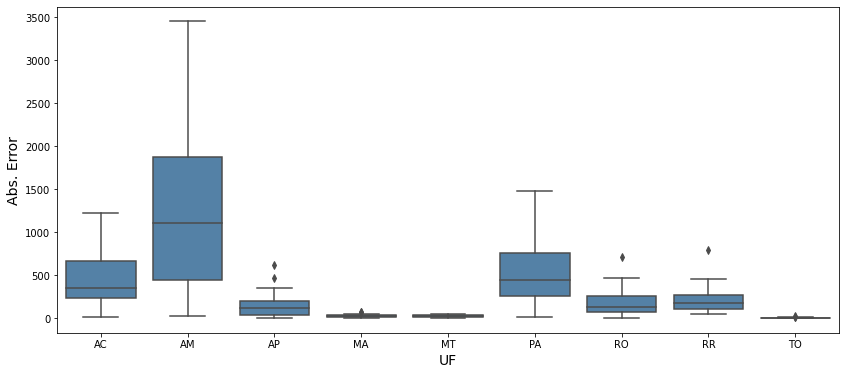

In [313]:
plt.figure(figsize=(14,6))
sns.boxplot(x='uf_notif', y='abs_error', data=df_result_validacao, color='steelblue')
plt.xlabel("UF", size=14)
plt.ylabel("Abs. Error", size=14)
plt.show()

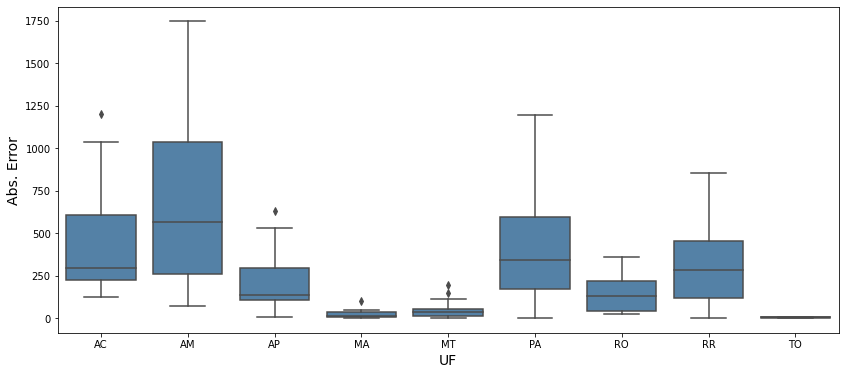

In [328]:
plt.figure(figsize=(14,6))
sns.boxplot(x='uf_notif', y='abs_error', data=df_result_teste, color='steelblue')
plt.xlabel("UF", size=14)
plt.ylabel("Abs. Error", size=14)
plt.show()

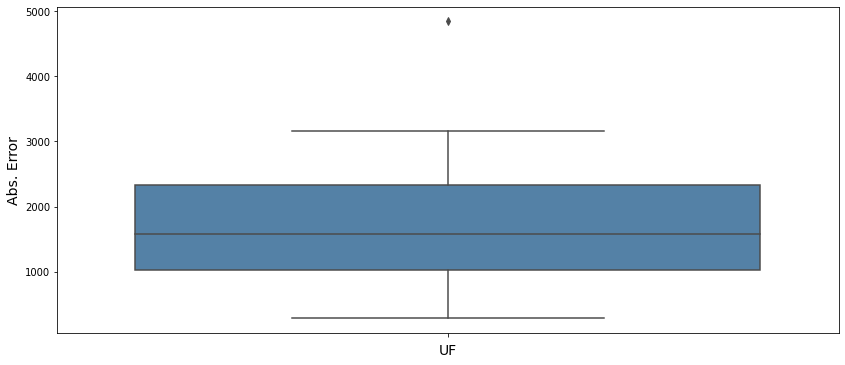

In [314]:
plt.figure(figsize=(14,6))
sns.boxplot(y='abs_error', data=df_result_total_validacao, color='steelblue')
plt.xlabel("UF", size=14)
plt.ylabel("Abs. Error", size=14)
plt.show()

In [1]:
plt.figure(figsize=(14,6))
sns.boxplot(y='abs_error', data=df_result_total_teste, color='steelblue')
plt.xlabel("UF", size=14)
plt.ylabel("Abs. Error", size=14)
plt.show()

NameError: name 'plt' is not defined

AC
MAPE: 0.16

AM
MAPE: 0.25

AP
MAPE: 0.17

MA
MAPE: 0.25

MT
MAPE: 0.52

PA
MAPE: 0.31

RO
MAPE: 0.27

RR
MAPE: 0.22

TO
MAPE: 1.71
